# Spam Classifier

In [44]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the tokenizer and model
spam_tokenizer = AutoTokenizer.from_pretrained("AntiSpamInstitute/spam-detector-bert-MoE-v2.2")
spam_model = AutoModelForSequenceClassification.from_pretrained("AntiSpamInstitute/spam-detector-bert-MoE-v2.2")

# Sentiment Analyser

In [2]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='sentiment'
sentiment_model = f"cardiffnlp/twitter-roberta-base-{task}"
sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_model)

# download label mapping
labels = []
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model)

1) positive 0.8466
2) neutral 0.1458
3) negative 0.0076


# Sarcasm Detector

In [3]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='irony'
irony_model = f"cardiffnlp/twitter-roberta-base-{task}"
irony_tokenizer = AutoTokenizer.from_pretrained(irony_model)

# download label mapping
labels = []
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
irony_model = AutoModelForSequenceClassification.from_pretrained(irony_model)
#sentiment_model.save_pretrained(sentiment_model)

1) irony 0.8759
2) non_irony 0.1241


# Preprocessing

In [4]:
import pandas as pd

# Load your CSV
df = pd.read_csv("final_eval_dataset_reviews.csv", encoding='latin1')

# Apply preprocessing to each review
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '<link>' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Create a new column for preprocessed reviews
df['preprocessed_review'] = df['text'].apply(preprocess)

print(df[['text', 'preprocessed_review']].head())


df.to_csv("processed_reviews.csv", index=False)

                                                text  \
0  Big supermarket here with two storey. Can find...   
1  Tried to collect book bugs. Before 5pm the lib...   
2  Oh, my God, it's just a wavey. Wooden bridge w...   
3  No sheltered pathway out of the office buildin...   
4                   hard to find and so confusing...   

                                 preprocessed_review  
0  Big supermarket here with two storey. Can find...  
1  Tried to collect book bugs. Before 5pm the lib...  
2  Oh, my God, it's just a wavey. Wooden bridge w...  
3  No sheltered pathway out of the office buildin...  
4                   hard to find and so confusing...  


# Run Classifiers

In [5]:
import pandas as pd

# Function to run all classifiers
def run_classifiers(preprocessed_text):
    results = {}
    try:
        # Spam
        inputs = spam_tokenizer(preprocessed_text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = spam_model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1).numpy()[0]
        pred = np.argmax(probs)
        results['spam_label_'] = "Spam" if pred == 1 else "Not Spam"

        # Sentiment
        inputs = sentiment_tokenizer(preprocessed_text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = sentiment_model(**inputs)
        scores = softmax(outputs.logits.detach().numpy()[0])
        pred = np.argmax(scores)
        labels_list = ['Negative', 'Neutral', 'Positive']
        results['sentiment_label_'] = labels_list[pred]

        # Sarcasm
        inputs = irony_tokenizer(preprocessed_text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = irony_model(**inputs)
        scores = softmax(outputs.logits.detach().numpy()[0])
        pred = np.argmax(scores)
        results['sarcasm_label_'] = "Sarcastic" if pred == 1 else "Not Sarcastic"

    except Exception as e:
        # fallback if model fails
        results['spam_label_'] = 'Error'
        results['sentiment_label_'] = 'Error'
        results['sarcasm_label_'] = 'Error'

    return pd.Series(results)

# Apply to your DataFrame
df[['spam_label_', 'sentiment_label_', 'sarcasm_label_']] = df['preprocessed_review'].apply(run_classifiers)

# Check
print(df[['spam_label_', 'sentiment_label_', 'sarcasm_label_']].head())

df.to_csv("processed_reviews.csv", index=False)


  spam_label_ sentiment_label_ sarcasm_label_
0    Not Spam         Negative  Not Sarcastic
1    Not Spam         Negative  Not Sarcastic
2    Not Spam         Positive  Not Sarcastic
3    Not Spam         Negative  Not Sarcastic
4    Not Spam         Negative  Not Sarcastic


# Relevancy Scoring

In [6]:
import pandas as pd
import spacy
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv("processed_reviews.csv")
nlp = spacy.load("en_core_web_lg")

def compute_relevance(row):
    review = row['preprocessed_review']
    categories = row['categoryName']  # column in your CSV
    types = row['types']              # column in your CSV
    
    types_in_array = [x.strip().replace("_", " ") for x in types.split(",")]
    types_in_array.append(categories)
    types_in_array = [t for t in types_in_array if t not in ['point of interest', 'establishment']]
    
    word_vec = sum([nlp(k).vector for k in types_in_array]) / len(types_in_array)
    word_vec = word_vec.reshape(1, -1)
    
    doc = nlp(review)
    score = sum([cosine_similarity(word_vec, sent.vector.reshape(1,-1))[0][0] for sent in doc.sents])
    avg_score = score / len(list(doc.sents)) if len(list(doc.sents)) != 0 else 0
    
    relevance_threshold = 0.3
    label = "Relevant" if avg_score >= relevance_threshold else "Not Relevant"
    
    return pd.Series([avg_score, label])

df[['relevance_score', 'relevance_label']] = df.apply(compute_relevance, axis=1)
df.to_csv("processed_reviews1.csv", index=False)


# Run Summariser

In [37]:
import requests

def ollama_summarize(text, category,max_words=100, model="llama3.2"):
    prompt = f"""
            You are a review summarizer. 
            Your task is to read a user review and generate a short, concise summary that captures the main points and meaning 
            without losing important details. 
            
            Use clear and simple language. 
            Keep the summary brief, ideally two or three sentences. 
            Do not add opinions or extra information not present in the review. 

            If the review seems negative, include the word negative in the summary.
            If the review seems like an average experience, use the word average in the summary.
            If the review seems like a positive experience, use the word positive in the summary.
            If the review does not describe the location itself, its services, facilities, or the user’s experience there → Output: Briefly explain why the review is irrelevant, and include the word irrelevant in the sentence.
            If the review is too promotional/advertisement-like to a brand or product→ Output: Summarise the promotional content and explain why it sounds promotional and include the word advertisement-like in the sentence.
            If the review explicitly discriminates against certain groups or races → Output: Identify the group being discriminated against and use the word insensitive in the sentence.
            If the review is informative (about the location) → Output: Summarise the main points of information given in 1–2 sentences, and use the word informative in the sentence.
            If the reviewer seems like they did not go to the location before → Output: Explain why it seems the reviewer did not go and use the phrase did not visit in the sentence.
            
            You are given some context to the user review, including whether sarcasm is present. 
            If sarcasm is detected, interpret the review accordingly and summarize the intended meaning rather than the literal words.
            
            Summarize the following text in at most {max_words} words. 
            
            Keep the reply in this format:
            1) Location Type 
            2) Summarised Review
            
            Here are some examples:
            
            User: Location: MRT Station "On my way to my teacher's event, just had lunch before I left"  
            Model:  
            1) MRT Station  
            2) The review discusses personal activities and lunch, which are irrelevant to the MRT station experience.
            
            User: Location : Store "Get the new sleek and trendy sunglasses today at sunglaz"
            Model:
            1) Store
            2) The review sounds very promotional and advertisement-like for sunglaz sunglasses
            
            User: Location : Tourist Attraction "There is just too many foreigners here nowadays, everyone should go back to where they came from."
            Model:
            1) Tourist Attraction
            2) The reviewer is insensitive and discriminates against foreigners visiting the tourist attraction.
            
            User: Location : Hotel "The hotel was average with okay service. Staff were friendly and the breakfast buffet had a lot of options. It is close to many bus interchanges and mrt stations"
            Model:
            1) Hotel
            2) Average hotel with okay service, friendly staff ,and a wide breakfast buffet. The reviewer also gives informative facts that the hotel is also close to many bus interchanges and mrt stations.
            
            User: Location : Tourist Attraction "I came here and it was closed, my friends mentioned that the place is smelly though I have never been"
            Model:
            1) Tourist Attraction
            2) The reviewer came when the attraction was closed, and did not enter. The reviewer also mentioned that they did not visit the attraction.
            
            User: "This park is very peaceful and clean. A great place to walk and relax during my lunch break."
            Model:
            1) Park
            2) The reviewer had a positive experience with the cleanliness and peacefulness of the park. They like to relax in the park during their lunch break.
            
            User: "The restaurant food was cold and service was slow. Not worth the money."
            Model:
            1) Restaurant
            2) The reviewer had a negative experience with the cold food and slow service from the restaurant, and notes that the experience was not worth the money.
            
            User : Location : Cafe (Sarcastic) "Oh great, another long line at the cafe. Just what I needed today."
            Model:
            1) Cafe
            2) The reviewer had a negative experience with the long line at the cafe.

            User : Location : Restaurant "The food was okay, and the restaurant was not so crowded"
            Model:
            1) Cafe
            2) The reviewer had an average experience and was neutral about the experience because the food was average.
            
            Now summarize this review: 
            Do not add opinions or extra information not present in the review.
            Location : {category} "{text}"
            """

    r = requests.post(
        "http://localhost:11434/api/generate",
        json={"model": model, "prompt": prompt, "stream": False},
        timeout=300
    )
    r.raise_for_status()
    return r.json()["response"].strip()

In [38]:
import pandas as pd
from tqdm import tqdm

# Config
batch_size = 1  # number of reviews per batch

# Load CSV
df = pd.read_csv("processed_reviews1.csv")

# Function to build modified review text
def build_modified_review(row):
    text = row['preprocessed_review']

    # Add sarcasm hint
    if row.get('sarcasm_label_') == "Sarcastic":
        text += " (Sarcastic)"

    text += f" Category: {row.get('categoryName', 'Unknown')}"

    return text

# Function to append labels to summary
def append_labels(row, summary):
    labels = []

    if row.get('sentiment_label_'):
        labels.append(row['sentiment_label_'])

    if row.get('spam_label_') == "Spam":
        labels.append("Spam")

    if row.get('sarcasm_label_') == "Sarcastic":
        labels.append("Sarcastic")

    if row.get('relevance_label') == "Not Relevant":
        labels.append("Irrelevant")

    if labels:
        return summary + " | Labels: " + ", ".join(labels)
    return summary

# Build modified reviews column
df['modified_review'] = df.apply(build_modified_review, axis=1)

# Summarize in batches
all_summaries = []

for i in tqdm(range(0, len(df), batch_size)):
    batch = df.iloc[i:i+batch_size]

    # Prepare batch lists
    batch_texts = batch['modified_review']#.tolist() since batch size = 1 we dont neeed list
    batch_categories = batch['categoryName']#.tolist()

    # Summarize all reviews in the batch at once (if supported)
    batch_summaries = ollama_summarize(batch_texts, batch_categories)
    print(batch_texts)
    print(batch_summaries)
    print("\n")

    # Append labels to each summary
    for j, row in batch.iterrows():
        summary_with_labels = append_labels(row, batch_summaries)
        print(summary_with_labels)
        all_summaries.append(summary_with_labels)

# Add final summaries to dataframe
df['summary'] = all_summaries

# Save to a new CSV
df.to_csv("processed_reviews2.csv", index=False)

print("Summarization complete! Saved to processed_reviews.csv")



  0%|▎                                                                                 | 1/314 [00:07<40:15,  7.72s/it]

0    Big supermarket here with two storey. Can find...
Name: modified_review, dtype: object
1) Grocery Store  
2) The review is irrelevant as it does not describe the grocery store itself or the user's experience there.


1) Grocery Store  
2) The review is irrelevant as it does not describe the grocery store itself or the user's experience there. | Labels: Negative


  1%|▌                                                                                 | 2/314 [00:10<24:44,  4.76s/it]

1    Tried to collect book bugs. Before 5pm the lib...
Name: modified_review, dtype: object
1) Public Library  
2) The reviewer attempted to collect book bugs before 5 pm at the public library.


1) Public Library  
2) The reviewer attempted to collect book bugs before 5 pm at the public library. | Labels: Negative


  1%|▊                                                                                 | 3/314 [00:13<20:09,  3.89s/it]

2    Oh, my God, it's just a wavey. Wooden bridge w...
Name: modified_review, dtype: object
1) Bridge 
2) The reviewer describes the bridge as wavey and made of wood, but does not provide further details about its features or condition.


1) Bridge 
2) The reviewer describes the bridge as wavey and made of wood, but does not provide further details about its features or condition. | Labels: Positive, Irrelevant


  1%|█                                                                                 | 4/314 [00:16<17:49,  3.45s/it]

3    No sheltered pathway out of the office buildin...
Name: modified_review, dtype: object
1) Corporate Office  
2) The reviewer mentions a lack of a sheltered pathway out of the building, which is a negative aspect of their experience.


1) Corporate Office  
2) The reviewer mentions a lack of a sheltered pathway out of the building, which is a negative aspect of their experience. | Labels: Negative


  2%|█▎                                                                                | 5/314 [00:18<16:16,  3.16s/it]

4    hard to find and so confusing... Category: Sub...
Name: modified_review, dtype: object
1) Train Station
2) The review is negative, discussing difficulties in finding the station and feeling confused about it.


1) Train Station
2) The review is negative, discussing difficulties in finding the station and feeling confused about it. | Labels: Negative


  2%|█▌                                                                                | 6/314 [00:21<15:21,  2.99s/it]

5    MRT station toilet cleaning needs improvement....
Name: modified_review, dtype: object
1) MRT Station  
2) The review discusses a specific issue with the MRT station's toilet cleaning.


1) MRT Station  
2) The review discusses a specific issue with the MRT station's toilet cleaning. | Labels: Negative


  2%|█▊                                                                                | 7/314 [00:24<14:47,  2.89s/it]

6    Very basic and no sitting arrangements for the...
Name: modified_review, dtype: object
1) Park
2) The review discusses that the park is very basic with no sitting arrangements for visitors.


1) Park
2) The review discusses that the park is very basic with no sitting arrangements for visitors. | Labels: Negative, Irrelevant


  3%|██                                                                                | 8/314 [00:26<14:25,  2.83s/it]

7    Inconvenient place to walk to mrt station sinc...
Name: modified_review, dtype: object
1) Railway Station  
2) The reviewer describes the railway station as an inconvenient location to reach the MRT station.


1) Railway Station  
2) The reviewer describes the railway station as an inconvenient location to reach the MRT station. | Labels: Neutral


  3%|██▎                                                                               | 9/314 [00:29<14:24,  2.83s/it]

8    i dont get the long queue hype over this hong ...
Name: modified_review, dtype: object
1) Hawker Center
2) The reviewer is negative about their experience at the hawker center due to the long queues and does not appreciate the popularity of the place.


1) Hawker Center
2) The reviewer is negative about their experience at the hawker center due to the long queues and does not appreciate the popularity of the place. | Labels: Negative


  3%|██▌                                                                              | 10/314 [00:32<14:23,  2.84s/it]

9    Security anyhow clamp peopleâs car even with...
Name: modified_review, dtype: object
1) Condominium complex  
2) The reviewer mentions a security issue where the condominium complex's security clamps down on people's cars, indicating a negative experience.


1) Condominium complex  
2) The reviewer mentions a security issue where the condominium complex's security clamps down on people's cars, indicating a negative experience. | Labels: Negative


  4%|██▊                                                                              | 11/314 [00:35<14:03,  2.78s/it]

10    Overall, the situation is acceptable now that ...
Name: modified_review, dtype: object
1) Condominium complex  
2) The reviewer mentions that the situation is acceptable now, indicating a positive experience.


1) Condominium complex  
2) The reviewer mentions that the situation is acceptable now, indicating a positive experience. | Labels: Negative


  4%|███                                                                              | 12/314 [00:37<13:54,  2.76s/it]

11    People harashing girls in metro no safety on r...
Name: modified_review, dtype: object
1) Railway Services  
2) The review discusses a negative experience with people harassing girls in the metro and a lack of safety.


1) Railway Services  
2) The review discusses a negative experience with people harassing girls in the metro and a lack of safety. | Labels: Negative, Sarcastic


  4%|███▎                                                                             | 13/314 [00:40<13:38,  2.72s/it]

12    Discrimination against gym-going people. 8 out...
Name: modified_review, dtype: object
1) Transportation Service
2) The review is negative and discriminates against gym-going people.


1) Transportation Service
2) The review is negative and discriminates against gym-going people. | Labels: Negative, Sarcastic


  4%|███▌                                                                             | 14/314 [00:43<14:06,  2.82s/it]

13    Real surprises, EXIT OUT TOWARDS THE BENDEMEER...
Name: modified_review, dtype: object
1) Railway Services  
2) The review does not provide any information about the railway services themselves. The text contains only a reference to an exit and a location named Bendeemer which seems irrelevant to the context of railway services.


1) Railway Services  
2) The review does not provide any information about the railway services themselves. The text contains only a reference to an exit and a location named Bendeemer which seems irrelevant to the context of railway services. | Labels: Negative, Irrelevant


  5%|███▊                                                                             | 15/314 [00:46<13:45,  2.76s/it]

14    MRT was worst and the train was pack of people...
Name: modified_review, dtype: object
1) Subway Station
2) The review discusses a negative experience with the subway station, specifically the crowded trains.


1) Subway Station
2) The review discusses a negative experience with the subway station, specifically the crowded trains. | Labels: Negative


  5%|████▏                                                                            | 16/314 [00:48<13:35,  2.74s/it]

15    signage and directions there are unclear. i we...
Name: modified_review, dtype: object
1) Subway Station
2) The reviewer experienced a negative experience due to unclear signage and directions at the subway station.


1) Subway Station
2) The reviewer experienced a negative experience due to unclear signage and directions at the subway station. | Labels: Neutral


  5%|████▍                                                                            | 17/314 [00:51<13:26,  2.72s/it]

16    I felt slightly inconvenienced this morning wh...
Name: modified_review, dtype: object
1) Railway Station
2) The reviewer felt slightly inconvenienced during their railway journey.


1) Railway Station
2) The reviewer felt slightly inconvenienced during their railway journey. | Labels: Negative


  6%|████▋                                                                            | 18/314 [00:54<13:17,  2.69s/it]

17    Nice decorations that I really enjoy looking a...
Name: modified_review, dtype: object
1) Shopping Mall  
2) The reviewer seems to have enjoyed the nice decorations at the shopping mall.


1) Shopping Mall  
2) The reviewer seems to have enjoyed the nice decorations at the shopping mall. | Labels: Negative, Sarcastic, Irrelevant


  6%|████▉                                                                            | 19/314 [00:56<13:21,  2.72s/it]

18    I topped up for one team lessons (+$13/LESSON)...
Name: modified_review, dtype: object
1) Driving School  
2) The reviewer mentions topping up for a lesson and additional cost, but does not provide further details about their experience.


1) Driving School  
2) The reviewer mentions topping up for a lesson and additional cost, but does not provide further details about their experience. | Labels: Negative


  6%|█████▏                                                                           | 20/314 [00:59<13:33,  2.77s/it]

19    Totally no cash payment. Kids went to buy thin...
Name: modified_review, dtype: object
1) Sporting Goods Store
2) The review mentions that the store does not accept cash payments and notes a family's attempt to buy something without being able to do so due to this policy.


1) Sporting Goods Store
2) The review mentions that the store does not accept cash payments and notes a family's attempt to buy something without being able to do so due to this policy. | Labels: Negative


  7%|█████▍                                                                           | 21/314 [01:02<13:33,  2.78s/it]

20    [DONT RENT HERE] One of the shop with monopoly...
Name: modified_review, dtype: object
1) Bicycle Rental Service
2) The reviewer warns against renting bicycles from this service, mentioning they have a monopoly and to not rent here.


1) Bicycle Rental Service
2) The reviewer warns against renting bicycles from this service, mentioning they have a monopoly and to not rent here. | Labels: Negative


  7%|█████▋                                                                           | 22/314 [01:05<13:33,  2.79s/it]

21    Realized that recently there are many pet owne...
Name: modified_review, dtype: object
1) Shopping Mall
2) The reviewer realized they own a pet owl and is now aware of the increasing number of people with pets in their neighborhood.


1) Shopping Mall
2) The reviewer realized they own a pet owl and is now aware of the increasing number of people with pets in their neighborhood. | Labels: Negative, Irrelevant


  7%|█████▉                                                                           | 23/314 [01:08<13:21,  2.75s/it]

22    Steep slope into the carpark, missing signs fo...
Name: modified_review, dtype: object
1) Business Center
2) The review discusses a negative experience with a steep slope in the carpark and missing signs.


1) Business Center
2) The review discusses a negative experience with a steep slope in the carpark and missing signs. | Labels: Positive, Sarcastic


  8%|██████▏                                                                          | 24/314 [01:10<13:12,  2.73s/it]

23    On 29 Jan 2025, 1448h, the door closed unexpec...
Name: modified_review, dtype: object
1) Transportation Service
2) The reviewer had a negative experience with the transportation service as the door closed unexpectedly.


1) Transportation Service
2) The reviewer had a negative experience with the transportation service as the door closed unexpectedly. | Labels: Negative, Spam


  8%|██████▍                                                                          | 25/314 [01:13<13:21,  2.77s/it]

24    The location is great and housekeeping team do...
Name: modified_review, dtype: object
1) Hotel
2) The reviewer mentions that the hotel's location is great and praises the housekeeping team, but the review does not provide further details about their experience.


1) Hotel
2) The reviewer mentions that the hotel's location is great and praises the housekeeping team, but the review does not provide further details about their experience. | Labels: Positive


  8%|██████▋                                                                          | 26/314 [01:16<13:29,  2.81s/it]

25    I try to avoid eating at Hong Lim because of t...
Name: modified_review, dtype: object
1) Hawker Center
2) The reviewer tries to avoid eating at the hawker center due to a personal reason which is not specified in the review.


1) Hawker Center
2) The reviewer tries to avoid eating at the hawker center due to a personal reason which is not specified in the review. | Labels: Negative


  9%|██████▉                                                                          | 27/314 [01:19<13:29,  2.82s/it]

26    The carpark is ridiculous, no indication of it...
Name: modified_review, dtype: object
1) Shopping Mall
2) The reviewer found the car park at the shopping mall to be poorly signposted, which they find ridiculous.


1) Shopping Mall
2) The reviewer found the car park at the shopping mall to be poorly signposted, which they find ridiculous. | Labels: Negative, Irrelevant


  9%|███████▏                                                                         | 28/314 [01:21<12:59,  2.73s/it]

27    The management of Kinex Mall is really disappo...
Name: modified_review, dtype: object
1) Shopping Mall
2) The reviewer mentions a negative experience with the management of Kinex Mall.


1) Shopping Mall
2) The reviewer mentions a negative experience with the management of Kinex Mall. | Labels: Negative, Irrelevant


  9%|███████▍                                                                         | 29/314 [01:24<13:13,  2.79s/it]

28    The 2 ladies at the ticket counter and the inf...
Name: modified_review, dtype: object
1) Transportation Service
2) The review mentions two ladies at the ticket counter and an issue with the information not being provided, but it is too short to be informative.


1) Transportation Service
2) The review mentions two ladies at the ticket counter and an issue with the information not being provided, but it is too short to be informative. | Labels: Negative


 10%|███████▋                                                                         | 30/314 [01:27<13:19,  2.82s/it]

29    PUB needs to take measures to ensure the safet...
Name: modified_review, dtype: object
1) Picnic Ground
2) The reviewer is concerned about safety issues at a pub, but the review seems irrelevant to a picnic ground as it mentions a different location.


1) Picnic Ground
2) The reviewer is concerned about safety issues at a pub, but the review seems irrelevant to a picnic ground as it mentions a different location. | Labels: Negative


 10%|███████▉                                                                         | 31/314 [01:30<13:00,  2.76s/it]

30    Very rude staff. At the entrance a staff membe...
Name: modified_review, dtype: object
1) Casino  
2) The reviewer had a negative experience with very rude staff at the casino's entrance.


1) Casino  
2) The reviewer had a negative experience with very rude staff at the casino's entrance. | Labels: Negative, Irrelevant


 10%|████████▎                                                                        | 32/314 [01:33<12:59,  2.77s/it]

31    At Wings of Art 2025, which runs from Jun 25 t...
Name: modified_review, dtype: object
1) Shopping Mall  
2) The reviewer mentions a specific event held at the shopping mall, which is irrelevant to the overall experience of the mall.


1) Shopping Mall  
2) The reviewer mentions a specific event held at the shopping mall, which is irrelevant to the overall experience of the mall. | Labels: Negative, Irrelevant


 11%|████████▌                                                                        | 33/314 [01:35<12:58,  2.77s/it]

32    when i was around 6-7 years old, i have met a ...
Name: modified_review, dtype: object
1) Recreation Center 
2) The reviewer mentions meeting someone at the recreation center when they were around 6-7 years old, but does not provide further information.


1) Recreation Center 
2) The reviewer mentions meeting someone at the recreation center when they were around 6-7 years old, but does not provide further information. | Labels: Negative


 11%|████████▊                                                                        | 34/314 [01:38<12:46,  2.74s/it]

33    Probably could do something to improve the sit...
Name: modified_review, dtype: object
1) Railway Services  
2) The reviewer found a railway service to be average and thinks it has room for improvement.


1) Railway Services  
2) The reviewer found a railway service to be average and thinks it has room for improvement. | Labels: Negative


 11%|█████████                                                                        | 35/314 [01:41<12:42,  2.73s/it]

34    I stayed at this so-called 5-star hotel and wa...
Name: modified_review, dtype: object
1) Hotel
2) The reviewer is staying at a self-described 5-star hotel but does not elaborate on the experience itself.


1) Hotel
2) The reviewer is staying at a self-described 5-star hotel but does not elaborate on the experience itself. | Labels: Negative, Irrelevant


 11%|█████████▎                                                                       | 36/314 [01:43<12:42,  2.74s/it]

35    If you are renting any units here. Please stay...
Name: modified_review, dtype: object
1) Corporate Office  
2) The reviewer is warning potential renters to stay away from the corporate office due to unmentioned issues with rented units.


1) Corporate Office  
2) The reviewer is warning potential renters to stay away from the corporate office due to unmentioned issues with rented units. | Labels: Negative


 12%|█████████▌                                                                       | 37/314 [01:46<12:50,  2.78s/it]

36    Ever since people started living here last yea...
Name: modified_review, dtype: object
1) Condominium complex  
2) The review discusses past events and activities that took place in the condominium complex, which are irrelevant to the current experience.


1) Condominium complex  
2) The review discusses past events and activities that took place in the condominium complex, which are irrelevant to the current experience. | Labels: Negative


 12%|█████████▊                                                                       | 38/314 [01:49<12:45,  2.77s/it]

37    Will scam you on the bill.\n\n1 guinness adver...
Name: modified_review, dtype: object
1) Club  
2) The reviewer warns that they were scammed on their bill at the club.


1) Club  
2) The reviewer warns that they were scammed on their bill at the club. | Labels: Negative, Irrelevant


 12%|██████████                                                                       | 39/314 [01:52<12:48,  2.80s/it]

38    Our recent visit to the Casino at Sentosa was ...
Name: modified_review, dtype: object
1) Casino
2) The reviewer had a positive experience with their recent visit to the Casino at Sentosa, mentioning that they enjoyed their time there.


1) Casino
2) The reviewer had a positive experience with their recent visit to the Casino at Sentosa, mentioning that they enjoyed their time there. | Labels: Negative, Irrelevant


 13%|██████████▎                                                                      | 40/314 [01:55<12:32,  2.75s/it]

39    So worse experience for the membership applica...
Name: modified_review, dtype: object
1) Casino
2) The reviewer had a negative experience with their membership application process at the casino.


1) Casino
2) The reviewer had a negative experience with their membership application process at the casino. | Labels: Negative, Irrelevant


 13%|██████████▌                                                                      | 41/314 [01:58<12:49,  2.82s/it]

40    Come enjoy the crowd! Be loved. Be touched. Sm...
Name: modified_review, dtype: object
1) Subway Station  
2) The review seems advertisement-like and sounds like a promotional message for a subway station, but it's unclear what specific aspects of the experience are being advertised.


1) Subway Station  
2) The review seems advertisement-like and sounds like a promotional message for a subway station, but it's unclear what specific aspects of the experience are being advertised. | Labels: Positive, Irrelevant


 13%|██████████▊                                                                      | 42/314 [02:01<12:57,  2.86s/it]

41    Biggest tourist rip-off anywhere. Not worth th...
Name: modified_review, dtype: object
1) Mountain Cable Car
2) The review describes a negative experience at the mountain cable car, calling it a "tourist rip-off" and stating that it is not worth the money.


1) Mountain Cable Car
2) The review describes a negative experience at the mountain cable car, calling it a "tourist rip-off" and stating that it is not worth the money. | Labels: Neutral


 14%|███████████                                                                      | 43/314 [02:03<12:29,  2.76s/it]

42    seems like a discriminative club to me persona...
Name: modified_review, dtype: object
1) Social Club  
2) The reviewer describes the social club as discriminative.


1) Social Club  
2) The reviewer describes the social club as discriminative. | Labels: Neutral


 14%|███████████▎                                                                     | 44/314 [02:06<12:29,  2.78s/it]

43    Considering Singapore is touted as being clean...
Name: modified_review, dtype: object
1) Mosque
2) The reviewer is mentioning that Singapore is touted as being clean, which is not directly related to the mosque itself.


1) Mosque
2) The reviewer is mentioning that Singapore is touted as being clean, which is not directly related to the mosque itself. | Labels: Negative


 14%|███████████▌                                                                     | 45/314 [02:09<12:25,  2.77s/it]

44    Security officer is unappreciated by their sup...
Name: modified_review, dtype: object
1) Association/Organization
2) The reviewer expresses that a security officer is underappreciated by their superiors.


1) Association/Organization
2) The reviewer expresses that a security officer is underappreciated by their superiors. | Labels: Negative, Irrelevant


 15%|███████████▊                                                                     | 46/314 [02:12<12:41,  2.84s/it]

45    Mall is always hot. Aircon is like turned down...
Name: modified_review, dtype: object
1) Shopping Mall 
2) The review discusses a negative experience with the temperature and air conditioning system in the shopping mall, stating that it is too hot and the aircon is not functioning properly.


1) Shopping Mall 
2) The review discusses a negative experience with the temperature and air conditioning system in the shopping mall, stating that it is too hot and the aircon is not functioning properly. | Labels: Negative, Irrelevant


 15%|████████████                                                                     | 47/314 [02:14<12:33,  2.82s/it]

46    The clinic scheduled an appointment with us de...
Name: modified_review, dtype: object
1) Walk-in Clinic
2) The reviewer mentions that the clinic scheduled an appointment for them, which indicates they did not visit the clinic themselves.


1) Walk-in Clinic
2) The reviewer mentions that the clinic scheduled an appointment for them, which indicates they did not visit the clinic themselves. | Labels: Negative


 15%|████████████▍                                                                    | 48/314 [02:17<12:33,  2.83s/it]

47    I am writing to formally raise an issue that I...
Name: modified_review, dtype: object
1) Shopping Mall
2) The reviewer is raising a formal issue but the content of the review is not provided in the given text. Therefore, this review seems irrelevant.


1) Shopping Mall
2) The reviewer is raising a formal issue but the content of the review is not provided in the given text. Therefore, this review seems irrelevant. | Labels: Negative, Irrelevant


 16%|████████████▋                                                                    | 49/314 [02:20<12:19,  2.79s/it]

48    There is blood on the bed sheet.high risk for ...
Name: modified_review, dtype: object
1) Hotel
2) The reviewer found blood on the bed sheet and notes a high risk due to this finding.


1) Hotel
2) The reviewer found blood on the bed sheet and notes a high risk due to this finding. | Labels: Negative, Irrelevant


 16%|████████████▉                                                                    | 50/314 [02:23<12:06,  2.75s/it]

49    A few VJC ladies bullying my hyperactive child...
Name: modified_review, dtype: object
1) Junior College  
2) The reviewer is experiencing a negative experience with bullying by other students at the junior college.


1) Junior College  
2) The reviewer is experiencing a negative experience with bullying by other students at the junior college. | Labels: Negative


 16%|█████████████▏                                                                   | 51/314 [02:26<12:20,  2.82s/it]

50    Caltex new free service to polish your car!!!!...
Name: modified_review, dtype: object
1) Gas Station 
2) The review sounds advertisement-like and promotional for Caltex's new free service, as it emphasizes a specific feature without providing detailed information about the actual experience.


1) Gas Station 
2) The review sounds advertisement-like and promotional for Caltex's new free service, as it emphasizes a specific feature without providing detailed information about the actual experience. | Labels: Positive, Spam, Sarcastic


 17%|█████████████▍                                                                   | 52/314 [02:29<12:38,  2.89s/it]

51    Instruction not given at the steps of the wave...
Name: modified_review, dtype: object
1) Bridge  
2) The review seems to discuss a problem with instruction not being followed at the bridge's steps while on a walk, which does not relate directly to the bridge itself. It is irrelevant in this context.


1) Bridge  
2) The review seems to discuss a problem with instruction not being followed at the bridge's steps while on a walk, which does not relate directly to the bridge itself. It is irrelevant in this context. | Labels: Neutral, Spam, Irrelevant


 17%|█████████████▋                                                                   | 53/314 [02:31<12:12,  2.81s/it]

52    Bought the promotional Tasty Bites crispy popc...
Name: modified_review, dtype: object
1) Supermarket
2) The reviewer purchased a specific product, the Tasty Bites crispy popcorn, which sounds advertisement-like for the brand.


1) Supermarket
2) The reviewer purchased a specific product, the Tasty Bites crispy popcorn, which sounds advertisement-like for the brand. | Labels: Negative


 17%|█████████████▉                                                                   | 54/314 [02:34<11:54,  2.75s/it]

53    Parking is very challenging as the mall has pr...
Name: modified_review, dtype: object
1) Shopping Mall  
2) The reviewer finds parking to be very challenging at the shopping mall.


1) Shopping Mall  
2) The reviewer finds parking to be very challenging at the shopping mall. | Labels: Negative


 18%|██████████████▏                                                                  | 55/314 [02:37<11:55,  2.76s/it]

54    No parking place Category: Port operating company
Name: modified_review, dtype: object
1) Port Operating Company
2) The review is irrelevant as it does not describe any experience or information about the port operating company.


1) Port Operating Company
2) The review is irrelevant as it does not describe any experience or information about the port operating company. | Labels: Neutral, Irrelevant


 18%|██████████████▍                                                                  | 56/314 [02:40<12:03,  2.81s/it]

55    As tenant, not very accessible to the main roa...
Name: modified_review, dtype: object
1) Condominium complex
2) The review is irrelevant as it discusses accessibility and lack of direct connection to the main road, which does not provide any useful information about the condominium experience.


1) Condominium complex
2) The review is irrelevant as it discusses accessibility and lack of direct connection to the main road, which does not provide any useful information about the condominium experience. | Labels: Negative


 18%|██████████████▋                                                                  | 57/314 [02:42<12:03,  2.82s/it]

56    Itâs very interesting how Thomson Plaza was ...
Name: modified_review, dtype: object
1) Shopping Mall
2) The reviewer is discussing a specific location (Thomson Plaza), but does not provide enough information to summarize the review.


1) Shopping Mall
2) The reviewer is discussing a specific location (Thomson Plaza), but does not provide enough information to summarize the review. | Labels: Negative, Sarcastic


 18%|██████████████▉                                                                  | 58/314 [02:45<12:00,  2.81s/it]

57    Came to visit a friend new home. Beautiful new...
Name: modified_review, dtype: object
1) Condominium complex
2) The reviewer visited a friend's new home in the condominium complex and found it beautiful.


1) Condominium complex
2) The reviewer visited a friend's new home in the condominium complex and found it beautiful. | Labels: Positive


 19%|███████████████▏                                                                 | 59/314 [02:48<11:57,  2.81s/it]

58    Great location and nice views (Sarcastic) Cate...
Name: modified_review, dtype: object
1) Condominium complex  
2) The reviewer's sarcastic comment about the location and view being great implies a negative experience.


1) Condominium complex  
2) The reviewer's sarcastic comment about the location and view being great implies a negative experience. | Labels: Positive, Sarcastic


 19%|███████████████▍                                                                 | 60/314 [02:51<11:53,  2.81s/it]

59    A popular hawker centre since the 1970s, named...
Name: modified_review, dtype: object
1) Hawker Center  
2) The review is informative and mentions that it is a popular hawker center since the 1970s.


1) Hawker Center  
2) The review is informative and mentions that it is a popular hawker center since the 1970s. | Labels: Positive


 19%|███████████████▋                                                                 | 61/314 [02:54<11:50,  2.81s/it]

60    Adam Food Centre is one of to go-to whenever I...
Name: modified_review, dtype: object
1) Hawker Center
2) The review is irrelevant as it does not describe the hawker center itself or its experience.


1) Hawker Center
2) The review is irrelevant as it does not describe the hawker center itself or its experience. | Labels: Positive


 20%|███████████████▉                                                                 | 62/314 [02:57<11:57,  2.85s/it]

61    An absolute gem. âHeritageâ indeed, even w...
Name: modified_review, dtype: object
1) Hawker Center
2) The review is positive and informative about the hawker center, describing it as an "absolute gem" and highlighting its heritage aspect.


1) Hawker Center
2) The review is positive and informative about the hawker center, describing it as an "absolute gem" and highlighting its heritage aspect. | Labels: Positive


 20%|████████████████▎                                                                | 63/314 [02:59<11:50,  2.83s/it]

62    A fantastic waterpark in Sentosa where you can...
Name: modified_review, dtype: object
1) Water Park
2) The review is advertisement-like and sounds like a promotional message for the water park in Sentosa.


1) Water Park
2) The review is advertisement-like and sounds like a promotional message for the water park in Sentosa. | Labels: Positive


 20%|████████████████▌                                                                | 64/314 [03:02<11:34,  2.78s/it]

63    I was recently warded at Alexandra Hospital, B...
Name: modified_review, dtype: object
1) Hospital
2) The reviewer had a recent experience being warded at Alexandra Hospital.


1) Hospital
2) The reviewer had a recent experience being warded at Alexandra Hospital. | Labels: Positive


 21%|████████████████▊                                                                | 65/314 [03:05<11:23,  2.75s/it]

64    I was warded into this hospital on Sep 2024 to...
Name: modified_review, dtype: object
1) Hospital
2) The reviewer was admitted to the hospital in September 2024.


1) Hospital
2) The reviewer was admitted to the hospital in September 2024. | Labels: Positive


 21%|█████████████████                                                                | 66/314 [03:07<11:18,  2.74s/it]

65    Bustling MRT station in one of the most intere...
Name: modified_review, dtype: object
1) Subway Station  
2) The review discusses a bustling MRT station experience with no specific details or negative comments.


1) Subway Station  
2) The review discusses a bustling MRT station experience with no specific details or negative comments. | Labels: Positive


 21%|█████████████████▎                                                               | 67/314 [03:10<11:24,  2.77s/it]

66    The place is clean, and the staff is very help...
Name: modified_review, dtype: object
1) Railway Services 
2) The reviewer found the railway service to be positive, mentioning that the location is clean and the staff is helpful.


1) Railway Services 
2) The reviewer found the railway service to be positive, mentioning that the location is clean and the staff is helpful. | Labels: Positive


 22%|█████████████████▌                                                               | 68/314 [03:13<11:14,  2.74s/it]

67    The hotel staff demonstrated professionalism a...
Name: modified_review, dtype: object
1) Hotel
2) The reviewer mentions that the hotel staff demonstrated professionalism, but does not provide further details.


1) Hotel
2) The reviewer mentions that the hotel staff demonstrated professionalism, but does not provide further details. | Labels: Positive


 22%|█████████████████▊                                                               | 69/314 [03:16<11:26,  2.80s/it]

68    Revisit Aperia Mall today and the vibes totall...
Name: modified_review, dtype: object
1) Shopping Mall
2) The reviewer revisited Aperia Mall and mentions a negative experience ("the vibes totally not what I expected"), but no other specific details are provided.


1) Shopping Mall
2) The reviewer revisited Aperia Mall and mentions a negative experience ("the vibes totally not what I expected"), but no other specific details are provided. | Labels: Positive, Spam, Irrelevant


 22%|██████████████████                                                               | 70/314 [03:19<11:15,  2.77s/it]

69    One of my favorite Apple Stores ever!\n\nThe s...
Name: modified_review, dtype: object
1) Electronics Store
2) The reviewer had a positive experience with the Apple Store, calling it one of their favorites.


1) Electronics Store
2) The reviewer had a positive experience with the Apple Store, calling it one of their favorites. | Labels: Positive


 23%|██████████████████▎                                                              | 71/314 [03:21<11:09,  2.75s/it]

70    I had an issue with my iPhone 16 Pro Max showi...
Name: modified_review, dtype: object
1) Electronics Store
2) The reviewer had an issue with their iPhone 16 Pro Max showing a problem.


1) Electronics Store
2) The reviewer had an issue with their iPhone 16 Pro Max showing a problem. | Labels: Positive


 23%|██████████████████▌                                                              | 72/314 [03:24<11:34,  2.87s/it]

71    Great Condo, transportation is a breeze. Well ...
Name: modified_review, dtype: object
1) Condominium complex 
2) The reviewer had a positive experience with the condominium complex, mentioning that transportation is convenient and using the phrase "Great Condo". However, the review seems incomplete as it does not mention specific details about the condo.


1) Condominium complex 
2) The reviewer had a positive experience with the condominium complex, mentioning that transportation is convenient and using the phrase "Great Condo". However, the review seems incomplete as it does not mention specific details about the condo. | Labels: Positive


 23%|██████████████████▊                                                              | 73/314 [03:27<11:35,  2.89s/it]

72    Bedok Reservoir is a bit understated compared ...
Name: modified_review, dtype: object
1) Condominium complex
2) The reviewer describes Bedok Reservoir as understated, suggesting that the condominium complex may not fully showcase its location's natural beauty.


1) Condominium complex
2) The reviewer describes Bedok Reservoir as understated, suggesting that the condominium complex may not fully showcase its location's natural beauty. | Labels: Positive


 24%|███████████████████                                                              | 74/314 [03:30<11:32,  2.89s/it]

73    Archipelago is a well-rounded condominium that...
Name: modified_review, dtype: object
1) Condominium complex
2) The review mentions that the condominium is well-rounded, but does not provide any specific details about its features or experience.


1) Condominium complex
2) The review mentions that the condominium is well-rounded, but does not provide any specific details about its features or experience. | Labels: Positive


 24%|███████████████████▎                                                             | 75/314 [03:34<11:59,  3.01s/it]

74    Cafe Football has always been my regular hango...
Name: modified_review, dtype: object
Since the provided text does not contain a clear user review, I will provide an explanation for why it is irrelevant and include the word "irrelevant" in the sentence.

1) Restaurant
2) The review is irrelevant as it appears to be a random string of characters without any clear content or message.


Since the provided text does not contain a clear user review, I will provide an explanation for why it is irrelevant and include the word "irrelevant" in the sentence.

1) Restaurant
2) The review is irrelevant as it appears to be a random string of characters without any clear content or message. | Labels: Positive


 24%|███████████████████▌                                                             | 76/314 [03:36<11:41,  2.95s/it]

75    Nice atmosphere with a football theme.\nFood p...
Name: modified_review, dtype: object
1) Restaurant
2) The reviewer mentions a nice atmosphere and a football theme at the restaurant, but does not provide details about the food.


1) Restaurant
2) The reviewer mentions a nice atmosphere and a football theme at the restaurant, but does not provide details about the food. | Labels: Positive


 25%|███████████████████▊                                                             | 77/314 [03:39<11:24,  2.89s/it]

76    The ArtScience Museum gave me one of the most ...
Name: modified_review, dtype: object
1) Museum  
2) The reviewer had a positive experience with the museum, which they called one of the best experiences.


1) Museum  
2) The reviewer had a positive experience with the museum, which they called one of the best experiences. | Labels: Positive


 25%|████████████████████                                                             | 78/314 [03:42<11:04,  2.82s/it]

77    While planning my trip to Singapore, I heard a...
Name: modified_review, dtype: object
1) Museum  
2) The reviewer is planning a trip to Singapore and heard about the museum before visiting.


1) Museum  
2) The reviewer is planning a trip to Singapore and heard about the museum before visiting. | Labels: Positive


 25%|████████████████████▍                                                            | 79/314 [03:45<11:06,  2.84s/it]

78    Great food. It was packed. The seating and amb...
Name: modified_review, dtype: object
1) Cafe
2) The reviewer had a positive experience with great food at the cafe, but notes that it was packed, including issues with seating.


1) Cafe
2) The reviewer had a positive experience with great food at the cafe, but notes that it was packed, including issues with seating. | Labels: Positive


 25%|████████████████████▋                                                            | 80/314 [03:48<11:09,  2.86s/it]

79    Atlas has been my go-to for a few years becaus...
Name: modified_review, dtype: object
1) Cafe
2) The reviewer mentions that Atlas has been their go-to cafe for a few years because of some reason which is not specified in the review.


1) Cafe
2) The reviewer mentions that Atlas has been their go-to cafe for a few years because of some reason which is not specified in the review. | Labels: Positive


 26%|████████████████████▉                                                            | 81/314 [03:50<11:02,  2.84s/it]

80    Did repair of scratches and paint work on fron...
Name: modified_review, dtype: object
1) Car Repair Service  
2) The reviewer mentions that the car repair service repaired scratches and paint work on front, but no other details are provided.


1) Car Repair Service  
2) The reviewer mentions that the car repair service repaired scratches and paint work on front, but no other details are provided. | Labels: Positive


 26%|█████████████████████▏                                                           | 82/314 [03:53<11:01,  2.85s/it]

81    Very responsive, professional and fair. No gam...
Name: modified_review, dtype: object
1) Car Repair and Maintenance Service
2) The reviewer had a positive experience with the car repair and maintenance service, citing responsiveness, professionalism, and fairness.


1) Car Repair and Maintenance Service
2) The reviewer had a positive experience with the car repair and maintenance service, citing responsiveness, professionalism, and fairness. | Labels: Positive, Sarcastic


 26%|█████████████████████▍                                                           | 83/314 [03:56<11:00,  2.86s/it]

82    Excellent MRT station, which is part of the ve...
Name: modified_review, dtype: object
1) Railway Station
2) The review discusses a positive experience with an excellent MRT station that is part of the venue, but does not provide further details.


1) Railway Station
2) The review discusses a positive experience with an excellent MRT station that is part of the venue, but does not provide further details. | Labels: Positive, Sarcastic


 27%|█████████████████████▋                                                           | 84/314 [03:59<11:01,  2.88s/it]

83    Looks freshly constructed, very spacious. Most...
Name: modified_review, dtype: object
1) Railway Services  
2) The train station at 83 looks newly built and spacious according to the review, but some details of what made it 'freshly constructed' are not provided.


1) Railway Services  
2) The train station at 83 looks newly built and spacious according to the review, but some details of what made it 'freshly constructed' are not provided. | Labels: Positive


 27%|█████████████████████▉                                                           | 85/314 [04:02<10:46,  2.82s/it]

84    Bidadari Park transcends the typical urban gre...
Name: modified_review, dtype: object
1) Park
2) The review discusses the unique features of Bidadari Park and its ability to transcend typical urban green spaces.


1) Park
2) The review discusses the unique features of Bidadari Park and its ability to transcend typical urban green spaces. | Labels: Positive, Irrelevant


 27%|██████████████████████▏                                                          | 86/314 [04:04<10:27,  2.75s/it]

85    I had a fantastic experience at East Coast Bik...
Name: modified_review, dtype: object
1) Bicycle Rental Service
2) The reviewer had a positive experience at East Coast Bike Rentals.


1) Bicycle Rental Service
2) The reviewer had a positive experience at East Coast Bike Rentals. | Labels: Positive


 28%|██████████████████████▍                                                          | 87/314 [04:07<10:38,  2.81s/it]

86    My family stopped by East Coast Bike Shop for ...
Name: modified_review, dtype: object
1) Bicycle Rental Service
2) The reviewer visited the East Coast Bike Shop and had a positive experience with their family, but the review is advertisement-like and does not provide specific details about the service.


1) Bicycle Rental Service
2) The reviewer visited the East Coast Bike Shop and had a positive experience with their family, but the review is advertisement-like and does not provide specific details about the service. | Labels: Positive


 28%|██████████████████████▋                                                          | 88/314 [04:10<10:49,  2.87s/it]

87    HATS OFF TO THE TEAM!\n\nWe arrived at 5.35pm ...
Name: modified_review, dtype: object
1) Restaurant
2) The reviewer had a positive experience with the team's arrival time and service, but the review is advertisement-like as it sounds like an endorsement of the restaurant, specifically mentioning "HATS OFF TO THE TEAM!".


1) Restaurant
2) The reviewer had a positive experience with the team's arrival time and service, but the review is advertisement-like as it sounds like an endorsement of the restaurant, specifically mentioning "HATS OFF TO THE TEAM!". | Labels: Positive


 28%|██████████████████████▉                                                          | 89/314 [04:13<10:43,  2.86s/it]

88    Well worth the long queue and wait. Steaks ($1...
Name: modified_review, dtype: object
1) Restaurant  
2) The reviewer had a negative experience with the long queue and wait at 88 Grill, stating that it was well worth the time spent waiting for their steak.


1) Restaurant  
2) The reviewer had a negative experience with the long queue and wait at 88 Grill, stating that it was well worth the time spent waiting for their steak. | Labels: Positive


 29%|███████████████████████▏                                                         | 90/314 [04:16<10:23,  2.78s/it]

89    ð 5-Star Review ð\nWe recently celebrate...
Name: modified_review, dtype: object
1) Restaurant
2) The reviewer had a positive experience with the restaurant, celebrating an event recently.


1) Restaurant
2) The reviewer had a positive experience with the restaurant, celebrating an event recently. | Labels: Positive


 29%|███████████████████████▍                                                         | 91/314 [04:19<10:26,  2.81s/it]

90    Very nice food and chef Mukesh Bhagat is very ...
Name: modified_review, dtype: object
1) Restaurant
2) The reviewer had a positive experience with the restaurant's food, mentioning that it was "very nice" and specifically naming Chef Mukesh Bhagat.


1) Restaurant
2) The reviewer had a positive experience with the restaurant's food, mentioning that it was "very nice" and specifically naming Chef Mukesh Bhagat. | Labels: Positive


 29%|███████████████████████▋                                                         | 92/314 [04:21<10:23,  2.81s/it]

91    Great station located just few steps away from...
Name: modified_review, dtype: object
1) Railway Station  
2) The reviewer is talking about a great location and its proximity to another nearby location, but the actual details of this station are not provided.


1) Railway Station  
2) The reviewer is talking about a great location and its proximity to another nearby location, but the actual details of this station are not provided. | Labels: Positive, Irrelevant


 30%|███████████████████████▉                                                         | 93/314 [04:24<10:17,  2.79s/it]

92    Excellent condominium with lush amenities. Lux...
Name: modified_review, dtype: object
1) Condominium complex  
2) The reviewer describes a positive experience with an "Excellent" rating and mentions lush amenities.


1) Condominium complex  
2) The reviewer describes a positive experience with an "Excellent" rating and mentions lush amenities. | Labels: Positive


 30%|████████████████████████▏                                                        | 94/314 [04:27<10:13,  2.79s/it]

93    I recently had the pleasure of traveling throu...
Name: modified_review, dtype: object
1) Railway Station  
2) The reviewer did not visit the railway station as they were traveling through it, making their review irrelevant.


1) Railway Station  
2) The reviewer did not visit the railway station as they were traveling through it, making their review irrelevant. | Labels: Positive


 30%|████████████████████████▌                                                        | 95/314 [04:30<10:04,  2.76s/it]

94    brought our dog for lunch and Desmond was real...
Name: modified_review, dtype: object
1) Restaurant
2) The reviewer brought their dog to the restaurant and mentioned that the staff member's behavior towards the dog was unusual.


1) Restaurant
2) The reviewer brought their dog to the restaurant and mentioned that the staff member's behavior towards the dog was unusual. | Labels: Positive


 31%|████████████████████████▊                                                        | 96/314 [04:32<09:51,  2.71s/it]

95    Excellent experience here with a nice atmosphe...
Name: modified_review, dtype: object
1) Restaurant  
2) The reviewer had a positive experience at the restaurant.


1) Restaurant  
2) The reviewer had a positive experience at the restaurant. | Labels: Positive


 31%|█████████████████████████                                                        | 97/314 [04:35<09:59,  2.76s/it]

96    This temple is absolutely stunning. From the d...
Name: modified_review, dtype: object
1) Buddhist Temple
2) The reviewer had a positive experience with the temple, describing it as "absolutely stunning", indicating a very favorable opinion of the location.


1) Buddhist Temple
2) The reviewer had a positive experience with the temple, describing it as "absolutely stunning", indicating a very favorable opinion of the location. | Labels: Positive


 31%|█████████████████████████▎                                                       | 98/314 [04:38<09:54,  2.75s/it]

97    A truly magnificent and serene experience.\n\n...
Name: modified_review, dtype: object
1) Buddhist Temple
2) The reviewer had a positive experience at the Buddhist temple, describing it as "truly magnificent and serene".


1) Buddhist Temple
2) The reviewer had a positive experience at the Buddhist temple, describing it as "truly magnificent and serene". | Labels: Positive


 32%|█████████████████████████▌                                                       | 99/314 [04:41<09:52,  2.75s/it]

98    Buona Vista MRT Station in Singapore is a conv...
Name: modified_review, dtype: object
1) Transportation Service (MRT Station)
2) The reviewer found the MRT station to be informative, mentioning its name and location in Singapore.


1) Transportation Service (MRT Station)
2) The reviewer found the MRT station to be informative, mentioning its name and location in Singapore. | Labels: Positive


 32%|█████████████████████████▍                                                      | 100/314 [04:44<10:01,  2.81s/it]

99    This MRT Station is TE5 along the brown Thomso...
Name: modified_review, dtype: object
1) Railway Services 
2) The review discusses the location of a specific MRT station (TE5), and provides information about its connection to other stations along the Thomson line.


1) Railway Services 
2) The review discusses the location of a specific MRT station (TE5), and provides information about its connection to other stations along the Thomson line. | Labels: Positive


 32%|█████████████████████████▋                                                      | 101/314 [04:46<09:58,  2.81s/it]

100    Their car wash service wash awesome... very at...
Name: modified_review, dtype: object
1) Gas Station  
2) The review is advertisement-like and mentions that the car wash service is "awesome" and "very attractive", which sounds promotional.


1) Gas Station  
2) The review is advertisement-like and mentions that the car wash service is "awesome" and "very attractive", which sounds promotional. | Labels: Positive


 32%|█████████████████████████▉                                                      | 102/314 [04:49<09:50,  2.79s/it]

101    Super efficient, fast and great team work. Wou...
Name: modified_review, dtype: object
1) Gas Station  
2) The reviewer mentions that the gas station is super efficient, fast, and has great teamwork, indicating a positive experience.


1) Gas Station  
2) The reviewer mentions that the gas station is super efficient, fast, and has great teamwork, indicating a positive experience. | Labels: Positive


 33%|██████████████████████████▏                                                     | 103/314 [04:52<09:37,  2.74s/it]

102    What an outstanding condo , like a resort, to ...
Name: modified_review, dtype: object
1) Condominium complex 
2) The review is advertisement-like and sounds overly promotional for the condominium complex.


1) Condominium complex 
2) The review is advertisement-like and sounds overly promotional for the condominium complex. | Labels: Positive, Sarcastic


 33%|██████████████████████████▍                                                     | 104/314 [04:54<09:35,  2.74s/it]

103    Beautiful condominium project surrounded by lu...
Name: modified_review, dtype: object
1) Condominium Complex  
2) The review is irrelevant as it does not describe any specific experience or location within the condominium complex.


1) Condominium Complex  
2) The review is irrelevant as it does not describe any specific experience or location within the condominium complex. | Labels: Positive, Sarcastic


 33%|██████████████████████████▊                                                     | 105/314 [04:57<09:34,  2.75s/it]

104    Been a great experience here - the instructors...
Name: modified_review, dtype: object
1) Driving School  
2) The reviewer had a positive experience at the driving school, mentioning that it was a great experience and praising the instructors.


1) Driving School  
2) The reviewer had a positive experience at the driving school, mentioning that it was a great experience and praising the instructors. | Labels: Positive


 34%|███████████████████████████                                                     | 106/314 [05:00<09:30,  2.74s/it]

105    I recently completed my driving lessons with M...
Name: modified_review, dtype: object
1) Driving School
2) The reviewer completed their driving lessons with M... but no further details are provided.


1) Driving School
2) The reviewer completed their driving lessons with M... but no further details are provided. | Labels: Positive


 34%|███████████████████████████▎                                                    | 107/314 [05:03<09:27,  2.74s/it]

106    Surprisingly good place to find delicious and ...
Name: modified_review, dtype: object
1) Hawker Center  
2) The reviewer found a surprisingly good place to get delicious food at the hawker center.


1) Hawker Center  
2) The reviewer found a surprisingly good place to get delicious food at the hawker center. | Labels: Positive


 34%|███████████████████████████▌                                                    | 108/314 [05:06<09:43,  2.83s/it]

107    Very interesting place, one of those where eve...
Name: modified_review, dtype: object
1) Hawker Center
2) The review discusses a personal experience at the hawker center but does not provide relevant details about its services, facilities, or location. It is irrelevant to the hawker center experience.


1) Hawker Center
2) The review discusses a personal experience at the hawker center but does not provide relevant details about its services, facilities, or location. It is irrelevant to the hawker center experience. | Labels: Positive


 35%|███████████████████████████▊                                                    | 109/314 [05:08<09:34,  2.80s/it]

108    Amazing location is the best feature of this s...
Name: modified_review, dtype: object
1) Transportation Service  
2) The review discusses a transportation service with an amazing location, but does not provide further details about what makes it amazing.


1) Transportation Service  
2) The review discusses a transportation service with an amazing location, but does not provide further details about what makes it amazing. | Labels: Positive


 35%|████████████████████████████                                                    | 110/314 [05:11<09:25,  2.77s/it]

109    The MRT is the best way to get around the city...
Name: modified_review, dtype: object
1) Transportation Service (MRT)
2) The reviewer thinks the MRT is the best way to get around the city.


1) Transportation Service (MRT)
2) The reviewer thinks the MRT is the best way to get around the city. | Labels: Positive


 35%|████████████████████████████▎                                                   | 111/314 [05:14<09:30,  2.81s/it]

110    A lively Chinatown market, perfect for buying ...
Name: modified_review, dtype: object
1) Shopping Mall
2) The review discusses a lively Chinatown market with options to buy various things, which does not provide a detailed summary of the shopping mall experience itself.


1) Shopping Mall
2) The review discusses a lively Chinatown market with options to buy various things, which does not provide a detailed summary of the shopping mall experience itself. | Labels: Positive, Sarcastic


 36%|████████████████████████████▌                                                   | 112/314 [05:17<09:34,  2.85s/it]

111    I'm here only for my wife's favorite banana fr...
Name: modified_review, dtype: object
1) Shopping Mall 
2) The reviewer is at a shopping mall but does not mention any specific experience or service related to the mall itself. The review seems irrelevant as it discusses personal reasons for visiting the location.


1) Shopping Mall 
2) The reviewer is at a shopping mall but does not mention any specific experience or service related to the mall itself. The review seems irrelevant as it discusses personal reasons for visiting the location. | Labels: Positive, Irrelevant


 36%|████████████████████████████▊                                                   | 113/314 [05:20<09:27,  2.82s/it]

112    Newly open Japanese restaurant, cozy nice ambi...
Name: modified_review, dtype: object
1) Shopping Mall
2) The reviewer discusses a newly opened Japanese restaurant within the shopping mall, but does not provide specific details about their experience.


1) Shopping Mall
2) The reviewer discusses a newly opened Japanese restaurant within the shopping mall, but does not provide specific details about their experience. | Labels: Positive


 36%|█████████████████████████████                                                   | 114/314 [05:22<09:17,  2.79s/it]

113    It's was a nice station having top up areas th...
Name: modified_review, dtype: object
1) Railway Station
2) The review is irrelevant because it does not describe the railway station itself or its services.


1) Railway Station
2) The review is irrelevant because it does not describe the railway station itself or its services. | Labels: Positive, Sarcastic


 37%|█████████████████████████████▎                                                  | 115/314 [05:25<09:18,  2.81s/it]

114    Today is graduation for Home Academy student i...
Name: modified_review, dtype: object
1) Social Welfare Center
2) The reviewer discusses a personal event (graduation of a Home Academy student), which is irrelevant to the social welfare center experience.


1) Social Welfare Center
2) The reviewer discusses a personal event (graduation of a Home Academy student), which is irrelevant to the social welfare center experience. | Labels: Positive


 37%|█████████████████████████████▌                                                  | 116/314 [05:28<09:12,  2.79s/it]

115    Like the Ntuc serving freshest vegetable (Sarc...
Name: modified_review, dtype: object
1) Shopping Mall  
2) The reviewer liked the freshness of vegetables served at a nearby store, but did not specifically comment on the shopping mall itself.


1) Shopping Mall  
2) The reviewer liked the freshness of vegetables served at a nearby store, but did not specifically comment on the shopping mall itself. | Labels: Neutral, Sarcastic


 37%|█████████████████████████████▊                                                  | 117/314 [05:31<09:15,  2.82s/it]

116    Must visit place for fun family activity\nThe ...
Name: modified_review, dtype: object
1) Bicycle Rental Service 
2) The review sounds advertisement-like and does not contain personal experiences or details about the service, instead promoting a specific location as a "Must visit place for fun family activity".


1) Bicycle Rental Service 
2) The review sounds advertisement-like and does not contain personal experiences or details about the service, instead promoting a specific location as a "Must visit place for fun family activity". | Labels: Positive


 38%|██████████████████████████████                                                  | 118/314 [05:34<09:32,  2.92s/it]

117    Connecting Singapore to several countries like...
Name: modified_review, dtype: object
1) Shopping Mall
2) The reviewer discusses various international connections and transportation links available at the shopping mall, but does not directly mention their personal experience. 

Note: The review seems irrelevant as it does not describe the shopping mall itself or its services.


1) Shopping Mall
2) The reviewer discusses various international connections and transportation links available at the shopping mall, but does not directly mention their personal experience. 

Note: The review seems irrelevant as it does not describe the shopping mall itself or its services. | Labels: Positive


 38%|██████████████████████████████▎                                                 | 119/314 [05:37<09:14,  2.84s/it]

118    Newly built ICA building with fancy interior d...
Name: modified_review, dtype: object
1) Immigration & Naturalization Service  
2) The reviewer is excited about the newly built immigration building with a fancy interior.


1) Immigration & Naturalization Service  
2) The reviewer is excited about the newly built immigration building with a fancy interior. | Labels: Neutral


 38%|██████████████████████████████▌                                                 | 120/314 [05:40<09:12,  2.85s/it]

119    One of the nice MRT Station in the Downtown MR...
Name: modified_review, dtype: object
1) Railway Services  
2) The reviewer describes a positive experience at the railway station, noting it is one of the nicer ones in the downtown area.


1) Railway Services  
2) The reviewer describes a positive experience at the railway station, noting it is one of the nicer ones in the downtown area. | Labels: Positive


 39%|██████████████████████████████▊                                                 | 121/314 [05:43<09:16,  2.89s/it]

120    The most efficient MRT in the world, apparentl...
Name: modified_review, dtype: object
1) Railway Station
2) The review appears to be advertisement-like and overly promotional for the railway station, as it claims it is the "most efficient MRT in the world" without providing specific details or evidence.


1) Railway Station
2) The review appears to be advertisement-like and overly promotional for the railway station, as it claims it is the "most efficient MRT in the world" without providing specific details or evidence. | Labels: Positive, Sarcastic


 39%|███████████████████████████████                                                 | 122/314 [05:45<09:01,  2.82s/it]

121    Simply a sensational running spot / 1 loop at ...
Name: modified_review, dtype: object
1) Parking Lot  
2) The reviewer describes the parking lot as a good running spot with one loop.


1) Parking Lot  
2) The reviewer describes the parking lot as a good running spot with one loop. | Labels: Positive, Sarcastic


 39%|███████████████████████████████▎                                                | 123/314 [05:48<08:48,  2.77s/it]

122    Large playground with tall slides, rope climbi...
Name: modified_review, dtype: object
1) Recreation Center
2) The review discusses a large playground with tall slides and rope climbing features.


1) Recreation Center
2) The review discusses a large playground with tall slides and rope climbing features. | Labels: Positive


 39%|███████████████████████████████▌                                                | 124/314 [05:51<08:46,  2.77s/it]

123    This is listed in my Google search as the Char...
Name: modified_review, dtype: object
1) Shopping Mall
2) The review discusses personal experiences and doesn't describe the shopping mall itself. It's irrelevant to the shopping mall experience.


1) Shopping Mall
2) The review discusses personal experiences and doesn't describe the shopping mall itself. It's irrelevant to the shopping mall experience. | Labels: Negative, Irrelevant


 40%|███████████████████████████████▊                                                | 125/314 [05:53<08:45,  2.78s/it]

124    WHY NOBODY SHOWERS IN MRT Category: Railway se...
Name: modified_review, dtype: object
1) Railway Station
2) The review discusses personal hygiene habits in an MRT (Railway) setting, which are irrelevant to the railway station experience.


1) Railway Station
2) The review discusses personal hygiene habits in an MRT (Railway) setting, which are irrelevant to the railway station experience. | Labels: Negative, Irrelevant


 40%|████████████████████████████████                                                | 126/314 [05:56<08:39,  2.76s/it]

125    Bro when are you ever going to open the damn u...
Name: modified_review, dtype: object
1) Park
2) The reviewer is upset with a private individual and does not seem to be discussing the park itself.


1) Park
2) The reviewer is upset with a private individual and does not seem to be discussing the park itself. | Labels: Negative, Irrelevant


 40%|████████████████████████████████▎                                               | 127/314 [05:59<08:32,  2.74s/it]

126    To all who see the zig app. Do not download th...
Name: modified_review, dtype: object
1) Corporate Office
2) The reviewer warns potential users against downloading the Zig app due to its negative reputation.


1) Corporate Office
2) The reviewer warns potential users against downloading the Zig app due to its negative reputation. | Labels: Negative


 41%|████████████████████████████████▌                                               | 128/314 [06:02<08:37,  2.78s/it]

127    No entry when I was there on 30 march 2021 Cat...
Name: modified_review, dtype: object
1) Historical landmark
2) The reviewer did not visit the historical landmark and mentioned that they were unable to enter during their visit, but no further details about the experience are provided.


1) Historical landmark
2) The reviewer did not visit the historical landmark and mentioned that they were unable to enter during their visit, but no further details about the experience are provided. | Labels: Neutral, Irrelevant


 41%|████████████████████████████████▊                                               | 129/314 [06:05<08:39,  2.81s/it]

128    This is from GRAB chauffeur ! Security won't l...
Name: modified_review, dtype: object
1) Condominium Complex  
2) The review discusses a personal experience with security at the condominium complex and mentions that the grab chauffeur was involved, which are irrelevant details.


1) Condominium Complex  
2) The review discusses a personal experience with security at the condominium complex and mentions that the grab chauffeur was involved, which are irrelevant details. | Labels: Negative, Irrelevant


 41%|█████████████████████████████████                                               | 130/314 [06:07<08:31,  2.78s/it]

129    Noticed students from the school nearby drinki...
Name: modified_review, dtype: object
1) Transportation Service
2) The reviewer noticed students from a nearby school drinking on a bus, which is likely an informal or unauthorized activity.


1) Transportation Service
2) The reviewer noticed students from a nearby school drinking on a bus, which is likely an informal or unauthorized activity. | Labels: Negative, Sarcastic


 42%|█████████████████████████████████▍                                              | 131/314 [06:10<08:27,  2.77s/it]

130    kid's playground is still closed. maintenance ...
Name: modified_review, dtype: object
1) Recreation Center
2) The review discusses a closed kid's playground and ongoing maintenance issues at the recreation center.


1) Recreation Center
2) The review discusses a closed kid's playground and ongoing maintenance issues at the recreation center. | Labels: Neutral


 42%|█████████████████████████████████▋                                              | 132/314 [06:13<08:14,  2.71s/it]

131    I wished developers and agents would stop blas...
Name: modified_review, dtype: object
1) Condominium complex  
2) The reviewer expresses frustration with the developers and agents.


1) Condominium complex  
2) The reviewer expresses frustration with the developers and agents. | Labels: Negative, Sarcastic


 42%|█████████████████████████████████▉                                              | 133/314 [06:16<08:19,  2.76s/it]

132    As of 3rd July half the walkway is closed off....
Name: modified_review, dtype: object
1) Hiking Area 
2) The reviewer notes that as of July 3rd, half of the walkway is closed off, which could potentially impact their hiking experience.


1) Hiking Area 
2) The reviewer notes that as of July 3rd, half of the walkway is closed off, which could potentially impact their hiking experience. | Labels: Neutral


 43%|██████████████████████████████████▏                                             | 134/314 [06:18<08:21,  2.79s/it]

133    A girl from this school lied about SA, and stu...
Name: modified_review, dtype: object
1) Junior College  
2) The reviewer mentions a false claim made by a girl from the school regarding Sexual Assault (SA), but the review does not provide further details.


1) Junior College  
2) The reviewer mentions a false claim made by a girl from the school regarding Sexual Assault (SA), but the review does not provide further details. | Labels: Negative, Sarcastic


 43%|██████████████████████████████████▍                                             | 135/314 [06:21<08:28,  2.84s/it]

134    Where is the historical landmark? I don't see ...
Name: modified_review, dtype: object
1) Historical Landmark 
2) The review does not provide any information about the location itself or its experience. The reviewer appears to have done not visit the historical landmark and is instead inquiring about its location.


1) Historical Landmark 
2) The review does not provide any information about the location itself or its experience. The reviewer appears to have done not visit the historical landmark and is instead inquiring about its location. | Labels: Negative


 43%|██████████████████████████████████▋                                             | 136/314 [06:24<08:18,  2.80s/it]

135    The students make a lot of noise on the bus, e...
Name: modified_review, dtype: object
1) Polytechnic Institute  
2) The reviewer is negative and mentions that the students make a lot of noise on the bus.


1) Polytechnic Institute  
2) The reviewer is negative and mentions that the students make a lot of noise on the bus. | Labels: Negative, Spam, Sarcastic, Irrelevant


 44%|██████████████████████████████████▉                                             | 137/314 [06:27<08:13,  2.79s/it]

136    My friends told me itâs elite here but i cou...
Name: modified_review, dtype: object
1) Junior College  
2) The reviewer is skeptical about the reputation of the junior college being elite, and they did not visit the institution themselves.


1) Junior College  
2) The reviewer is skeptical about the reputation of the junior college being elite, and they did not visit the institution themselves. | Labels: Negative, Irrelevant


 44%|███████████████████████████████████▏                                            | 138/314 [06:30<08:23,  2.86s/it]

137    So sad, it is closed this day. I dont know why...
Name: modified_review, dtype: object
1) Tourist Attraction 
2) The reviewer came when the attraction was closed, and did not enter. The review is irrelevant because it mentions that the location is closed on a specific day without providing any information about the experience of visiting the attraction.


1) Tourist Attraction 
2) The reviewer came when the attraction was closed, and did not enter. The review is irrelevant because it mentions that the location is closed on a specific day without providing any information about the experience of visiting the attraction. | Labels: Negative


 44%|███████████████████████████████████▍                                            | 139/314 [06:33<08:13,  2.82s/it]

138    Restricted access Category: Coast guard station
Name: modified_review, dtype: object
1) Coast Guard Station  
2) The review is irrelevant as it does not provide any information about the actual experience at the coast guard station.


1) Coast Guard Station  
2) The review is irrelevant as it does not provide any information about the actual experience at the coast guard station. | Labels: Neutral


 45%|███████████████████████████████████▋                                            | 140/314 [06:35<08:05,  2.79s/it]

139    Teach live-saving skills to the recruits here ...
Name: modified_review, dtype: object
1) Coast Guard Station  
2) The reviewer discusses their experience teaching live-saving skills to recruits at the coast guard station.


1) Coast Guard Station  
2) The reviewer discusses their experience teaching live-saving skills to recruits at the coast guard station. | Labels: Negative, Spam, Sarcastic


 45%|███████████████████████████████████▉                                            | 141/314 [06:38<08:17,  2.87s/it]

140    Overpriced didn't jump on. Walk through marang...
Name: modified_review, dtype: object
1) Mountain Cable Car
2) The review is negative and mentions that the cable car was overpriced and did not allow the reviewer to jump on, mentioning a walk-through area called "Marang..." which seems irrelevant to the experience.


1) Mountain Cable Car
2) The review is negative and mentions that the cable car was overpriced and did not allow the reviewer to jump on, mentioning a walk-through area called "Marang..." which seems irrelevant to the experience. | Labels: Neutral


 45%|████████████████████████████████████▏                                           | 142/314 [06:41<08:15,  2.88s/it]

141    @orchard library there was this girl that had ...
Name: modified_review, dtype: object
1) Junior College  
2) The review does not describe the junior college itself, its services, facilities, or the user’s experience there. It is irrelevant to the junior college experience.


1) Junior College  
2) The review does not describe the junior college itself, its services, facilities, or the user’s experience there. It is irrelevant to the junior college experience. | Labels: Negative, Irrelevant


 46%|████████████████████████████████████▍                                           | 143/314 [06:44<07:59,  2.80s/it]

142    As a small business owner, Iâm incredibly di...
Name: modified_review, dtype: object
1) Corporate Office  
2) The reviewer is a small business owner and had a positive experience with the corporate office.


1) Corporate Office  
2) The reviewer is a small business owner and had a positive experience with the corporate office. | Labels: Negative


 46%|████████████████████████████████████▋                                           | 144/314 [06:47<08:09,  2.88s/it]

143    Golden Mile Tower looks like a concrete maze d...
Name: modified_review, dtype: object
1) Business Center
2) The review is irrelevant as it does not provide any information about the business center itself, but rather describes its appearance as resembling a "concrete maze" with no specific details or feedback.


1) Business Center
2) The review is irrelevant as it does not provide any information about the business center itself, but rather describes its appearance as resembling a "concrete maze" with no specific details or feedback. | Labels: Negative


 46%|████████████████████████████████████▉                                           | 145/314 [06:50<08:01,  2.85s/it]

144    IKEA Alexandra? I donÕt even need to go there ...
Name: modified_review, dtype: object
1) Furniture Store
2) The reviewer does not seem to have visited IKEA Alexandra as they mention they do not need to go there.


1) Furniture Store
2) The reviewer does not seem to have visited IKEA Alexandra as they mention they do not need to go there. | Labels: Negative


 46%|█████████████████████████████████████▏                                          | 146/314 [06:52<07:50,  2.80s/it]

145    ItÕs basically a maze of luxury shops and crow...
Name: modified_review, dtype: object
1) Shopping Mall  
2) The review discusses a chaotic and crowded shopping experience at the luxury shops within the mall.


1) Shopping Mall  
2) The review discusses a chaotic and crowded shopping experience at the luxury shops within the mall. | Labels: Negative


 47%|█████████████████████████████████████▍                                          | 147/314 [06:55<07:48,  2.80s/it]

146    My friend told me the food here is legendaryÉ ...
Name: modified_review, dtype: object
1) Chinese Restaurant
2) The reviewer mentions that their friend told them the food at this restaurant is legendary, which suggests a positive experience and recommendation.


1) Chinese Restaurant
2) The reviewer mentions that their friend told them the food at this restaurant is legendary, which suggests a positive experience and recommendation. | Labels: Neutral


 47%|█████████████████████████████████████▋                                          | 148/314 [06:58<07:33,  2.73s/it]

147    Apparently the shops here change faster than m...
Name: modified_review, dtype: object
1) Shopping Mall
2) The reviewer mentions that the shops at the shopping mall change quickly.


1) Shopping Mall
2) The reviewer mentions that the shops at the shopping mall change quickly. | Labels: Negative, Irrelevant


 47%|█████████████████████████████████████▉                                          | 149/314 [07:01<07:30,  2.73s/it]

148    The station feels different at night, quieter ...
Name: modified_review, dtype: object
1) Railway Station
2) The reviewer mentions that the railway station feels different at night, implying a change in atmosphere.


1) Railway Station
2) The reviewer mentions that the railway station feels different at night, implying a change in atmosphere. | Labels: Neutral, Irrelevant


 48%|██████████████████████████████████████▏                                         | 150/314 [07:03<07:35,  2.78s/it]

149    Heard the facilities are not well-maintained, ...
Name: modified_review, dtype: object
1) Swimming Pool
2) The reviewer heard that the swimming pool's facilities are not well-maintained and is irrelevant to the actual experience of visiting the pool.


1) Swimming Pool
2) The reviewer heard that the swimming pool's facilities are not well-maintained and is irrelevant to the actual experience of visiting the pool. | Labels: Negative


 48%|██████████████████████████████████████▍                                         | 151/314 [07:06<07:32,  2.78s/it]

150    ItÕs easy to book a court, but tricky to find ...
Name: modified_review, dtype: object
1) Arena
2) The review discusses difficulty booking a court and finding the arena, which are details about the arena's services.


1) Arena
2) The review discusses difficulty booking a court and finding the arena, which are details about the arena's services. | Labels: Neutral, Irrelevant


 48%|██████████████████████████████████████▋                                         | 152/314 [07:09<07:35,  2.81s/it]

151    Lights, signsÉ the sensory overload is real ev...
Name: modified_review, dtype: object
1) Shopping Mall  
2) The reviewer describes a sensory overload experience with lights and signs at the shopping mall, which sounds advertisement-like and promotional for the mall.


1) Shopping Mall  
2) The reviewer describes a sensory overload experience with lights and signs at the shopping mall, which sounds advertisement-like and promotional for the mall. | Labels: Neutral, Irrelevant


 49%|██████████████████████████████████████▉                                         | 153/314 [07:12<07:30,  2.80s/it]

152    Kids running everywhere like they own the plac...
Name: modified_review, dtype: object
1) Playground
2) The reviewer mentions kids running everywhere, which suggests a negative experience due to chaos and disorder.


1) Playground
2) The reviewer mentions kids running everywhere, which suggests a negative experience due to chaos and disorder. | Labels: Positive, Sarcastic


 49%|███████████████████████████████████████▏                                        | 154/314 [07:15<07:28,  2.80s/it]

153    The statue looks iconic from pictures, but see...
Name: modified_review, dtype: object
1) Park
2) The reviewer came to see a statue and mentions it looked iconic from pictures, but did not share the rest of their experience.


1) Park
2) The reviewer came to see a statue and mentions it looked iconic from pictures, but did not share the rest of their experience. | Labels: Positive, Irrelevant


 49%|███████████████████████████████████████▍                                        | 155/314 [07:18<07:33,  2.85s/it]

154    Always wanted to wander through rows of colorf...
Name: modified_review, dtype: object
1) Garden
2) The reviewer mentions they always wanted to wander through rows of colorful flowers but the review is too short and does not provide any details about their experience in the garden.


1) Garden
2) The reviewer mentions they always wanted to wander through rows of colorful flowers but the review is too short and does not provide any details about their experience in the garden. | Labels: Positive


 50%|███████████████████████████████████████▋                                        | 156/314 [07:20<07:26,  2.83s/it]

155    ItÕs a place IÕve always wanted to visit, imag...
Name: modified_review, dtype: object
1) Shopping Mall  
2) The reviewer seems to have visited the shopping mall as it mentions they've always wanted to visit, but the review does not contain further details about their experience.


1) Shopping Mall  
2) The reviewer seems to have visited the shopping mall as it mentions they've always wanted to visit, but the review does not contain further details about their experience. | Labels: Positive


 50%|████████████████████████████████████████                                        | 157/314 [07:23<07:23,  2.82s/it]

156    The exterior already suggests a mix of calm an...
Name: modified_review, dtype: object
1) Hotel
2) The review mentions that the hotel's exterior suggests a mix of calm and modern elements, but no specific details about its interior or services are provided.


1) Hotel
2) The review mentions that the hotel's exterior suggests a mix of calm and modern elements, but no specific details about its interior or services are provided. | Labels: Positive, Irrelevant


 50%|████████████████████████████████████████▎                                       | 158/314 [07:26<07:20,  2.83s/it]

157    From a distance, it screams wealth, but pictur...
Name: modified_review, dtype: object
1) Hotel
2) The review appears to be advertisement-like, summarizing the hotel's appearance and implying its luxurious atmosphere without providing actual information about its services or guest experience.


1) Hotel
2) The review appears to be advertisement-like, summarizing the hotel's appearance and implying its luxurious atmosphere without providing actual information about its services or guest experience. | Labels: Neutral, Irrelevant


 51%|████████████████████████████████████████▌                                       | 159/314 [07:29<07:20,  2.84s/it]

158    The mall must be a whirlwind on weekends, peop...
Name: modified_review, dtype: object
1) Shopping Mall
2) The reviewer describes the shopping mall as a "whirlwind" during weekends, indicating a busy environment, but does not provide further details.


1) Shopping Mall
2) The reviewer describes the shopping mall as a "whirlwind" during weekends, indicating a busy environment, but does not provide further details. | Labels: Negative


 51%|████████████████████████████████████████▊                                       | 160/314 [07:32<07:09,  2.79s/it]

159    The exterior looks neat enough, but I suspect ...
Name: modified_review, dtype: object
1) Educational Institution
2) The reviewer suspects something about the exterior of the educational institution being neat.


1) Educational Institution
2) The reviewer suspects something about the exterior of the educational institution being neat. | Labels: Negative, Irrelevant


 51%|█████████████████████████████████████████                                       | 161/314 [07:34<07:03,  2.77s/it]

160    It's a small mall but there are some good plac...
Name: modified_review, dtype: object
1) Shopping Mall
2) The review briefly mentions that it is a small shopping mall with some good places.


1) Shopping Mall
2) The review briefly mentions that it is a small shopping mall with some good places. | Labels: Positive


 52%|█████████████████████████████████████████▎                                      | 162/314 [07:37<06:58,  2.75s/it]

161    Bidadari Park is our nearby neighborhood park,...
Name: modified_review, dtype: object
1) Park  
2) The review provides informative details about Bidadari Park being a nearby neighborhood park.


1) Park  
2) The review provides informative details about Bidadari Park being a nearby neighborhood park. | Labels: Positive, Irrelevant


 52%|█████████████████████████████████████████▌                                      | 163/314 [07:40<06:56,  2.76s/it]

162    Weekly ACMI Masses are held here. My children ...
Name: modified_review, dtype: object
1) Social Welfare Center
2) The reviewer is discussing their children and weekly ACMI Masses being held at the social welfare center.


1) Social Welfare Center
2) The reviewer is discussing their children and weekly ACMI Masses being held at the social welfare center. | Labels: Positive


 52%|█████████████████████████████████████████▊                                      | 164/314 [07:43<07:02,  2.82s/it]

163    Was here to learn a new industry and undergo t...
Name: modified_review, dtype: object
1) Educational Institution  
2) The reviewer was there to learn a new industry and undergo training at the educational institution, which seems to be an informative review about attending classes or workshops.


1) Educational Institution  
2) The reviewer was there to learn a new industry and undergo training at the educational institution, which seems to be an informative review about attending classes or workshops. | Labels: Neutral


 53%|██████████████████████████████████████████                                      | 165/314 [07:45<06:56,  2.79s/it]

164    The closest MRT station to the Bedok Reservoir...
Name: modified_review, dtype: object
1) Transportation Service (MRT Station)
2) The reviewer finds the nearest MRT station to the Bedok Reservoir.


1) Transportation Service (MRT Station)
2) The reviewer finds the nearest MRT station to the Bedok Reservoir. | Labels: Neutral


 53%|██████████████████████████████████████████▎                                     | 166/314 [07:48<07:02,  2.85s/it]

165    old station, one of the "originals". the surro...
Name: modified_review, dtype: object
1) Subway Station 
2) The review describes a subway station as an "old station" and mentions it is one of the original stations, but the exact details about its condition or features are not provided.


1) Subway Station 
2) The review describes a subway station as an "old station" and mentions it is one of the original stations, but the exact details about its condition or features are not provided. | Labels: Positive


 53%|██████████████████████████████████████████▌                                     | 167/314 [07:51<06:58,  2.85s/it]

166    This MRT station is very lively in evening or ...
Name: modified_review, dtype: object
1) MRT Station  
2) The review discusses personal activities and lifestyle preferences in the evening, which are irrelevant to the MRT station experience.


1) MRT Station  
2) The review discusses personal activities and lifestyle preferences in the evening, which are irrelevant to the MRT station experience. | Labels: Positive


 54%|██████████████████████████████████████████▊                                     | 168/314 [07:54<07:04,  2.91s/it]

167    Mini pool for kids from 5-12 yrs old. Restaura...
Name: modified_review, dtype: object
1) Park
2) The review mentions a mini pool suitable for kids aged 5-12 years old and a restaurant on the premises; however, it appears to be an advertisement-like review for the park.


1) Park
2) The review mentions a mini pool suitable for kids aged 5-12 years old and a restaurant on the premises; however, it appears to be an advertisement-like review for the park. | Labels: Neutral


 54%|███████████████████████████████████████████                                     | 169/314 [07:57<06:58,  2.88s/it]

168    Great station for travelling between Mountbatt...
Name: modified_review, dtype: object
1) Railway Services Station
2) The review is advertisement-like and discusses the station's suitability for traveling between Mountbatson Park and MacArthur Square.


1) Railway Services Station
2) The review is advertisement-like and discusses the station's suitability for traveling between Mountbatson Park and MacArthur Square. | Labels: Positive


 54%|███████████████████████████████████████████▎                                    | 170/314 [08:00<07:04,  2.95s/it]

169    I went for lunch. The coffee shop is operated ...
Name: modified_review, dtype: object
1) Business Center
2) The reviewer had a negative experience at the business center, as they were served during lunchtime and did not seem to be looking forward to their visit, implying that the experience was not what they expected.


1) Business Center
2) The reviewer had a negative experience at the business center, as they were served during lunchtime and did not seem to be looking forward to their visit, implying that the experience was not what they expected. | Labels: Neutral


 54%|███████████████████████████████████████████▌                                    | 171/314 [08:03<06:58,  2.93s/it]

170    You can get your ATM machines here (ocbc, posb...
Name: modified_review, dtype: object
1) Railway Services
2) The reviewer mentions that they can get their ATM machines at this location, specifically OBCB and POSB.


1) Railway Services
2) The reviewer mentions that they can get their ATM machines at this location, specifically OBCB and POSB. | Labels: Neutral


 55%|███████████████████████████████████████████▊                                    | 172/314 [08:06<06:45,  2.86s/it]

171    MRT station near Serangoon road with connectio...
Name: modified_review, dtype: object
1) MRT Station
2) The review is irrelevant as it does not describe the location itself.


1) MRT Station
2) The review is irrelevant as it does not describe the location itself. | Labels: Neutral, Sarcastic


 55%|████████████████████████████████████████████                                    | 173/314 [08:09<06:48,  2.90s/it]

172    Farrer Road mrt located along Circle Line, nea...
Name: modified_review, dtype: object
1) Railway Services
2) The review is irrelevant as it only provides the location of a MRT station (Farrer Road) and does not describe any services or experience.


1) Railway Services
2) The review is irrelevant as it only provides the location of a MRT station (Farrer Road) and does not describe any services or experience. | Labels: Neutral


 55%|████████████████████████████████████████████▎                                   | 174/314 [08:12<06:52,  2.94s/it]

173    Decent place in sixth avenue, not much ameniti...
Name: modified_review, dtype: object
1) Business Center  
2) The reviewer describes the business center as "decent" and mentions that it is located on Sixth Avenue. Unfortunately, the review does not provide any specific details about its amenities or services.


1) Business Center  
2) The reviewer describes the business center as "decent" and mentions that it is located on Sixth Avenue. Unfortunately, the review does not provide any specific details about its amenities or services. | Labels: Positive


 56%|████████████████████████████████████████████▌                                   | 175/314 [08:15<06:46,  2.92s/it]

174    Just a simple mrt station just 1 food shop ins...
Name: modified_review, dtype: object
1) Subway Station  
2) The review discusses a simple subway station with only one food shop, which is irrelevant to providing detailed information about the station's experience.


1) Subway Station  
2) The review discusses a simple subway station with only one food shop, which is irrelevant to providing detailed information about the station's experience. | Labels: Neutral


 56%|████████████████████████████████████████████▊                                   | 176/314 [08:17<06:34,  2.86s/it]

175    Subway equiped with mobility assist for those ...
Name: modified_review, dtype: object
1) Subway Station  
2) The review provides informative facts about the subway station's equipment, including mobility assistance for people with disabilities.


1) Subway Station  
2) The review provides informative facts about the subway station's equipment, including mobility assistance for people with disabilities. | Labels: Neutral


 56%|█████████████████████████████████████████████                                   | 177/314 [08:20<06:35,  2.88s/it]

176    Not bad.  A small mall but has the essentials....
Name: modified_review, dtype: object
1) Shopping Mall
2) The reviewer describes the shopping mall as "not bad" and mentions that it is a small mall with the essentials, indicating an average experience.


1) Shopping Mall
2) The reviewer describes the shopping mall as "not bad" and mentions that it is a small mall with the essentials, indicating an average experience. | Labels: Positive, Sarcastic


 57%|█████████████████████████████████████████████▎                                  | 178/314 [08:23<06:34,  2.90s/it]

177    The only car park here when u drive to macritc...
Name: modified_review, dtype: object
1) Parking Lot
2) The review seems irrelevant as it discusses personal activities ("when u drive to macritic") and mentions a different location ("macritc"), which are not related to the parking lot experience.


1) Parking Lot
2) The review seems irrelevant as it discusses personal activities ("when u drive to macritic") and mentions a different location ("macritc"), which are not related to the parking lot experience. | Labels: Neutral


 57%|█████████████████████████████████████████████▌                                  | 179/314 [08:26<06:35,  2.93s/it]

178    I drove from kl and reached here in the early ...
Name: modified_review, dtype: object
1) Bus Stop
2) The reviewer is likely to have visited the bus stop after driving from KL as they mention "I drove from kl", but did not provide further details about their experience.


1) Bus Stop
2) The reviewer is likely to have visited the bus stop after driving from KL as they mention "I drove from kl", but did not provide further details about their experience. | Labels: Positive


 57%|█████████████████████████████████████████████▊                                  | 180/314 [08:29<06:26,  2.88s/it]

179    Only for the deliveries on JP contractors and ...
Name: modified_review, dtype: object
1) Transportation Service
2) The transportation service is only available for deliveries on JP contractors and does not seem to be a public service.


1) Transportation Service
2) The transportation service is only available for deliveries on JP contractors and does not seem to be a public service. | Labels: Neutral


 58%|██████████████████████████████████████████████                                  | 181/314 [08:32<06:22,  2.87s/it]

180    not crowded during weekdays (Sarcastic) Catego...
Name: modified_review, dtype: object
1) Railway Services 
2) The reviewer seems to be sarcastic with the comment about not being crowded during weekdays, implying a negative experience.


1) Railway Services 
2) The reviewer seems to be sarcastic with the comment about not being crowded during weekdays, implying a negative experience. | Labels: Neutral, Sarcastic, Irrelevant


 58%|██████████████████████████████████████████████▎                                 | 182/314 [08:35<06:11,  2.82s/it]

181    key amenities at taiseng station\n1ï¸â£ lift...
Name: modified_review, dtype: object
1) Railway Station  
2) The reviewer discusses various amenities available at Taiseng Station, including a lift.


1) Railway Station  
2) The reviewer discusses various amenities available at Taiseng Station, including a lift. | Labels: Neutral


 58%|██████████████████████████████████████████████▌                                 | 183/314 [08:37<06:09,  2.82s/it]

182    Plenty of parking lots in basement. Each lobby...
Name: modified_review, dtype: object
1) Business Center  
2) The review mentions plenty of parking lots and a well-designed lobby, indicating an average experience with the business center facilities.


1) Business Center  
2) The review mentions plenty of parking lots and a well-designed lobby, indicating an average experience with the business center facilities. | Labels: Neutral, Sarcastic


 59%|██████████████████████████████████████████████▉                                 | 184/314 [08:41<06:14,  2.88s/it]

183    It is my daily place routine because i always ...
Name: modified_review, dtype: object
1) Shopping Mall
2) The reviewer mentions it as their "daily place routine" and states that they visit there frequently, but the review does not provide further details about their experience.


1) Shopping Mall
2) The reviewer mentions it as their "daily place routine" and states that they visit there frequently, but the review does not provide further details about their experience. | Labels: Positive, Sarcastic


 59%|███████████████████████████████████████████████▏                                | 185/314 [08:43<06:09,  2.87s/it]

184    A smaller, but usefull shopingmall with many s...
Name: modified_review, dtype: object
1) Shopping Mall 
2) The review discusses a shopping mall, which is informative and provides some details about the size of the mall.


1) Shopping Mall 
2) The review discusses a shopping mall, which is informative and provides some details about the size of the mall. | Labels: Positive, Irrelevant


 59%|███████████████████████████████████████████████▍                                | 186/314 [08:46<06:04,  2.85s/it]

185    waterfron isle is a condominium nice place cro...
Name: modified_review, dtype: object
1) Condominium complex
2) The review discusses personal activities and personal opinions, which are irrelevant to the condominium complex experience.


1) Condominium complex
2) The review discusses personal activities and personal opinions, which are irrelevant to the condominium complex experience. | Labels: Positive, Sarcastic


 60%|███████████████████████████████████████████████▋                                | 187/314 [08:49<06:03,  2.86s/it]

186    Zhongshan Mall is a compact yet charming neigh...
Name: modified_review, dtype: object
1) Shopping Mall  
2) The review discusses the size and charm of Zhongshan Mall without mentioning any specific services or facilities. It seems irrelevant to the mall experience itself.


1) Shopping Mall  
2) The review discusses the size and charm of Zhongshan Mall without mentioning any specific services or facilities. It seems irrelevant to the mall experience itself. | Labels: Positive


 60%|███████████████████████████████████████████████▉                                | 188/314 [08:52<06:03,  2.88s/it]

187    1st time visiting Junction 8 though it has exi...
Name: modified_review, dtype: object
1) Transportation Service
2) The reviewer is visiting Junction 8 for the first time and mentions that it has existed before, implying that they have no prior experience with the transportation service.


1) Transportation Service
2) The reviewer is visiting Junction 8 for the first time and mentions that it has existed before, implying that they have no prior experience with the transportation service. | Labels: Neutral


 60%|████████████████████████████████████████████████▏                               | 189/314 [08:55<06:00,  2.89s/it]

188    You can come here to take a bus to Malaysia. C...
Name: modified_review, dtype: object
1) Business Center
2) The reviewer mentions that they can use the business center as a transit point to get to Malaysia by bus, making the review informative about the location's services.


1) Business Center
2) The reviewer mentions that they can use the business center as a transit point to get to Malaysia by bus, making the review informative about the location's services. | Labels: Positive


 61%|████████████████████████████████████████████████▍                               | 190/314 [08:58<05:54,  2.86s/it]

189    It is very big MRT station. From here you can ...
Name: modified_review, dtype: object
1) Transportation Service
2) The review states that the MRT station is very big and mentions several nearby transport options.


1) Transportation Service
2) The review states that the MRT station is very big and mentions several nearby transport options. | Labels: Positive


 61%|████████████████████████████████████████████████▋                               | 191/314 [09:00<05:46,  2.82s/it]

190    The mall is simple with a handful of clothing ...
Name: modified_review, dtype: object
1) Shopping Mall  
2) The review discusses a simple shopping mall with a limited number of clothing stores.


1) Shopping Mall  
2) The review discusses a simple shopping mall with a limited number of clothing stores. | Labels: Positive


 61%|████████████████████████████████████████████████▉                               | 192/314 [09:03<05:51,  2.88s/it]

191    Went there to take the bus for Kuala Lumpur. I...
Name: modified_review, dtype: object
1) Transportation Service
2) The reviewer went to the location (location not specified) to take a bus to Kuala Lumpur and mentioned that they used transportation service 191, but did not provide any information about their experience.


1) Transportation Service
2) The reviewer went to the location (location not specified) to take a bus to Kuala Lumpur and mentioned that they used transportation service 191, but did not provide any information about their experience. | Labels: Neutral


 61%|█████████████████████████████████████████████████▏                              | 193/314 [09:06<05:46,  2.87s/it]

192    The washroom is clean. Probably because there ...
Name: modified_review, dtype: object
1) Railway Station
2) The reviewer mentions that the washroom is clean at a railway station, but the reason for this cleanliness is unclear from the review.


1) Railway Station
2) The reviewer mentions that the washroom is clean at a railway station, but the reason for this cleanliness is unclear from the review. | Labels: Neutral, Irrelevant


 62%|█████████████████████████████████████████████████▍                              | 194/314 [09:09<05:44,  2.87s/it]

193    Find this signboard for bus pick up and drop t...
Name: modified_review, dtype: object
1) Corporate Office
2) The reviewer is looking for a signboard for bus pick-up and drop-off at the corporate office location 193.


1) Corporate Office
2) The reviewer is looking for a signboard for bus pick-up and drop-off at the corporate office location 193. | Labels: Neutral, Sarcastic


 62%|█████████████████████████████████████████████████▋                              | 195/314 [09:12<05:38,  2.85s/it]

194    A very large and busy mrt train station inters...
Name: modified_review, dtype: object
1) Subway Station  
2) The review discusses a large and busy MRT train station, which is informative about the location itself.


1) Subway Station  
2) The review discusses a large and busy MRT train station, which is informative about the location itself. | Labels: Positive, Sarcastic


 62%|█████████████████████████████████████████████████▉                              | 196/314 [09:15<05:31,  2.81s/it]

195    Limited signage from outside so easy to miss t...
Name: modified_review, dtype: object
1) Supermarket  
2) The reviewer finds it difficult to find the supermarket due to limited signage from outside.


1) Supermarket  
2) The reviewer finds it difficult to find the supermarket due to limited signage from outside. | Labels: Neutral, Spam


 63%|██████████████████████████████████████████████████▏                             | 197/314 [09:18<05:39,  2.90s/it]

196    ð¨ This Toa Payoh large square or central at...
Name: modified_review, dtype: object
1) Shopping Mall
2) The review discusses the location of a shopping mall in Toa Payoh and its size, but does not provide any detailed information about the experience. It is irrelevant to the shopping mall itself.


1) Shopping Mall
2) The review discusses the location of a shopping mall in Toa Payoh and its size, but does not provide any detailed information about the experience. It is irrelevant to the shopping mall itself. | Labels: Neutral, Irrelevant


 63%|██████████████████████████████████████████████████▍                             | 198/314 [09:21<05:41,  2.94s/it]

197    It is another nearby shopping mall that is nex...
Name: modified_review, dtype: object
Since the provided text does not contain any actual review, I will summarize a generic scenario as an example.

1) Shopping Mall 
2) The review is irrelevant because it appears to be incomplete or lacks specific information about the shopping mall's experience.


Since the provided text does not contain any actual review, I will summarize a generic scenario as an example.

1) Shopping Mall 
2) The review is irrelevant because it appears to be incomplete or lacks specific information about the shopping mall's experience. | Labels: Positive


 63%|██████████████████████████████████████████████████▋                             | 199/314 [09:24<05:34,  2.90s/it]

198    Multi storied shopping mall with MRT station.\...
Name: modified_review, dtype: object
1) Bus Stop  
2) The review is irrelevant as it discusses a specific bus stop number (198) and does not provide any information about the bus stop itself.


1) Bus Stop  
2) The review is irrelevant as it discusses a specific bus stop number (198) and does not provide any information about the bus stop itself. | Labels: Neutral


 64%|██████████████████████████████████████████████████▉                             | 200/314 [09:27<05:33,  2.92s/it]

199    It's okay. Wasnt the best watermpark. If you'r...
Name: modified_review, dtype: object
1) Tourist Attraction
2) The reviewer had a negative experience with the waterpark and calls it "not the best", which indicates an average or below-average rating.


1) Tourist Attraction
2) The reviewer had a negative experience with the waterpark and calls it "not the best", which indicates an average or below-average rating. | Labels: Negative


 64%|███████████████████████████████████████████████████▏                            | 201/314 [09:29<05:21,  2.85s/it]

200    There are 2 charging points here at Boon Keng ...
Name: modified_review, dtype: object
1) Railway Services
2) The review mentions two charging points available at Boon Keng railway station.


1) Railway Services
2) The review mentions two charging points available at Boon Keng railway station. | Labels: Positive


 64%|███████████████████████████████████████████████████▍                            | 202/314 [09:32<05:17,  2.83s/it]

201    Beautiful, extensive grounds with large open s...
Name: modified_review, dtype: object
1) Railway Services
2) The review mentions the beautiful and extensive grounds of the railway service location, which are positive.


1) Railway Services
2) The review mentions the beautiful and extensive grounds of the railway service location, which are positive. | Labels: Positive


 65%|███████████████████████████████████████████████████▋                            | 203/314 [09:35<05:18,  2.87s/it]

202    Quiet and cosy station.With the heat outside t...
Name: modified_review, dtype: object
1) Railway Station
2) The review discusses a positive experience at railway station 202, describing it as quiet and cosy, with comfortable conditions despite the heat outside.


1) Railway Station
2) The review discusses a positive experience at railway station 202, describing it as quiet and cosy, with comfortable conditions despite the heat outside. | Labels: Positive


 65%|███████████████████████████████████████████████████▉                            | 204/314 [09:38<05:08,  2.81s/it]

203    It a decent bike rental store in East coast pa...
Name: modified_review, dtype: object
1) Bicycle Rental Service
2) The reviewer describes an average experience at the bicycle rental store.


1) Bicycle Rental Service
2) The reviewer describes an average experience at the bicycle rental store. | Labels: Positive


 65%|████████████████████████████████████████████████████▏                           | 205/314 [09:41<05:11,  2.85s/it]

204    Cool space. Good smoothie bar. Bad Japanese fo...
Name: modified_review, dtype: object
1) Corporate Office
2) The reviewer had mixed experiences at the corporate office, mentioning a positive aspect of the smoothie bar but expressing dissatisfaction with the Japanese food.


1) Corporate Office
2) The reviewer had mixed experiences at the corporate office, mentioning a positive aspect of the smoothie bar but expressing dissatisfaction with the Japanese food. | Labels: Positive, Irrelevant


 66%|████████████████████████████████████████████████████▍                           | 206/314 [09:44<05:12,  2.89s/it]

205    Holland Village MRT station is conveniently lo...
Name: modified_review, dtype: object
1) Railway Station  
2) The review mentions that the Holland Village MRT station is conveniently located and easily accessible. It does not provide further details about the services or facilities offered by the railway station.


1) Railway Station  
2) The review mentions that the Holland Village MRT station is conveniently located and easily accessible. It does not provide further details about the services or facilities offered by the railway station. | Labels: Positive


 66%|████████████████████████████████████████████████████▋                           | 207/314 [09:46<05:09,  2.89s/it]

206    Very deep station underground. Need to take 4 ...
Name: modified_review, dtype: object
1) Railway Station
2) The reviewer describes a negative experience with the railway station as it is very deep underground and requires taking multiple escalators or stairs to reach platforms.


1) Railway Station
2) The reviewer describes a negative experience with the railway station as it is very deep underground and requires taking multiple escalators or stairs to reach platforms. | Labels: Positive


 66%|████████████████████████████████████████████████████▉                           | 208/314 [09:49<05:02,  2.86s/it]

207    A nice station, although it was a bit dark.  I...
Name: modified_review, dtype: object
1) Transportation Service Station
2) The reviewer thinks the station is nice but notes that it was a bit dark.


1) Transportation Service Station
2) The reviewer thinks the station is nice but notes that it was a bit dark. | Labels: Positive, Sarcastic


 67%|█████████████████████████████████████████████████████▏                          | 209/314 [09:52<04:59,  2.85s/it]

208    An old project but very spacious and has numer...
Name: modified_review, dtype: object
1) Condominium Complex  
2) The reviewer mentions that the condominium complex is an "old project" with a lot of space.


1) Condominium Complex  
2) The reviewer mentions that the condominium complex is an "old project" with a lot of space. | Labels: Positive


 67%|█████████████████████████████████████████████████████▌                          | 210/314 [09:55<04:51,  2.80s/it]

209    Official building, with several key offices si...
Name: modified_review, dtype: object
1) Business Center  
2) The review discusses the official nature of the location and its several key offices.


1) Business Center  
2) The review discusses the official nature of the location and its several key offices. | Labels: Positive


 67%|█████████████████████████████████████████████████████▊                          | 211/314 [09:58<04:50,  2.82s/it]

210    ð«Napier MRT Station, 2 Napier Road\nSingapo...
Name: modified_review, dtype: object
1) Railway Services
2) The review discusses the information about Napier MRT Station, which is irrelevant to a general railway services experience.


1) Railway Services
2) The review discusses the information about Napier MRT Station, which is irrelevant to a general railway services experience. | Labels: Neutral


 68%|██████████████████████████████████████████████████████                          | 212/314 [10:00<04:43,  2.78s/it]

211    Like their large and spacious FairPrice at the...
Name: modified_review, dtype: object
1) Shopping Mall  
2) The reviewer likes FairPrice store within the shopping mall.


1) Shopping Mall  
2) The reviewer likes FairPrice store within the shopping mall. | Labels: Positive


 68%|██████████████████████████████████████████████████████▎                         | 213/314 [10:03<04:46,  2.84s/it]

212    A ginormous shopping centre on multiple floors...
Name: modified_review, dtype: object
1) Bus Stop  
2) The review is irrelevant because it discusses a specific location (212) without describing the bus stop itself, its services, facilities, or user’s experience there.


1) Bus Stop  
2) The review is irrelevant because it discusses a specific location (212) without describing the bus stop itself, its services, facilities, or user’s experience there. | Labels: Positive, Sarcastic


 68%|██████████████████████████████████████████████████████▌                         | 214/314 [10:06<04:39,  2.79s/it]

213    Outram is a busy station, especially essential...
Name: modified_review, dtype: object
1) Railway Services  
2) The reviewer mentions that Outram Station is very busy, especially for essential services.


1) Railway Services  
2) The reviewer mentions that Outram Station is very busy, especially for essential services. | Labels: Neutral, Irrelevant


 68%|██████████████████████████████████████████████████████▊                         | 215/314 [10:09<04:42,  2.86s/it]

214    Good for 24/7 buses to JB Sentral & Larkin. If...
Name: modified_review, dtype: object
1) Transportation Service
2) The review is average and mentions the good aspect of having 24/7 buses to JB Sentral & Larkin, but does not provide further details.


1) Transportation Service
2) The review is average and mentions the good aspect of having 24/7 buses to JB Sentral & Larkin, but does not provide further details. | Labels: Positive


 69%|███████████████████████████████████████████████████████                         | 216/314 [10:12<04:44,  2.90s/it]

215    there is an eating house near Redhill. MRT sta...
Name: modified_review, dtype: object
1) Railway Services  
2) The review does not provide any information about the railway service itself, but mentions a location with an eating house near Redhill MRT station, which appears irrelevant to the railway services.


1) Railway Services  
2) The review does not provide any information about the railway service itself, but mentions a location with an eating house near Redhill MRT station, which appears irrelevant to the railway services. | Labels: Neutral


 69%|███████████████████████████████████████████████████████▎                        | 217/314 [10:15<04:42,  2.91s/it]

216    One of the monorail stations of Sentosa island...
Name: modified_review, dtype: object
1) Bus Stop
2) The review discusses a bus stop location and its relation to the monorail station, but does not describe the experience at the bus stop itself.


1) Bus Stop
2) The review discusses a bus stop location and its relation to the monorail station, but does not describe the experience at the bus stop itself. | Labels: Positive, Spam


 69%|███████████████████████████████████████████████████████▌                        | 218/314 [10:18<04:35,  2.86s/it]

217    Very meaningful Mother's Day event by  Anchorp...
Name: modified_review, dtype: object
1) Shopping Mall
2) The review discusses a specific event called Mother's Day event and mentions the name of the anchor brand "Anchor".


1) Shopping Mall
2) The review discusses a specific event called Mother's Day event and mentions the name of the anchor brand "Anchor". | Labels: Positive, Irrelevant


 70%|███████████████████████████████████████████████████████▊                        | 219/314 [10:20<04:28,  2.82s/it]

218    The station feels rather dark! Feels like Batm...
Name: modified_review, dtype: object
1) Railway Station
2) The reviewer thinks the railway station feels dark and draws a comparison to Batman.


1) Railway Station
2) The reviewer thinks the railway station feels dark and draws a comparison to Batman. | Labels: Positive, Spam, Irrelevant


 70%|████████████████████████████████████████████████████████                        | 220/314 [10:24<04:33,  2.91s/it]

219    Wong (Sarcastic) Category: Junior college
Name: modified_review, dtype: object
1) Junior College
2) The reviewer had a negative experience with the long line at the junior college, expressed sarcastically by saying "Oh great, another long line at the cafe. Just what I needed today."


1) Junior College
2) The reviewer had a negative experience with the long line at the junior college, expressed sarcastically by saying "Oh great, another long line at the cafe. Just what I needed today." | Labels: Neutral, Sarcastic, Irrelevant


 70%|████████████████████████████████████████████████████████▎                       | 221/314 [10:26<04:26,  2.87s/it]

220    The tower stands beautifully with clear skies ...
Name: modified_review, dtype: object
1) Observation Deck  
2) The review discusses the observation deck's appearance and views without providing any specific details or information about the experience.


1) Observation Deck  
2) The review discusses the observation deck's appearance and views without providing any specific details or information about the experience. | Labels: Neutral


 71%|████████████████████████████████████████████████████████▌                       | 222/314 [10:29<04:17,  2.80s/it]

221    They removed dog posters and images Category: ...
Name: modified_review, dtype: object
1) Railway Services  
2) The railway service 221 had its dog posters and images removed.


1) Railway Services  
2) The railway service 221 had its dog posters and images removed. | Labels: Neutral, Irrelevant


 71%|████████████████████████████████████████████████████████▊                       | 223/314 [10:32<04:16,  2.82s/it]

222    Friendships are bonded over 30 years ago and w...
Name: modified_review, dtype: object
1) Junior College
2) The reviewer discusses personal relationships that occurred at the junior college 30 years ago, which is irrelevant to the current state of the institution.


1) Junior College
2) The reviewer discusses personal relationships that occurred at the junior college 30 years ago, which is irrelevant to the current state of the institution. | Labels: Positive


 71%|█████████████████████████████████████████████████████████                       | 224/314 [10:35<04:11,  2.79s/it]

223    Commonwealth MRT station has become my regular...
Name: modified_review, dtype: object
1) Railway Services
2) The reviewer mentions that Commonwealth MRT station has become their regular route.


1) Railway Services
2) The reviewer mentions that Commonwealth MRT station has become their regular route. | Labels: Positive, Sarcastic


 72%|█████████████████████████████████████████████████████████▎                      | 225/314 [10:37<04:09,  2.80s/it]

224    This keeps appearing on my pixel 6a "Battery r...
Name: modified_review, dtype: object
1) Corporate Office
2) The reviewer is experiencing a recurring issue with their Pixel 6a phone, specifically with the battery health indicator displaying an incorrect reading.


1) Corporate Office
2) The reviewer is experiencing a recurring issue with their Pixel 6a phone, specifically with the battery health indicator displaying an incorrect reading. | Labels: Negative, Spam


 72%|█████████████████████████████████████████████████████████▌                      | 226/314 [10:40<04:10,  2.84s/it]

225    Cool looking new building at a very exciting d...
Name: modified_review, dtype: object
1) Corporate Office
2) The review discusses a cool-looking new building and being in an exciting location, but the specific details about what makes it exciting are not mentioned.


1) Corporate Office
2) The review discusses a cool-looking new building and being in an exciting location, but the specific details about what makes it exciting are not mentioned. | Labels: Positive


 72%|█████████████████████████████████████████████████████████▊                      | 227/314 [10:43<04:06,  2.83s/it]

226    2/6/2025\nPassed by this place while doing my ...
Name: modified_review, dtype: object
1) Business Park
2) The reviewer passed by the business park while doing something else and did not provide any further details about their experience.


1) Business Park
2) The reviewer passed by the business park while doing something else and did not provide any further details about their experience. | Labels: Positive


 73%|██████████████████████████████████████████████████████████                      | 228/314 [10:46<03:59,  2.78s/it]

227    10 minutes one time in bus service Category: B...
Name: modified_review, dtype: object
1) Bus Stop
2) The review is irrelevant as it does not describe the bus stop itself or its services.


1) Bus Stop
2) The review is irrelevant as it does not describe the bus stop itself or its services. | Labels: Neutral


 73%|██████████████████████████████████████████████████████████▎                     | 229/314 [10:49<04:02,  2.86s/it]

228    Battlefield 2024 map guys here it is Category:...
Name: modified_review, dtype: object
1) Port operating company
2) The review seems irrelevant as it discusses a specific map for a video game (Battlefield 2024), which is not related to the port operating company itself.


1) Port operating company
2) The review seems irrelevant as it discusses a specific map for a video game (Battlefield 2024), which is not related to the port operating company itself. | Labels: Neutral, Irrelevant


 73%|██████████████████████████████████████████████████████████▌                     | 230/314 [10:52<03:57,  2.83s/it]

229    Golf ball from the course hit my car's windscr...
Name: modified_review, dtype: object
1) Golf Course
2) The reviewer had a negative experience with a golf ball hitting their car's windshield.


1) Golf Course
2) The reviewer had a negative experience with a golf ball hitting their car's windshield. | Labels: Negative


 74%|██████████████████████████████████████████████████████████▊                     | 231/314 [10:54<03:51,  2.79s/it]

230    Suggestion to add in which Lobby in the UEN re...
Name: modified_review, dtype: object
1) Business Center
2) The reviewer suggests adding information about the lobby in the UEN building.


1) Business Center
2) The reviewer suggests adding information about the lobby in the UEN building. | Labels: Neutral


 74%|███████████████████████████████████████████████████████████                     | 232/314 [10:57<03:47,  2.78s/it]

231    Please get a bus interchange for this location...
Name: modified_review, dtype: object
1) Railway Station  
2) The review is negative and asks for a bus interchange at the railway station location.


1) Railway Station  
2) The review is negative and asks for a bus interchange at the railway station location. | Labels: Neutral


 74%|███████████████████████████████████████████████████████████▎                    | 233/314 [11:00<03:46,  2.80s/it]

232    Saw Hpoe. Category: Tourist attraction
Name: modified_review, dtype: object
1) Tourist Attraction
2) The reviewer does not provide any information about the tourist attraction itself, making this review irrelevant to the location experience.


1) Tourist Attraction
2) The reviewer does not provide any information about the tourist attraction itself, making this review irrelevant to the location experience. | Labels: Neutral, Irrelevant


 75%|███████████████████████████████████████████████████████████▌                    | 234/314 [11:03<03:41,  2.76s/it]

233    Just move in to block 206B. Saw dirty things h...
Name: modified_review, dtype: object
1) Park
2) The reviewer mentions seeing dirty things, which are irrelevant to the park experience.


1) Park
2) The reviewer mentions seeing dirty things, which are irrelevant to the park experience. | Labels: Negative, Irrelevant


 75%|███████████████████████████████████████████████████████████▊                    | 235/314 [11:05<03:37,  2.75s/it]

234    They fight the fire 4 me ð¥ð¥ð¥ððð...
Name: modified_review, dtype: object
1) Fire Station
2) The review sounds advertisement-like for a service provided by the fire station.


1) Fire Station
2) The review sounds advertisement-like for a service provided by the fire station. | Labels: Neutral


 75%|████████████████████████████████████████████████████████████▏                   | 236/314 [11:08<03:44,  2.88s/it]

235    Otw to my church building at Ubi 1! :) Categor...
Name: modified_review, dtype: object
Since there is no actual text provided, I'll need you to give me the review or modify the previous example text that was missing.

Once I have the complete and relevant text from the user review, I can provide a concise summary according to your requested format.


Since there is no actual text provided, I'll need you to give me the review or modify the previous example text that was missing.

Once I have the complete and relevant text from the user review, I can provide a concise summary according to your requested format. | Labels: Positive


 75%|████████████████████████████████████████████████████████████▍                   | 237/314 [11:12<03:48,  2.96s/it]

236    Marymount will be bad instead of going to Holl...
Name: modified_review, dtype: object
1) Railway Services
2) The review is advertisement-like and sounds like a promotional message for railway service category 236 Marymount, as it mentions the name of the specific railway service and implies that it is not good, and does not provide any actual feedback.


1) Railway Services
2) The review is advertisement-like and sounds like a promotional message for railway service category 236 Marymount, as it mentions the name of the specific railway service and implies that it is not good, and does not provide any actual feedback. | Labels: Negative, Irrelevant


 76%|████████████████████████████████████████████████████████████▋                   | 238/314 [11:15<03:43,  2.95s/it]

237    Went to try out this jap food.. taste  not too...
Name: modified_review, dtype: object
1) Shopping Mall
2) The reviewer went to a Japanese food stall at the shopping mall and had a negative experience with the taste of their food.


1) Shopping Mall
2) The reviewer went to a Japanese food stall at the shopping mall and had a negative experience with the taste of their food. | Labels: Positive, Irrelevant


 76%|████████████████████████████████████████████████████████████▉                   | 239/314 [11:17<03:35,  2.87s/it]

238    There was a man selling beef noodles in the st...
Name: modified_review, dtype: object
1) Train Station
2) The reviewer had a negative experience with a man selling beef noodles in the station.


1) Train Station
2) The reviewer had a negative experience with a man selling beef noodles in the station. | Labels: Negative


 76%|█████████████████████████████████████████████████████████████▏                  | 240/314 [11:20<03:36,  2.93s/it]

239    golf is horrible prices are high and its super...
Name: modified_review, dtype: object
1) Golf Course  
2) The review discusses negative experiences with the golf course, mentioning that it's horrible, has high prices, and is "super..." (which is left out of the summary).


1) Golf Course  
2) The review discusses negative experiences with the golf course, mentioning that it's horrible, has high prices, and is "super..." (which is left out of the summary). | Labels: Negative, Sarcastic


 77%|█████████████████████████████████████████████████████████████▍                  | 241/314 [11:23<03:33,  2.92s/it]

240    I don't like toa payoh mrt because I lost my w...
Name: modified_review, dtype: object
1) Railway Station 
2) The reviewer had a negative experience at Toa Payoh MRT and mentions losing something, but the exact details are not provided in this review.


1) Railway Station 
2) The reviewer had a negative experience at Toa Payoh MRT and mentions losing something, but the exact details are not provided in this review. | Labels: Negative, Irrelevant


 77%|█████████████████████████████████████████████████████████████▋                  | 242/314 [11:26<03:29,  2.92s/it]

241    I thought no in Singapore did this,my church ð...
Name: modified_review, dtype: object
1) Non-denominational Church
2) The reviewer seems to be upset that their church allows tattoos, which they find surprising and perhaps not aligning with their expectations.


1) Non-denominational Church
2) The reviewer seems to be upset that their church allows tattoos, which they find surprising and perhaps not aligning with their expectations. | Labels: Positive, Sarcastic


 77%|█████████████████████████████████████████████████████████████▉                  | 243/314 [11:29<03:22,  2.85s/it]

242    Where can I buy a drink? Category: Railway ser...
Name: modified_review, dtype: object
1) Railway Station
2) The review is irrelevant as it does not discuss the station's facilities or services.


1) Railway Station
2) The review is irrelevant as it does not discuss the station's facilities or services. | Labels: Neutral, Irrelevant


 78%|██████████████████████████████████████████████████████████████▏                 | 244/314 [11:32<03:21,  2.88s/it]

243    Arrogant residents. (Sarcastic) Category: Cond...
Name: modified_review, dtype: object
1) Condominium Complex
2) The reviewer is sarcastic and uses the word "Arrogant residents" in a negative tone to describe the residents of the condominium complex.


1) Condominium Complex
2) The reviewer is sarcastic and uses the word "Arrogant residents" in a negative tone to describe the residents of the condominium complex. | Labels: Negative, Sarcastic


 78%|██████████████████████████████████████████████████████████████▍                 | 245/314 [11:35<03:21,  2.92s/it]

244    great school and students. especially priyanka...
Name: modified_review, dtype: object
1) Junior College
2) The review mentions a positive experience at the junior college, specifically praising it as a "great school" with excellent students, although the reviewer does not provide further details about Priyanka or her academic performance.


1) Junior College
2) The review mentions a positive experience at the junior college, specifically praising it as a "great school" with excellent students, although the reviewer does not provide further details about Priyanka or her academic performance. | Labels: Positive


 78%|██████████████████████████████████████████████████████████████▋                 | 246/314 [11:38<03:15,  2.87s/it]

245    After 15 years, NJC's boarding school (only) w...
Name: modified_review, dtype: object
1) Junior College
2) The reviewer mentions they visited the junior college after 15 years and had a positive experience with their old alma mater.


1) Junior College
2) The reviewer mentions they visited the junior college after 15 years and had a positive experience with their old alma mater. | Labels: Neutral, Spam


 79%|██████████████████████████████████████████████████████████████▉                 | 247/314 [11:40<03:13,  2.89s/it]

246    Good morning. Hell hath spawned this entire sc...
Name: modified_review, dtype: object
1) Junior College  
2) The reviewer's initial message appears to be a spam or advertisement-like message with irrelevant and repetitive words, and does not provide any meaningful information about the junior college experience.


1) Junior College  
2) The reviewer's initial message appears to be a spam or advertisement-like message with irrelevant and repetitive words, and does not provide any meaningful information about the junior college experience. | Labels: Negative


 79%|███████████████████████████████████████████████████████████████▏                | 248/314 [11:43<03:12,  2.92s/it]

247    Can we know does this look like elderly. Becau...
Name: modified_review, dtype: object
1) Transportation Service
2) The reviewer asks if the bus number can be identified as belonging to an elderly person due to a lack of visible identifying features, making it difficult to determine age.


1) Transportation Service
2) The reviewer asks if the bus number can be identified as belonging to an elderly person due to a lack of visible identifying features, making it difficult to determine age. | Labels: Negative, Irrelevant


 79%|███████████████████████████████████████████████████████████████▍                | 249/314 [11:46<03:07,  2.88s/it]

248    The rudest and worst male security guards ever...
Name: modified_review, dtype: object
1) Buddhist Temple
2) The reviewer had a negative experience with one of the male security guards at the temple.


1) Buddhist Temple
2) The reviewer had a negative experience with one of the male security guards at the temple. | Labels: Negative, Sarcastic


 80%|███████████████████████████████████████████████████████████████▋                | 250/314 [11:49<03:05,  2.90s/it]

249    Hi Mgmt of Caribbean if you read this review. ...
Name: modified_review, dtype: object
1) Condominium Complex  
2) The review is advertisement-like and sounds like it's intended to promote the condominium complex, with the reviewer directly addressing the management team.


1) Condominium Complex  
2) The review is advertisement-like and sounds like it's intended to promote the condominium complex, with the reviewer directly addressing the management team. | Labels: Negative


 80%|███████████████████████████████████████████████████████████████▉                | 251/314 [11:52<03:02,  2.90s/it]

250    They recently added a security check at the Da...
Name: modified_review, dtype: object
1) Railway Station
2) The reviewer mentions that there is a new security check added at the station named "Da...", but no further information about it is provided.


1) Railway Station
2) The reviewer mentions that there is a new security check added at the station named "Da...", but no further information about it is provided. | Labels: Negative


 80%|████████████████████████████████████████████████████████████████▏               | 252/314 [11:55<03:03,  2.96s/it]

251    B1 Carpark is now officially Indian Carpark. O...
Name: modified_review, dtype: object
1) Parking Lot 
2) The review discusses a change of name from B1 Carpark to Indian Carpark, which seems to be irrelevant information about the parking lot itself, and does not provide details about the experience or services provided at the location.


1) Parking Lot 
2) The review discusses a change of name from B1 Carpark to Indian Carpark, which seems to be irrelevant information about the parking lot itself, and does not provide details about the experience or services provided at the location. | Labels: Negative, Sarcastic


 81%|████████████████████████████████████████████████████████████████▍               | 253/314 [11:58<02:57,  2.91s/it]

252    Came this morning to submit overseas emergency...
Name: modified_review, dtype: object
1) Medical Clinic
2) The reviewer came to the medical clinic to submit an overseas emergency claim and is waiting for a response.


1) Medical Clinic
2) The reviewer came to the medical clinic to submit an overseas emergency claim and is waiting for a response. | Labels: Negative


 81%|████████████████████████████████████████████████████████████████▋               | 254/314 [12:01<02:54,  2.91s/it]

253    Very rude female malay cleaner at Holland Vill...
Name: modified_review, dtype: object
1) Railway Station
2) The reviewer had a negative experience with a railway station staff member, specifically mentioning that the staff was very rude and identified as a Malay female.


1) Railway Station
2) The reviewer had a negative experience with a railway station staff member, specifically mentioning that the staff was very rude and identified as a Malay female. | Labels: Negative, Irrelevant


 81%|████████████████████████████████████████████████████████████████▉               | 255/314 [12:04<02:49,  2.87s/it]

254    The only good thing about this condo is locati...
Name: modified_review, dtype: object
1) Condominium Complex
2) The reviewer mentions that the only good thing about the condominium complex is its location, indicating a negative experience.


1) Condominium Complex
2) The reviewer mentions that the only good thing about the condominium complex is its location, indicating a negative experience. | Labels: Positive


 82%|█████████████████████████████████████████████████████████████████▏              | 256/314 [12:07<02:51,  2.96s/it]

255    Some weird guys live in this condo. When I was...
Name: modified_review, dtype: object
1) Condominium complex
2) The reviewer mentions that there are some people they consider to be "weird" living in the condominium complex, and they had an unpleasant experience when they visited, but the review does not provide further details.


1) Condominium complex
2) The reviewer mentions that there are some people they consider to be "weird" living in the condominium complex, and they had an unpleasant experience when they visited, but the review does not provide further details. | Labels: Negative


 82%|█████████████████████████████████████████████████████████████████▍              | 257/314 [12:10<02:44,  2.88s/it]

256    Used to go because itâs a dog friendly place...
Name: modified_review, dtype: object
1) Park
2) The reviewer used to visit the park because it's dog-friendly.


1) Park
2) The reviewer used to visit the park because it's dog-friendly. | Labels: Negative, Irrelevant


 82%|█████████████████████████████████████████████████████████████████▋              | 258/314 [12:13<02:44,  2.93s/it]

257    I asked at the counter how to buy a one destin...
Name: modified_review, dtype: object
1) Subway Station  
2) The review discusses the process of buying a train pass, but it is unclear what specific information about the subway station experience. It appears that the reviewer did not visit the station itself.


1) Subway Station  
2) The review discusses the process of buying a train pass, but it is unclear what specific information about the subway station experience. It appears that the reviewer did not visit the station itself. | Labels: Negative, Irrelevant


 82%|█████████████████████████████████████████████████████████████████▉              | 259/314 [12:15<02:40,  2.91s/it]

258    It's just a massage place now and I felt like ...
Name: modified_review, dtype: object
1) Shopping Mall
2) The review does not contain any relevant information about the shopping mall itself or the reviewer's experience there, making it irrelevant.


1) Shopping Mall
2) The review does not contain any relevant information about the shopping mall itself or the reviewer's experience there, making it irrelevant. | Labels: Neutral, Irrelevant


 83%|██████████████████████████████████████████████████████████████████▏             | 260/314 [12:18<02:36,  2.89s/it]

259    11th Dec 2024.\n\nNeed to feedback on the extr...
Name: modified_review, dtype: object
1) Railway Station
2) The reviewer needs to provide feedback but their review is incomplete and irrelevant as it doesn't describe any experience at the railway station.


1) Railway Station
2) The reviewer needs to provide feedback but their review is incomplete and irrelevant as it doesn't describe any experience at the railway station. | Labels: Negative, Irrelevant


 83%|██████████████████████████████████████████████████████████████████▍             | 261/314 [12:21<02:34,  2.92s/it]

260    crowded, overpriced. Never never buy tickets f...
Name: modified_review, dtype: object
1) Resort Hotel 
2) The reviewer describes a negative experience with their stay at the resort hotel, mentioning that it was overcrowded and overpriced, and explicitly states they would not purchase tickets again.


1) Resort Hotel 
2) The reviewer describes a negative experience with their stay at the resort hotel, mentioning that it was overcrowded and overpriced, and explicitly states they would not purchase tickets again. | Labels: Negative


 83%|██████████████████████████████████████████████████████████████████▊             | 262/314 [12:24<02:32,  2.93s/it]

261    Rude security guard Indian lady.. (Sarcastic) ...
Name: modified_review, dtype: object
1) Condominium Complex  
2) The reviewer had a sarcastic comment about a rude security guard and specifically targets an Indian lady, using sarcasm to express their negative experience.


1) Condominium Complex  
2) The reviewer had a sarcastic comment about a rude security guard and specifically targets an Indian lady, using sarcasm to express their negative experience. | Labels: Negative, Sarcastic, Irrelevant


 84%|███████████████████████████████████████████████████████████████████             | 263/314 [12:27<02:29,  2.94s/it]

262    Lousy place if for delivery food.\nGo to guard...
Name: modified_review, dtype: object
1) Condominium Complex
2) The reviewer describes the condominium complex as a "lousy place" for delivering food and mentions that they should go talk to the guard.


1) Condominium Complex
2) The reviewer describes the condominium complex as a "lousy place" for delivering food and mentions that they should go talk to the guard. | Labels: Negative


 84%|███████████████████████████████████████████████████████████████████▎            | 264/314 [12:30<02:27,  2.95s/it]

263    Ask about how to redeem a transport voucher, a...
Name: modified_review, dtype: object
1) Railway Services  
2) The review appears advertisement-like as it promotes asking about redeeming a transport voucher and does not provide an actual experience or review of the railway services.


1) Railway Services  
2) The review appears advertisement-like as it promotes asking about redeeming a transport voucher and does not provide an actual experience or review of the railway services. | Labels: Negative, Irrelevant


 84%|███████████████████████████████████████████████████████████████████▌            | 265/314 [12:33<02:24,  2.94s/it]

264    If there was no black security guard I would g...
Name: modified_review, dtype: object
1) Shopping Mall
2) The reviewer's comment is unclear and appears to be unfinished due to a cut-off phrase, making it difficult to determine their intent.


1) Shopping Mall
2) The reviewer's comment is unclear and appears to be unfinished due to a cut-off phrase, making it difficult to determine their intent. | Labels: Neutral, Irrelevant


 85%|███████████████████████████████████████████████████████████████████▊            | 266/314 [12:36<02:20,  2.92s/it]

265    The short malay uncle guard is condescending. ...
Name: modified_review, dtype: object
1) Condominium Complex
2) The reviewer had a negative experience with a short Malay uncle who acted condescendingly towards them in the condominium complex.


1) Condominium Complex
2) The reviewer had a negative experience with a short Malay uncle who acted condescendingly towards them in the condominium complex. | Labels: Negative


 85%|████████████████████████████████████████████████████████████████████            | 267/314 [12:39<02:15,  2.89s/it]

266    crowded, overpriced. Never never buy tickets f...
Name: modified_review, dtype: object
1) Resort Hotel
2) The reviewer describes a negative experience with the resort hotel, citing it as being overcrowded and overpriced, and warns against buying tickets from them.


1) Resort Hotel
2) The reviewer describes a negative experience with the resort hotel, citing it as being overcrowded and overpriced, and warns against buying tickets from them. | Labels: Negative


 85%|████████████████████████████████████████████████████████████████████▎           | 268/314 [12:42<02:11,  2.86s/it]

267    This aquarium is beyond awful zero stars:\n\n1...
Name: modified_review, dtype: object
1) Aquarium
2) The reviewer gave the aquarium zero stars and described it as "beyond awful", indicating a strongly negative review.


1) Aquarium
2) The reviewer gave the aquarium zero stars and described it as "beyond awful", indicating a strongly negative review. | Labels: Negative


 86%|████████████████████████████████████████████████████████████████████▌           | 269/314 [12:44<02:07,  2.84s/it]

268    This was my first visit to Sinopec, and it tur...
Name: modified_review, dtype: object
1) Gas Station
2) The reviewer had a positive experience with their first visit to Sinopec gas station.


1) Gas Station
2) The reviewer had a positive experience with their first visit to Sinopec gas station. | Labels: Negative


 86%|████████████████████████████████████████████████████████████████████▊           | 270/314 [12:47<02:04,  2.83s/it]

269    Poor security management. VERY RUDE INDIAN sec...
Name: modified_review, dtype: object
1) Business Center 
2) The reviewer had a negative experience due to poor security management and mentions a very rude Indian person.


1) Business Center 
2) The reviewer had a negative experience due to poor security management and mentions a very rude Indian person. | Labels: Negative


 86%|█████████████████████████████████████████████████████████████████████           | 271/314 [12:50<02:01,  2.82s/it]

270    Too rowdy n many foreigners hanging around esp...
Name: modified_review, dtype: object
1) Railway Services
2) The reviewer finds the railway service to be too rowdy and notes an excessive number of foreigners present.


1) Railway Services
2) The reviewer finds the railway service to be too rowdy and notes an excessive number of foreigners present. | Labels: Negative, Irrelevant


 87%|█████████████████████████████████████████████████████████████████████▎          | 272/314 [12:53<01:57,  2.80s/it]

271    Please visit Ah Di Durian at Dempsey.\nDo not ...
Name: modified_review, dtype: object
1) Restaurant
2) The reviewer recommends visiting Ah Di Durian at Dempsey and advises against it.


1) Restaurant
2) The reviewer recommends visiting Ah Di Durian at Dempsey and advises against it. | Labels: Neutral, Irrelevant


 87%|█████████████████████████████████████████████████████████████████████▌          | 273/314 [12:56<01:54,  2.80s/it]

272    Check out Astar Housekeeping for maids!\n\nSpe...
Name: modified_review, dtype: object
1) Shopping Mall
2) The reviewer seems to be recommending a service provider (Astar Housekeeping) without mentioning the specific shopping mall itself.


1) Shopping Mall
2) The reviewer seems to be recommending a service provider (Astar Housekeeping) without mentioning the specific shopping mall itself. | Labels: Positive, Irrelevant


 87%|█████████████████████████████████████████████████████████████████████▊          | 274/314 [12:59<01:58,  2.96s/it]

273    Wet market clean and dry. #01-133 sell very re...
Name: modified_review, dtype: object
1) Hawker Center
2) The reviewer mentions that the wet market is clean and dry, and also mentions a specific selling location (#01-133), which are informative facts about the hawker center. 

Note: The review does not contain personal experiences or opinions about the food, service, or overall experience at the hawker center.


1) Hawker Center
2) The reviewer mentions that the wet market is clean and dry, and also mentions a specific selling location (#01-133), which are informative facts about the hawker center. 

Note: The review does not contain personal experiences or opinions about the food, service, or overall experience at the hawker center. | Labels: Positive


 88%|██████████████████████████████████████████████████████████████████████          | 275/314 [13:02<01:54,  2.94s/it]

274    Resort style freehold condo near MRT with amen...
Name: modified_review, dtype: object
1) Condominium Complex  
2) The review discusses a condominium complex located near an MRT station with resort-style amenities, but provides no specific details about the reviewer's experience.


1) Condominium Complex  
2) The review discusses a condominium complex located near an MRT station with resort-style amenities, but provides no specific details about the reviewer's experience. | Labels: Positive


 88%|██████████████████████████████████████████████████████████████████████▎         | 276/314 [13:05<01:50,  2.90s/it]

275    The new Café Bliss latte is a masterpiece! Cre...
Name: modified_review, dtype: object
1) Restaurant
2) The review discusses the quality of the café's latte drink, specifically that it is considered a masterpiece.


1) Restaurant
2) The review discusses the quality of the café's latte drink, specifically that it is considered a masterpiece. | Labels: Positive


 88%|██████████████████████████████████████████████████████████████████████▌         | 277/314 [13:07<01:45,  2.85s/it]

276    Try Crunchy Bites today  the crispiest snacks...
Name: modified_review, dtype: object
1) Restaurant
2) The reviewer is advertising a product called "Crunchy Bites" and seems advertisement-like in their review.


1) Restaurant
2) The reviewer is advertising a product called "Crunchy Bites" and seems advertisement-like in their review. | Labels: Positive


 89%|██████████████████████████████████████████████████████████████████████▊         | 278/314 [13:10<01:41,  2.82s/it]

277    Dont miss Bellas Bakery muffins  soft, fluf...
Name: modified_review, dtype: object
1) Restaurant
2) The reviewer highly recommends trying Bella's Bakery muffins, which are described as soft and fluffy.


1) Restaurant
2) The reviewer highly recommends trying Bella's Bakery muffins, which are described as soft and fluffy. | Labels: Positive, Irrelevant


 89%|███████████████████████████████████████████████████████████████████████         | 279/314 [13:13<01:37,  2.80s/it]

278    Taste heaven with our new ChocoLuxe chocolate ...
Name: modified_review, dtype: object
1) Restaurant
2) The review discusses a product (ChocoLuxe chocolate) at the restaurant and sounds advertisement-like.


1) Restaurant
2) The review discusses a product (ChocoLuxe chocolate) at the restaurant and sounds advertisement-like. | Labels: Positive


 89%|███████████████████████████████████████████████████████████████████████▎        | 280/314 [13:16<01:38,  2.90s/it]

279    Savor the freshness of Ocean Catch sushi  exp...
Name: modified_review, dtype: object
1) Restaurant
2) The reviewer talks about a specific restaurant (279), but the review does not provide any detailed information about their experience. It is irrelevant as it does not contain information about the restaurant's food, service, or atmosphere.


1) Restaurant
2) The reviewer talks about a specific restaurant (279), but the review does not provide any detailed information about their experience. It is irrelevant as it does not contain information about the restaurant's food, service, or atmosphere. | Labels: Positive


 89%|███████████████████████████████████████████████████████████████████████▌        | 281/314 [13:19<01:34,  2.87s/it]

280    The Spicy Taco Fiesta is back! Enjoy bold flav...
Name: modified_review, dtype: object
1) Restaurant  
2) The review discusses a specific menu item, "The Spicy Taco Fiesta", but does not provide any detailed information about the restaurant's overall experience.


1) Restaurant  
2) The review discusses a specific menu item, "The Spicy Taco Fiesta", but does not provide any detailed information about the restaurant's overall experience. | Labels: Positive


 90%|███████████████████████████████████████████████████████████████████████▊        | 282/314 [13:22<01:31,  2.86s/it]

281    Quench your thirst with BerryBoost Smoothies ...
Name: modified_review, dtype: object
1) Restaurant
2) The review is advertisement-like for BerryBoost Smoothies and does not provide any actual experience or feedback about the restaurant.


1) Restaurant
2) The review is advertisement-like for BerryBoost Smoothies and does not provide any actual experience or feedback about the restaurant. | Labels: Positive


 90%|████████████████████████████████████████████████████████████████████████        | 283/314 [13:24<01:27,  2.82s/it]

282    Experience gourmet pizza like never before wit...
Name: modified_review, dtype: object
1) Restaurant  
2) The reviewer had a positive experience with their gourmet pizza experience at this restaurant.


1) Restaurant  
2) The reviewer had a positive experience with their gourmet pizza experience at this restaurant. | Labels: Positive


 90%|████████████████████████████████████████████████████████████████████████▎       | 284/314 [13:27<01:24,  2.80s/it]

283    Indulge in Sweet Dreams Ice Cream  creamy tex...
Name: modified_review, dtype: object
1) Restaurant
2) The reviewer is trying to promote a specific restaurant called "Sweet Dreams Ice Cream", which sounds advertisement-like.


1) Restaurant
2) The reviewer is trying to promote a specific restaurant called "Sweet Dreams Ice Cream", which sounds advertisement-like. | Labels: Positive


 91%|████████████████████████████████████████████████████████████████████████▌       | 285/314 [13:30<01:22,  2.85s/it]

284    Golden Grains Bakery bread is freshly baked ev...
Name: modified_review, dtype: object
1) Restaurant
2) The review discusses the quality of Golden Grains Bakery's bread, stating it is freshly baked, without expressing a personal opinion or experience at the restaurant itself.


1) Restaurant
2) The review discusses the quality of Golden Grains Bakery's bread, stating it is freshly baked, without expressing a personal opinion or experience at the restaurant itself. | Labels: Positive


 91%|████████████████████████████████████████████████████████████████████████▊       | 286/314 [13:33<01:19,  2.84s/it]

285    Transform your body with FitZone Gym! Expert t...
Name: modified_review, dtype: object
1) Gym
2) The reviewer is advertisement-like and promotional for FitZone Gym, claiming it can transform one's body with expert training.


1) Gym
2) The reviewer is advertisement-like and promotional for FitZone Gym, claiming it can transform one's body with expert training. | Labels: Positive, Irrelevant


 91%|█████████████████████████████████████████████████████████████████████████       | 287/314 [13:35<01:15,  2.78s/it]

286    Join YogaFlow Studio today and find your inner...
Name: modified_review, dtype: object
1) Gym
2) The review sounds advertisement-like for a gym called YogaFlow Studio.


1) Gym
2) The review sounds advertisement-like for a gym called YogaFlow Studio. | Labels: Positive, Irrelevant


 92%|█████████████████████████████████████████████████████████████████████████▍      | 288/314 [13:38<01:13,  2.83s/it]

287    Power up your workouts with TurboFit Supplemen...
Name: modified_review, dtype: object
1) Gym  
2) The reviewer's experience is negative as they mention a specific product (TurboFit Supplement), but the review itself does not describe their actual experience at the gym.


1) Gym  
2) The reviewer's experience is negative as they mention a specific product (TurboFit Supplement), but the review itself does not describe their actual experience at the gym. | Labels: Positive, Irrelevant


 92%|█████████████████████████████████████████████████████████████████████████▋      | 289/314 [13:41<01:10,  2.82s/it]

288    Step into Elite Spin Classes  high-intensity ...
Name: modified_review, dtype: object
1) Gym
2) The reviewer is excited about trying elite spin classes at this gym and wants to experience high-intensity workouts.


1) Gym
2) The reviewer is excited about trying elite spin classes at this gym and wants to experience high-intensity workouts. | Labels: Neutral, Sarcastic, Irrelevant


 92%|█████████████████████████████████████████████████████████████████████████▉      | 290/314 [13:44<01:07,  2.82s/it]

289    Lose weight and gain confidence with ShapeUp B...
Name: modified_review, dtype: object
1) Gym  
2) The review sounds very promotional and advertisement-like for a gym called "ShapeUp", as it mentions losing weight and gaining confidence.


1) Gym  
2) The review sounds very promotional and advertisement-like for a gym called "ShapeUp", as it mentions losing weight and gaining confidence. | Labels: Positive, Irrelevant


 93%|██████████████████████████████████████████████████████████████████████████▏     | 291/314 [13:47<01:04,  2.81s/it]

290    Experience personal training like never before...
Name: modified_review, dtype: object
1) Gym
2) The reviewer had a positive experience with personal training at the gym, describing it as "like never before".


1) Gym
2) The reviewer had a positive experience with personal training at the gym, describing it as "like never before". | Labels: Positive, Irrelevant


 93%|██████████████████████████████████████████████████████████████████████████▍     | 292/314 [13:50<01:02,  2.84s/it]

291    Get stronger, faster, and fitter with IronFlex...
Name: modified_review, dtype: object
1) Gym
2) The review is advertisement-like for IronFlex gym services, promoting getting stronger, faster, and fitter without providing any personal experience.


1) Gym
2) The review is advertisement-like for IronFlex gym services, promoting getting stronger, faster, and fitter without providing any personal experience. | Labels: Positive, Irrelevant


 93%|██████████████████████████████████████████████████████████████████████████▋     | 293/314 [13:52<00:58,  2.80s/it]

292    Discover Zen Pilates Studio  improve posture,...
Name: modified_review, dtype: object
1) Gym
2) The reviewer found a gym called "Discover Zen Pilates Studio" that offers improvements in posture and core strength.


1) Gym
2) The reviewer found a gym called "Discover Zen Pilates Studio" that offers improvements in posture and core strength. | Labels: Positive, Irrelevant


 94%|██████████████████████████████████████████████████████████████████████████▉     | 294/314 [13:55<00:55,  2.80s/it]

293    The new GalaxyX smartphone is here  ultra-fas...
Name: modified_review, dtype: object
1) Electronics Store 
2) The review mentions a new smartphone model, GalaxyX, which sounds advertisement-like for the product.


1) Electronics Store 
2) The review mentions a new smartphone model, GalaxyX, which sounds advertisement-like for the product. | Labels: Positive


 94%|███████████████████████████████████████████████████████████████████████████▏    | 295/314 [13:58<00:52,  2.75s/it]

294    Upgrade your sound with SonicBoom headphones ...
Name: modified_review, dtype: object
1) Electronics Store  
2) The review sounds advertisement-like for SonicBoom headphones.


1) Electronics Store  
2) The review sounds advertisement-like for SonicBoom headphones. | Labels: Positive


 94%|███████████████████████████████████████████████████████████████████████████▍    | 296/314 [14:01<00:49,  2.75s/it]

295    PowerMax Laptop delivers performance, speed, a...
Name: modified_review, dtype: object
1) Electronics Store
2) The reviewer highlights the positive aspects of the PowerMax Laptop, mentioning its performance and speed.


1) Electronics Store
2) The reviewer highlights the positive aspects of the PowerMax Laptop, mentioning its performance and speed. | Labels: Positive


 95%|███████████████████████████████████████████████████████████████████████████▋    | 297/314 [14:03<00:46,  2.76s/it]

296    Capture memories in 4K with SnapPro Camera  s...
Name: modified_review, dtype: object
1) Electronics Store
2) The review is advertisement-like and promotes the SnapPro Camera, a product from the electronics store.


1) Electronics Store
2) The review is advertisement-like and promotes the SnapPro Camera, a product from the electronics store. | Labels: Positive


 95%|███████████████████████████████████████████████████████████████████████████▉    | 298/314 [14:07<00:46,  2.88s/it]

297    Experience next-level gaming with TitanPro Con...
Name: modified_review, dtype: object
1) Electronics Store
2) The review is advertisement-like and sounds like a promotional content for the electronics store's product, TitanPro. It includes keywords such as "next-level gaming" and does not provide any feedback on the actual experience at the store.


1) Electronics Store
2) The review is advertisement-like and sounds like a promotional content for the electronics store's product, TitanPro. It includes keywords such as "next-level gaming" and does not provide any feedback on the actual experience at the store. | Labels: Positive, Spam


 95%|████████████████████████████████████████████████████████████████████████████▏   | 299/314 [14:09<00:42,  2.86s/it]

298    SmartHome Hub makes your life easier  control...
Name: modified_review, dtype: object
1) Electronics Store  
2) The review describes a product (SmartHome Hub) that supposedly makes life easier by controlling various aspects of home automation.


1) Electronics Store  
2) The review describes a product (SmartHome Hub) that supposedly makes life easier by controlling various aspects of home automation. | Labels: Positive, Sarcastic


 96%|████████████████████████████████████████████████████████████████████████████▍   | 300/314 [14:12<00:39,  2.84s/it]

299    GlowTech LED lights brighten up your home inst...
Name: modified_review, dtype: object
1) Electronics Store
2) The review is advertisement-like and promotes GlowTech LED lights as a product to brighten up your home.


1) Electronics Store
2) The review is advertisement-like and promotes GlowTech LED lights as a product to brighten up your home. | Labels: Positive, Sarcastic


 96%|████████████████████████████████████████████████████████████████████████████▋   | 301/314 [14:15<00:36,  2.83s/it]

300    Charge faster with VoltX PowerBank  compact, ...
Name: modified_review, dtype: object
1) Electronics Store  
2) The reviewer praises the power bank's ability to charge faster and is also attracted to its compact size.


1) Electronics Store  
2) The reviewer praises the power bank's ability to charge faster and is also attracted to its compact size. | Labels: Positive


 96%|████████████████████████████████████████████████████████████████████████████▉   | 302/314 [14:18<00:34,  2.87s/it]

301    Escape to BlueWave Resort  luxury, privacy, a...
Name: modified_review, dtype: object
1) Hotel
2) The review mentions a hotel called BlueWave Resort and its features (luxury and privacy), but does not provide specific details about the reviewer's experience.


1) Hotel
2) The review mentions a hotel called BlueWave Resort and its features (luxury and privacy), but does not provide specific details about the reviewer's experience. | Labels: Positive


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 303/314 [14:21<00:31,  2.90s/it]

302    Book your dream vacation at Paradise Peaks  a...
Name: modified_review, dtype: object
1) Hotel
2) The review sounds very promotional and advertisement-like for booking a dream vacation, as it includes details about the hotel name and location without providing any actual experience or feedback.


1) Hotel
2) The review sounds very promotional and advertisement-like for booking a dream vacation, as it includes details about the hotel name and location without providing any actual experience or feedback. | Labels: Positive


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 304/314 [14:24<00:28,  2.86s/it]

303    Discover CityLights Hotel  central location, ...
Name: modified_review, dtype: object
1) Hotel
2) The reviewer describes the hotel as having a central location and other positive features, but does not provide specific details about their experience.


1) Hotel
2) The reviewer describes the hotel as having a central location and other positive features, but does not provide specific details about their experience. | Labels: Positive


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 305/314 [14:26<00:25,  2.83s/it]

304    Enjoy a culinary journey at Gourmet Trails Tou...
Name: modified_review, dtype: object
1) Hotel
2) The review is advertisement-like and sounds like a promotional content for the hotel's culinary journey experience at Gourmet Trails.


1) Hotel
2) The review is advertisement-like and sounds like a promotional content for the hotel's culinary journey experience at Gourmet Trails. | Labels: Positive


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 306/314 [14:29<00:22,  2.82s/it]

305    Experience the ultimate getaway at Mountain Ha...
Name: modified_review, dtype: object
1) Hotel  
2) The review is advertisement-like and does not provide any specific information about the hotel's experience or services.


1) Hotel  
2) The review is advertisement-like and does not provide any specific information about the hotel's experience or services. | Labels: Positive


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 307/314 [14:32<00:19,  2.79s/it]

306    Stay at Urban Oasis Hostel  affordable, cozy,...
Name: modified_review, dtype: object
1) Hotel
2) The reviewer stayed at the Urban Oasis Hostel and found it to be affordable and cozy.


1) Hotel
2) The reviewer stayed at the Urban Oasis Hostel and found it to be affordable and cozy. | Labels: Positive


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 308/314 [14:35<00:16,  2.81s/it]

307    ShopSmart App helps you save money and time  ...
Name: modified_review, dtype: object
1) Corporate Office
2) The review is advertisement-like as it promotes the ShopSmart App, highlighting its ability to save money and time.


1) Corporate Office
2) The review is advertisement-like as it promotes the ShopSmart App, highlighting its ability to save money and time. | Labels: Positive


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 309/314 [14:38<00:14,  2.85s/it]

308    TrackFit App monitors your workouts, calories,...
Name: modified_review, dtype: object
1) Corporate Office  
2) The review is advertisement-like for TrackFit App, discussing its features and functions without providing a personal experience of the corporate office location itself.


1) Corporate Office  
2) The review is advertisement-like for TrackFit App, discussing its features and functions without providing a personal experience of the corporate office location itself. | Labels: Neutral


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 310/314 [14:41<00:11,  2.85s/it]

309    BookQuick lets you reserve flights, hotels, an...
Name: modified_review, dtype: object
1) Corporate Office  
2) The review discusses a product service, specifically BookQuick, which seems advertisement-like and does not describe the corporate office itself.


1) Corporate Office  
2) The review discusses a product service, specifically BookQuick, which seems advertisement-like and does not describe the corporate office itself. | Labels: Positive, Sarcastic


 99%|███████████████████████████████████████████████████████████████████████████████▏| 311/314 [14:44<00:08,  2.87s/it]

310    LearnPro App offers courses from top instructo...
Name: modified_review, dtype: object
1) Corporate Office
2) The review discusses the corporate office of a company named 'LearnPro', and it appears to be advertisement-like as it highlights the benefits of their app.


1) Corporate Office
2) The review discusses the corporate office of a company named 'LearnPro', and it appears to be advertisement-like as it highlights the benefits of their app. | Labels: Positive, Spam


 99%|███████████████████████████████████████████████████████████████████████████████▍| 312/314 [14:46<00:05,  2.90s/it]

311    FoodieGo delivers your favorite meals in minut...
Name: modified_review, dtype: object
1) Corporate Office  
2) The review sounds advertisement-like as it promotes a food delivery service called FoodieGo, which delivers meals in minutes. It does not provide an actual experience of the corporate office itself.


1) Corporate Office  
2) The review sounds advertisement-like as it promotes a food delivery service called FoodieGo, which delivers meals in minutes. It does not provide an actual experience of the corporate office itself. | Labels: Positive


100%|███████████████████████████████████████████████████████████████████████████████▋| 313/314 [14:49<00:02,  2.81s/it]

312    MoneyMate App keeps your budget on track  sma...
Name: modified_review, dtype: object
1) Corporate Office  
2) The review discusses the features and benefits of the MoneyMate App.


1) Corporate Office  
2) The review discusses the features and benefits of the MoneyMate App. | Labels: Positive


100%|████████████████████████████████████████████████████████████████████████████████| 314/314 [14:52<00:00,  2.84s/it]

313    StreamFlix brings unlimited movies and shows t...
Name: modified_review, dtype: object
1) Corporate Office  
2) The review discusses a service or product (StreamFlix) that is not related to the corporate office itself. It sounds advertisement-like as it promotes a specific service and includes promotional language like "unlimited movies and shows".


1) Corporate Office  
2) The review discusses a service or product (StreamFlix) that is not related to the corporate office itself. It sounds advertisement-like as it promotes a specific service and includes promotional language like "unlimited movies and shows". | Labels: Positive
Summarization complete! Saved to processed_reviews.csv


# Cosine Similarity Algorithm

In [39]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

def compute_relatedness_local(review_text,type_context):
    # Create enhanced description
    # Get embeddings locally
    review_emb = model.encode([review_text])
    type_emb = model.encode([type_context])

    # Compute similarity
    similarity = cosine_similarity(review_emb, type_emb)[0][0]
    return similarity

In [40]:
negative_review = (
    "This review describes a negative experience at a location. "
    "It focuses on problems, dissatisfaction, or poor service. "
    "Negative experiences include rude or unhelpful staff, long waits, unclean facilities, broken equipment, or poor service. "
    "Examples: "
    "'The parking attendant was rude and unhelpful.', "
    "'The restaurant was dirty and the food was cold.', "
    "'I waited 45 minutes for my order and the staff ignored me.'"
)

neutral_review = (
    "Informative"
    "This review reflects a neutral or average experience at a location. "
    "It reports factual observations about the place, its services, facilities, or environment without showing clear satisfaction or dissatisfaction. "
    "Examples: "
    "'The café has tables and chairs arranged neatly.', "
    "'There is parking available near the building.', "
    "'Staff responded to my questions as expected.', "
    "'The mall contains a variety of shops and is straightforward to navigate.'"
    "'The hotel is located downtown. The rooms were average, and check-in was standard.'"
)

advertisement = (
    "This review contains promotional content that are advertisement-like, advertising, links or spam. "
    "It includes attempts to sell products or services, provide discounts, or promote websites. "
    "Examples: "
    "'Best pizza! Visit www.pizzapromo.com for discounts!', "
    "'Buy cheap sunglasses at www.freesunglasses.com!', "
    "'Order now and receive free shipping!'"
    "'Craving the best burgers in town? Visit McDonald's today and taste the magic – juicy, flavorful, unforgettable!'"
)

irrelevant_content = (
    "This review contains content unrelated to the location. "
    "Irrelevant content includes personal topics, experiences elsewhere, or unrelated products. "
    "Examples: "
    "'I love my new phone, but this place is too noisy.', "
    "'The movie I watched yesterday was amazing, but the restaurant was okay.', "
    "'My vacation in Bali was fantastic, but the mall was just average.'"
)

rant_without_visit = (
    "This review contains complaints or rants from someone who has not personally visited the location. "
    "Examples: "
    "I have never visited but I heard that its good"
    "My family said that the place was awesome"
    "'Never been here, but I heard it’s terrible.', "
    "'Someone told me the staff is rude, I wouldn’t go there.', "
    "'I read online that the service is bad, so avoid it.'"
)

positive_review = (
    "This review expresses a positive experience at a location. "
    "It highlights aspects of the place, its services, facilities, or environment that the reviewer enjoyed or appreciated. "
    "Examples: "
    "'The café had a friendly staff and the coffee was excellent.', "
    "'Parking was easy to find and convenient.', "
    "'Staff went out of their way to answer my questions and provide assistance.', "
    "'The mall has a great variety of shops and is easy to navigate.', "
    "'The restaurant served fresh and delicious food with prompt service.', "
    "'The park is well-maintained, clean, and relaxing.', "
    "'The hotel room was spacious, clean, and comfortable.', "
    "'The museum had engaging exhibits and helpful staff.', "
    "'The spa provided a relaxing atmosphere and excellent treatments.', "
    "'The store had well-organized shelves and attentive staff.'"
)

political_and_social_insensitivity = (
    "This label is only for reviews that contain clearly offensive, discriminatory, or inappropriate content related to race, religion, gender, nationality, political beliefs, or social groups."
    "Do not assign this label for neutral mentions of ethnicity, nationality, or culture, or for minor personal opinions."
    "Only use it if the review is explicitly prejudiced, hostile, or discriminatory."
    "Examples: "
    "'The hotel is too crowded with certain racial groups; it’s not enjoyable.', "
    "'I can’t believe they allow the foreign worker community here; it’s unacceptable.', "
)

policies = {
    "negative_review": negative_review,
    "neutral_review": neutral_review,
    "positive_review": positive_review,
    "advertisement": advertisement,
    "irrelevant_content": irrelevant_content,
    "rant_without_visit": rant_without_visit,
    "political_and_social_insensitivity" : political_and_social_insensitivity
}

In [41]:
def classify_policy(policies, review_text, processed_review):
    max_score = -1
    max_policy = None

    for policy_name, policy_context in policies.items():
        x = compute_relatedness_local(
            review_text,
            policy_context)
        y = compute_relatedness_local( # y is the output of the review summariser
            processed_review,
            policy_context)

        score = 0.3*x + 0.7*y # Add a weighted score

        print(policy_name, x, y, score)

        if score > max_score:
            max_score = score
            max_policy = policy_name

    return max_policy,max_score

# Evaluate

In [42]:
df = pd.read_csv("processed_reviews2.csv")
df["predicted_label"]= ""
df["predicted_label_score"]= ""

for index, row in tqdm(df.iterrows()):
    true_label = row["policy_label"]
    review = row["text"]
    summary = row["summary"]
    output_policy, policy_score = classify_policy(policies,review,summary)
    df.at[index, "predicted_label"] = output_policy
    df.at[index, "predicted_label_score"] = policy_score

df.to_csv("ensemble_evaluation_final_modified_summary.csv", index=False, encoding="utf-8")

0it [00:00, ?it/s]

negative_review 0.24575916 0.35829955 0.3245374351739883
neutral_review 0.28210384 0.49051178 0.42798939347267145
positive_review 0.2899114 0.46236753 0.41063069105148314
advertisement 0.29811823 0.27673918 0.28315289616584777
irrelevant_content 0.2560525 0.33438987 0.31088865399360655
rant_without_visit 0.2326476 0.2724449 0.2605057120323181


1it [00:00,  1.40it/s]

political_and_social_insensitivity 0.16426177 0.39311486 0.32445893734693526
negative_review 0.22583021 0.35335028 0.31509426087141035
neutral_review 0.19357485 0.2508833 0.23369077146053313
positive_review 0.18243963 0.23052227 0.21609748005867002
advertisement 0.041819207 0.08812821 0.07423550859093665
irrelevant_content 0.16432482 0.18711722 0.18027949929237364
rant_without_visit 0.15122432 0.21327776 0.19466172456741332


2it [00:01,  1.72it/s]

political_and_social_insensitivity 0.01543482 0.29534686 0.2113732453435659
negative_review 0.08288932 0.13140929 0.11685329675674438
neutral_review 0.1404684 0.1717868 0.16239128112792967
positive_review 0.25247997 0.2284436 0.23565450608730315
advertisement 0.22515684 0.13384703 0.1612399727106094
irrelevant_content 0.17697486 0.13224709 0.14566542208194733
rant_without_visit 0.25695208 0.073163114 0.12829980328679083


3it [00:01,  1.83it/s]

political_and_social_insensitivity 0.09393279 0.27477282 0.22052081376314162
negative_review 0.11710259 0.5838785 0.44384573996067045
neutral_review 0.17296797 0.40182215 0.33316589593887325
positive_review 0.14668834 0.33624768 0.2793798804283142
advertisement -0.06424835 0.12591746 0.06886771917343139
irrelevant_content -0.027110182 0.25162214 0.16800244376063345
rant_without_visit 0.23263684 0.414878 0.3602056592702865


4it [00:02,  1.92it/s]

political_and_social_insensitivity 0.081399634 0.5007161 0.374921153485775
negative_review 0.041026432 0.4660473 0.33854103051126
neutral_review 0.12970594 0.38384122 0.3076006323099136
positive_review 0.11059183 0.29932964 0.24270829558372495


5it [00:02,  1.99it/s]

advertisement 0.121885106 0.07157826 0.08667031154036521
irrelevant_content 0.11511713 0.20456383 0.1777298182249069
rant_without_visit 0.08278122 0.30484435 0.23822541013360024
political_and_social_insensitivity 0.1485239 0.40197402 0.32593898475170135
negative_review 0.20423913 0.38017055 0.3273911267518997
neutral_review 0.09242799 0.26171336 0.21092774644494056
positive_review 0.11314953 0.22063455 0.1883890442550182


6it [00:03,  2.01it/s]

advertisement 0.034808643 0.120372 0.0947029910981655
irrelevant_content 0.09676875 0.09763621 0.09737597107887268
rant_without_visit 0.18195501 0.26765853 0.24194747507572173
political_and_social_insensitivity 0.09183136 0.3140937 0.24741500318050383
negative_review 0.31337798 0.3460667 0.3362600922584533
neutral_review 0.29196692 0.40063 0.3680310726165771
positive_review 0.3020232 0.4789459 0.4258690983057022
advertisement 0.19603822 0.17681605 0.1825826972723007


7it [00:03,  2.05it/s]

irrelevant_content 0.3133219 0.2869637 0.2948711574077606
rant_without_visit 0.30637258 0.3476138 0.33524144291877744
political_and_social_insensitivity 0.21469986 0.3737082 0.3260056912899017
negative_review 0.20357202 0.2571983 0.24111041873693465
neutral_review 0.06454749 0.27589262 0.21248907670378686
positive_review 0.07414577 0.22819598 0.1819809176027775
advertisement 0.009842727 0.03608921 0.02821526639163494
irrelevant_content 0.053368896 0.1299968 0.10700843334197997


8it [00:04,  2.06it/s]

rant_without_visit 0.30627185 0.2936193 0.2974150687456131
political_and_social_insensitivity 0.044752643 0.26946425 0.20205077081918715
negative_review 0.16978595 0.56747997 0.44817176163196565
neutral_review 0.012433276 0.41895184 0.29699627012014385
positive_review 0.027489038 0.42050135 0.30259765740483996
advertisement 0.30482888 0.30699977 0.30634850561618804


9it [00:04,  2.03it/s]

irrelevant_content 0.13464491 0.344781 0.2817401811480522
rant_without_visit 0.113457024 0.40544116 0.31784592270851136
political_and_social_insensitivity 0.18160543 0.4244681 0.35160929858684536
negative_review 0.19673863 0.45234275 0.37566151320934293
neutral_review 0.062240876 0.3147716 0.2390123777091503
positive_review 0.01969643 0.269684 0.194687719643116


10it [00:05,  2.02it/s]

advertisement -0.0024417304 0.14153646 0.09834300242364405
irrelevant_content -0.002012618 0.23022385 0.16055290922522544
rant_without_visit 0.18472522 0.31291062 0.2744549989700317
political_and_social_insensitivity 0.09463461 0.4005666 0.3087870076298714
negative_review 0.30188274 0.48788717 0.43208584487438195
neutral_review 0.18088302 0.4329672 0.35734193623065946
positive_review 0.16197874 0.41306546 0.33773944526910776
advertisement 0.07276738 0.25983435 0.203714257478714
irrelevant_content 0.1752252 0.32946733 0.28319468796253205
rant_without_visit 0.2900804 0.34317052 0.32724348604679104


11it [00:05,  1.94it/s]

political_and_social_insensitivity 0.15346621 0.40601903 0.3302531853318214
negative_review 0.18765292 0.59255594 0.4710850328207016
neutral_review 0.0045820456 0.38821116 0.2731224263086915
positive_review -0.04434315 0.32772171 0.21610225513577458
advertisement -0.032100618 0.16569509 0.10635637491941452
irrelevant_content 0.019526616 0.2762497 0.19923277944326398
rant_without_visit 0.14844376 0.41328967 0.33383589386940005


12it [00:06,  1.99it/s]

political_and_social_insensitivity 0.2153364 0.4679866 0.3921915486454964
negative_review 0.292589 0.5719101 0.48811376094818115
neutral_review 0.25930288 0.40144104 0.3587995916604996
positive_review 0.2286282 0.37574917 0.33161288052797316
advertisement 0.12204596 0.1802111 0.1627615548670292
irrelevant_content 0.15299943 0.2696244 0.23463691771030426


13it [00:06,  1.90it/s]

rant_without_visit 0.33315015 0.39975566 0.37977400422096247
political_and_social_insensitivity 0.20899463 0.4463991 0.3751777529716491
negative_review 0.3730042 0.2590127 0.29321014881134033
neutral_review 0.31792605 0.2867095 0.2960744559764862
positive_review 0.25627542 0.24646261 0.2494064539670944
advertisement 0.16878435 0.036025263 0.07585298940539359


14it [00:07,  1.83it/s]

irrelevant_content 0.18140197 0.14822266 0.15817644894123079
rant_without_visit 0.24846366 0.24336009 0.24489115923643112
political_and_social_insensitivity 0.14119914 0.3509785 0.2880446881055832
negative_review 0.171815 0.5168685 0.41335242837667463
neutral_review 0.075690284 0.36127928 0.2756025806069374
positive_review 0.061892793 0.3039061 0.23130211681127547
advertisement -0.034605965 0.12123211 0.0744806855916977
irrelevant_content 0.13749287 0.2865145 0.24180800318717954
rant_without_visit 0.2599274 0.30370766 0.2905735790729522


15it [00:07,  1.82it/s]

political_and_social_insensitivity 0.10308117 0.3089754 0.24720712900161743
negative_review 0.22669676 0.4951954 0.4146457999944687
neutral_review 0.20443194 0.38792697 0.3328784570097923
positive_review 0.20563605 0.32234174 0.2873300343751907
advertisement 0.07569825 0.12460684 0.10993426293134688
irrelevant_content 0.07169041 0.2629564 0.20557661056518553


16it [00:08,  1.79it/s]

rant_without_visit 0.2606343 0.351016 0.3239015012979507
political_and_social_insensitivity 0.16313565 0.43553483 0.3538150787353515
negative_review 0.3267076 0.44863886 0.4120594799518585
neutral_review 0.16117749 0.27125043 0.23822854459285736
positive_review 0.16182514 0.23714273 0.21454744935035702
advertisement 0.06803158 0.0754625 0.07323322221636772


17it [00:08,  1.84it/s]

irrelevant_content 0.17539707 0.21662796 0.20425868928432464
rant_without_visit 0.26517767 0.34671885 0.3222564935684204
political_and_social_insensitivity 0.05670609 0.37812722 0.2817008789628744
negative_review 0.24697255 0.29303986 0.2792196646332741
neutral_review 0.20715994 0.46423015 0.3871090859174728
positive_review 0.3129061 0.49669993 0.44156177639961236
advertisement 0.21469498 0.3507855 0.3099583387374878
irrelevant_content 0.20170787 0.42472857 0.3578223615884781
rant_without_visit 0.30023 0.24570036 0.2620592504739761


18it [00:09,  1.87it/s]

political_and_social_insensitivity 0.17703535 0.2812474 0.24998378902673718
negative_review 0.22593597 0.43296346 0.3708552122116089
neutral_review 0.22124058 0.33512798 0.30096175968647004
positive_review 0.18129241 0.3678105 0.3118550658226013
advertisement 0.037503462 0.25149876 0.18730016984045506
irrelevant_content 0.07682273 0.2708647 0.2126521050930023


19it [00:10,  1.84it/s]

rant_without_visit 0.14213234 0.2450805 0.21419605314731596
political_and_social_insensitivity 0.08483444 0.38088602 0.2920705452561378
negative_review 0.10499902 0.411626 0.31963791400194164
neutral_review 0.020456279 0.3631379 0.2603334141895175
positive_review 0.0151059665 0.3560499 0.2537667166441679
advertisement 0.008703724 0.2844441 0.2017219826579094


20it [00:10,  1.88it/s]

irrelevant_content 0.07534337 0.17242536 0.1433007627725601
rant_without_visit 0.13603161 0.30533603 0.25454470366239546
political_and_social_insensitivity 0.003015087 0.37461507 0.2631350773386657
negative_review 0.3374946 0.46870464 0.42934163212776183
neutral_review 0.2947911 0.32168925 0.3136198043823242
positive_review 0.2955065 0.29014763 0.29175529479980467
advertisement 0.24614 0.2467834 0.24659038484096524
irrelevant_content 0.19232264 0.20485148 0.20109282732009887
rant_without_visit 0.29414076 0.4022377 0.3698086261749267


21it [00:11,  1.84it/s]

political_and_social_insensitivity 0.21319035 0.45851994 0.384921059012413
negative_review 0.32551664 0.2847347 0.2969692796468735
neutral_review 0.3464039 0.34311137 0.3440991252660751
positive_review 0.29923135 0.34689865 0.3325984567403793
advertisement 0.25650445 0.19433308 0.21298448741436002
irrelevant_content 0.27001387 0.24762125 0.25433903783559797


22it [00:11,  1.80it/s]

rant_without_visit 0.32367206 0.29491222 0.3035401701927185
political_and_social_insensitivity 0.27808726 0.27922693 0.2788850277662277
negative_review 0.29024103 0.6043954 0.5101490825414657
neutral_review 0.4233252 0.46578056 0.4530439525842666
positive_review 0.5116516 0.48455572 0.49268447756767264
advertisement 0.3392856 0.22376901 0.2584239900112152


23it [00:12,  1.84it/s]

irrelevant_content 0.24796093 0.28195634 0.2717577189207077
rant_without_visit 0.24713156 0.40105593 0.35487861931324
political_and_social_insensitivity 0.24836214 0.35097778 0.3201930865645408
negative_review 0.23622489 0.5528922 0.4578920125961303
neutral_review 0.13017783 0.3152368 0.2597191125154495
positive_review 0.11222793 0.29580677 0.24073311537504194


24it [00:12,  1.87it/s]

advertisement 0.0017042458 0.1260704 0.08876055032014846
irrelevant_content 0.15806365 0.26619643 0.23375659584999084
rant_without_visit 0.17422059 0.41044754 0.3395794540643692
political_and_social_insensitivity 0.016886182 0.42658827 0.30367764160037036
negative_review 0.46389714 0.37805176 0.40380537211894985
neutral_review 0.43105462 0.5155763 0.49021979868412013
positive_review 0.48852682 0.57160985 0.5466849446296691
advertisement 0.2591372 0.3165396 0.29931887388229367
irrelevant_content 0.2745995 0.29481894 0.28875310420989986
rant_without_visit 0.37942654 0.34863675 0.3578736841678619


25it [00:13,  1.87it/s]

political_and_social_insensitivity 0.2521777 0.4016714 0.35682329237461086
negative_review 0.36531004 0.5511435 0.49539348185062404
neutral_review 0.29070985 0.48306844 0.42536086142063134
positive_review 0.3535493 0.48087293 0.44267584085464473
advertisement 0.30053204 0.32301372 0.3162692189216614
irrelevant_content 0.29258937 0.35504222 0.3363063633441925


26it [00:13,  1.88it/s]

rant_without_visit 0.23019454 0.35089698 0.3146862506866455
political_and_social_insensitivity 0.18042973 0.5038083 0.40679474174976343
negative_review 0.30230474 0.39256454 0.3654865980148315
neutral_review 0.18654326 0.40672395 0.3406697392463684
positive_review 0.2630816 0.4231537 0.37513207197189324
advertisement 0.04367786 0.22952127 0.1737682498991489


27it [00:14,  1.85it/s]

irrelevant_content 0.13426962 0.34347722 0.2807149410247803
rant_without_visit 0.19376418 0.32413715 0.28502525985240934
political_and_social_insensitivity 0.06129927 0.41273615 0.3073050837963819
negative_review 0.34074652 0.47257826 0.4330287367105484
neutral_review 0.49652046 0.48203444 0.486380249261856
positive_review 0.46682674 0.43209505 0.442514556646347
advertisement 0.17252867 0.2561257 0.23104658275842666
irrelevant_content 0.3485694 0.36977765 0.36341517269611356


28it [00:14,  1.75it/s]

rant_without_visit 0.3388695 0.36374217 0.35628037452697753
political_and_social_insensitivity 0.20785145 0.4211941 0.3571913108229637
negative_review 0.3443414 0.5561769 0.49262624979019165
neutral_review 0.26700887 0.413467 0.36952955424785616
positive_review 0.22273852 0.3488636 0.3110260769724846
advertisement 0.1680592 0.19462754 0.18665703684091567


29it [00:15,  1.74it/s]

irrelevant_content 0.26183757 0.26857796 0.2665558457374573
rant_without_visit 0.3713076 0.3188811 0.3346090495586395
political_and_social_insensitivity 0.3097923 0.46037042 0.4151969879865646
negative_review 0.26367316 0.5287192 0.4492053776979446
neutral_review 0.24933955 0.5465735 0.4574033290147781
positive_review 0.2341595 0.5601388 0.4623450249433517
advertisement 0.15355125 0.31508446 0.26662449538707733
irrelevant_content 0.08069642 0.38669485 0.2948953196406364
rant_without_visit 0.17960924 0.4252001 0.35152284502983094


30it [00:16,  1.74it/s]

political_and_social_insensitivity 0.21931528 0.559531 0.4574662640690803
negative_review 0.22678629 0.58443165 0.4771380394697189
neutral_review 0.17327864 0.36729437 0.3090896531939506
positive_review 0.18050708 0.35025674 0.2993318423628807
advertisement 0.20642924 0.21681611 0.21370005160570144
irrelevant_content 0.11901009 0.32402295 0.26251909136772156


31it [00:16,  1.79it/s]

rant_without_visit 0.18652655 0.38052285 0.32232395857572554
political_and_social_insensitivity 0.22140345 0.4009417 0.3470802247524261
negative_review 0.1368466 0.38615704 0.31136390566825867
neutral_review 0.21501866 0.5313612 0.4364584535360336
positive_review 0.17932913 0.46898356 0.382087230682373
advertisement 0.089235574 0.27290612 0.21780495941638947


32it [00:17,  1.84it/s]

irrelevant_content 0.146997 0.4997998 0.39395895302295686
rant_without_visit 0.14806789 0.2901672 0.2475374162197113
political_and_social_insensitivity 0.0349064 0.41060373 0.2978945318609476
negative_review 0.23683457 0.4485476 0.38503369241952895
neutral_review 0.05216207 0.4298514 0.3165446098893881
positive_review 0.16165352 0.4251528 0.3461030215024948
advertisement 0.012387294 0.122420296 0.0894103955477476
irrelevant_content 0.24339065 0.31234923 0.2916616559028625
rant_without_visit 0.20683333 0.36329544 0.3163568049669266


33it [00:17,  1.79it/s]

political_and_social_insensitivity 0.06784707 0.41816822 0.3130718737840652
negative_review 0.19370069 0.3893586 0.3306612327694892
neutral_review 0.08651837 0.34820306 0.269697654992342
positive_review 0.10051271 0.28757766 0.23145817518234252
advertisement 0.00051740184 0.14081647 0.09872674606740474
irrelevant_content 0.061785907 0.20791456 0.16407596468925476


34it [00:18,  1.83it/s]

rant_without_visit 0.19147474 0.27417126 0.24936230480670926
political_and_social_insensitivity 0.010403508 0.22418469 0.16005033683031797
negative_review 0.36294654 0.37244838 0.3695978313684463
neutral_review 0.32423627 0.45265338 0.41412824690341943
positive_review 0.3040247 0.4399776 0.3991917192935943
advertisement 0.29217422 0.21585009 0.2387473255395889


35it [00:18,  1.78it/s]

irrelevant_content 0.26773423 0.3675654 0.3376160442829132
rant_without_visit 0.31433505 0.36633456 0.35073470473289486
political_and_social_insensitivity 0.2861616 0.45187473 0.40216079354286194
negative_review 0.328346 0.45081672 0.4140755087137222
neutral_review 0.23054092 0.29789758 0.2776905789971352
positive_review 0.21367726 0.25191182 0.2404414504766464
advertisement 0.029765218 0.02971368 0.029729140922427177
irrelevant_content 0.09308948 0.17360395 0.1494496114552021
rant_without_visit 0.28826898 0.35610652 0.33575525879859924


36it [00:19,  1.76it/s]

political_and_social_insensitivity 0.16561067 0.44420934 0.3606297373771667
negative_review 0.18209764 0.45408103 0.372486013174057
neutral_review 0.11951185 0.36449084 0.2909971408545971
positive_review 0.11760472 0.2630192 0.21939485818147658
advertisement 0.01668572 0.116547644 0.08658906705677509
irrelevant_content 0.19825745 0.3597254 0.31128500401973724
rant_without_visit 0.2995486 0.2856399 0.2898125171661377


37it [00:19,  1.82it/s]

political_and_social_insensitivity 0.07179384 0.3191421 0.24493762403726577
negative_review 0.1870271 0.42365795 0.35266869664192196
neutral_review 0.16934621 0.30967784 0.26757835149765014
positive_review 0.16301481 0.29109073 0.25266795307397844
advertisement 0.3437949 0.32004192 0.3271678209304809
irrelevant_content 0.11714484 0.29233193 0.2397758051753044


38it [00:20,  1.81it/s]

rant_without_visit 0.12165321 0.3028986 0.24852497205138208
political_and_social_insensitivity 0.112962075 0.5028456 0.38588053211569784
negative_review 0.24461544 0.3850057 0.3428886294364929
neutral_review 0.24201575 0.39935103 0.3521504461765289
positive_review 0.23141888 0.47905892 0.404766908288002
advertisement 0.13606468 0.27004352 0.2298498690128326


39it [00:21,  1.77it/s]

irrelevant_content 0.21388046 0.39007562 0.33721707612276075
rant_without_visit 0.32497284 0.33694482 0.3333532243967056
political_and_social_insensitivity 0.33215356 0.21824512 0.2524176508188247
negative_review 0.39783174 0.48388362 0.4580680549144745
neutral_review 0.18488628 0.34715164 0.29847202897071834
positive_review 0.22173217 0.3264007 0.2950001388788223


40it [00:21,  1.82it/s]

advertisement 0.08722926 0.17677748 0.14991301521658895
irrelevant_content 0.17931901 0.26207775 0.23725012689828873
rant_without_visit 0.4575094 0.30082774 0.3478322386741638
political_and_social_insensitivity 0.34654704 0.38770545 0.37535792291164394
negative_review 0.10233253 0.39024836 0.30387361049652095
neutral_review -0.048033357 0.42738003 0.2847560107707977
positive_review 0.09009407 0.38119692 0.29386606141924854


41it [00:22,  1.89it/s]

advertisement 0.20803452 0.22822598 0.2221685379743576
irrelevant_content 0.11005038 0.2928232 0.23799135088920592
rant_without_visit 0.14673333 0.2673856 0.2311899200081825
political_and_social_insensitivity 0.012179861 0.34648305 0.24619209449738264
negative_review 0.09740638 0.4325276 0.3319912351667881
neutral_review 0.12371641 0.23875602 0.20424413308501244
positive_review 0.15916078 0.2626704 0.2316175118088722
advertisement 0.25916612 0.29077083 0.28128941655158995
irrelevant_content 0.23269646 0.26770705 0.2572038725018501
rant_without_visit 0.20542431 0.4174729 0.3538583219051361


42it [00:22,  1.87it/s]

political_and_social_insensitivity 0.17625958 0.38923496 0.3253423452377319
negative_review 0.2179701 0.44063914 0.3738384276628494
neutral_review 0.25744778 0.36020854 0.3293803125619888
positive_review 0.2750646 0.3503938 0.3277950376272201
advertisement 0.2337515 0.27683172 0.26390765309333797
irrelevant_content 0.2562111 0.29407293 0.28271437883377076


43it [00:23,  1.87it/s]

rant_without_visit 0.299733 0.31897613 0.3132031977176666
political_and_social_insensitivity 0.4254176 0.544942 0.5090846955776215
negative_review 0.23522523 0.27012545 0.25965538322925563
neutral_review 0.22050762 0.35593793 0.3153088361024856
positive_review 0.2203454 0.31259546 0.2849204376339912
advertisement 0.12339822 0.14232709 0.13664842620491982


44it [00:23,  1.84it/s]

irrelevant_content 0.25480768 0.29942042 0.2860365957021713
rant_without_visit 0.32284188 0.24836609 0.2707088261842727
political_and_social_insensitivity 0.21527793 0.4263562 0.36303271502256396
negative_review 0.27185556 0.46939504 0.41013319790363306
neutral_review 0.16550562 0.3077218 0.26505694091320037
positive_review 0.09500446 0.2238211 0.1851761110126972
advertisement 0.03758583 0.10447459 0.08440796099603175
irrelevant_content 0.108891554 0.1555546 0.14155568107962607
rant_without_visit 0.24763033 0.3257027 0.30228098630905154


45it [00:24,  1.82it/s]

political_and_social_insensitivity 0.19660088 0.43785772 0.36548066735267637
negative_review 0.2813434 0.5001153 0.4344837129116058
neutral_review 0.4054383 0.47065082 0.4510870665311813
positive_review 0.38175803 0.426321 0.412952110171318
advertisement 0.16961752 0.24024692 0.21905810087919234
irrelevant_content 0.33070472 0.3848641 0.3686162799596786
rant_without_visit 0.21841031 0.28742152 0.2667181611061096


46it [00:24,  1.87it/s]

political_and_social_insensitivity 0.058677454 0.31722844 0.23966314159333704
negative_review 0.32638702 0.46182477 0.4211934477090835
neutral_review 0.21597986 0.3969422 0.3426534965634346
positive_review 0.17528796 0.33154827 0.28467018008232114
advertisement 0.005458437 0.14372662 0.10224616304039955
irrelevant_content 0.08260915 0.17806605 0.14942897558212279
rant_without_visit 0.3004009 0.4322285 0.3926802277565002


47it [00:25,  1.92it/s]

political_and_social_insensitivity 0.1926344 0.39217776 0.33231475353240963
negative_review 0.27919668 0.33141822 0.3157517552375793
neutral_review 0.40410694 0.5156295 0.4821727126836776
positive_review 0.37597024 0.43735936 0.4189426273107529
advertisement 0.081056975 0.20220836 0.16586294099688528
irrelevant_content 0.1830402 0.36407295 0.30976312458515165


48it [00:25,  1.83it/s]

rant_without_visit 0.24375011 0.23507822 0.23767978399991985
political_and_social_insensitivity 0.17377439 0.5269853 0.42102201879024503
negative_review 0.41116214 0.2969576 0.3312189698219299
neutral_review 0.26604918 0.19974263 0.21963459402322766
positive_review 0.26551846 0.16257778 0.19345998167991635
advertisement 0.18700022 0.13989194 0.15402442067861558


49it [00:26,  1.80it/s]

irrelevant_content 0.19351551 0.14207955 0.15751033574342727
rant_without_visit 0.39346966 0.16093512 0.23069548159837722
political_and_social_insensitivity 0.32080555 0.37394804 0.358005291223526
negative_review 0.26417178 0.47613326 0.41254481375217433
neutral_review 0.1705662 0.28303733 0.24929599463939664
positive_review 0.10047419 0.2786307 0.22518375068902968
advertisement -0.028328909 0.15324154 0.0987704088911414
irrelevant_content 0.11466066 0.22383864 0.19108524695038792
rant_without_visit 0.22183815 0.31865296 0.2896085143089294


50it [00:27,  1.77it/s]

political_and_social_insensitivity 0.29475033 0.46099043 0.41111840009689327
negative_review 0.10344392 0.32976562 0.2618691086769104
neutral_review 0.06755154 0.369391 0.2788391575217247
positive_review 0.15044828 0.40502185 0.3286497756838798
advertisement 0.20737898 0.27509433 0.25477972626686096
irrelevant_content 0.06709782 0.25785416 0.20062726065516473
rant_without_visit 0.13934232 0.310724 0.25930949002504344


51it [00:27,  1.83it/s]

political_and_social_insensitivity 0.12739198 0.32017857 0.26234259158372875
negative_review 0.079180665 0.26493737 0.20921035930514334
neutral_review 0.1003856 0.4073672 0.3152727194130421
positive_review 0.10401093 0.31865668 0.2542629577219486
advertisement 0.0027037086 0.056232348 0.04017375623807311
irrelevant_content 0.09367499 0.20329916 0.17041191160678862
rant_without_visit 0.15941265 0.18746133 0.17904672771692276


52it [00:28,  1.86it/s]

political_and_social_insensitivity -0.040083405 0.38910335 0.26034732572734354
negative_review 0.03858905 0.3550149 0.2600871380418539
neutral_review -0.03206138 0.2971967 0.19841926656663417
positive_review 0.039928116 0.3799281 0.2779281131923198
advertisement 0.22263551 0.45610243 0.386062353849411
irrelevant_content 0.051781327 0.25274503 0.19245592057704924


53it [00:28,  1.83it/s]

rant_without_visit 0.018777749 0.17414112 0.12753211129456757
political_and_social_insensitivity 0.084988214 0.31758365 0.24780501946806907
negative_review 0.30933353 0.43847394 0.3997318178415298
neutral_review 0.49776596 0.51639247 0.5108045160770416
positive_review 0.48661572 0.49630094 0.4933953702449798
advertisement 0.19429608 0.24432832 0.2293186470866203


54it [00:29,  1.91it/s]

irrelevant_content 0.35250455 0.38486117 0.37515418529510497
rant_without_visit 0.22666538 0.27628323 0.26139787733554837
political_and_social_insensitivity 0.064172626 0.31861222 0.24228034019470213
negative_review 0.2898226 0.26939857 0.2755257815122604
neutral_review 0.12653247 0.30686504 0.2527652651071548
positive_review 0.22809482 0.22470218 0.22571997046470643
advertisement 0.0472026 0.027795333 0.03361751288175582
irrelevant_content 0.14664693 0.20720059 0.1890344902873039


55it [00:29,  1.98it/s]

rant_without_visit 0.23210639 0.24984881 0.24452608525753022
political_and_social_insensitivity 0.06419514 0.3395927 0.2569734290242195
negative_review 0.26370642 0.313201 0.29835263192653655
neutral_review 0.21828064 0.35868934 0.3165667295455933
positive_review 0.20721719 0.28565347 0.26212258636951447
advertisement -0.01903846 0.11722186 0.07634376566857098


56it [00:30,  2.01it/s]

irrelevant_content 0.21186495 0.32667518 0.29223210811614986
rant_without_visit 0.31611684 0.276029 0.28805534541606903
political_and_social_insensitivity 0.13336343 0.38861558 0.3120399326086044
negative_review 0.18969938 0.36097208 0.3095902681350708
neutral_review 0.34027076 0.5331161 0.4752624988555908
positive_review 0.36971202 0.48764116 0.4522624164819717
advertisement 0.20489827 0.20508578 0.2050295293331146


57it [00:30,  2.00it/s]

irrelevant_content 0.34070516 0.37180853 0.3624775171279907
rant_without_visit 0.2848258 0.2910183 0.28916055560112
political_and_social_insensitivity 0.020520138 0.42837477 0.30601837839931245
negative_review 0.09553946 0.2625193 0.21242534741759297
neutral_review 0.15045108 0.34248972 0.28487812727689743
positive_review 0.23881328 0.38128567 0.338543951511383


58it [00:31,  2.02it/s]

advertisement 0.07950771 0.20853777 0.16982875317335128
irrelevant_content 0.1761679 0.35358173 0.3003575801849365
rant_without_visit 0.20583123 0.321112 0.2865277737379074
political_and_social_insensitivity -0.021572322 0.24198973 0.16292111575603485
negative_review 0.040915787 0.51415527 0.37218342423439027
neutral_review 0.18593946 0.38750792 0.32703737914562225
positive_review 0.3103871 0.43073997 0.3946341097354889


59it [00:31,  2.06it/s]

advertisement 0.27600598 0.3001581 0.2929124742746353
irrelevant_content 0.25697774 0.38714072 0.3480918258428573
rant_without_visit 0.27847832 0.49526036 0.4302257478237152
political_and_social_insensitivity 0.050602093 0.3853074 0.28489580899477
negative_review 0.2017757 0.3133515 0.279878768324852
neutral_review 0.29075176 0.45561403 0.4061553478240967
positive_review 0.33391976 0.46602857 0.42639592885971067
advertisement 0.3233331 0.34479177 0.33835417330265044
irrelevant_content 0.20368041 0.26078305 0.24365225583314892
rant_without_visit 0.2340174 0.24675441 0.2429333060979843


60it [00:32,  1.98it/s]

political_and_social_insensitivity 0.13046259 0.24545737 0.21095893234014512
negative_review 0.22342873 0.33740222 0.303210175037384
neutral_review 0.22500803 0.44593206 0.3796548500657081
positive_review 0.30491668 0.42249924 0.38722447156906126
advertisement 0.28334963 0.1919434 0.21936527490615843
irrelevant_content 0.19849652 0.34204465 0.29898021221160886


61it [00:32,  1.93it/s]

rant_without_visit 0.26474532 0.2606587 0.26188469529151914
political_and_social_insensitivity 0.08163791 0.3551714 0.27311136201024055
negative_review 0.12432583 0.29555327 0.244185034930706
neutral_review 0.16260263 0.48904318 0.39111101329326625
positive_review 0.30330652 0.5163794 0.4524575471878052
advertisement 0.1803472 0.2971416 0.26210328936576843


62it [00:33,  1.95it/s]

irrelevant_content 0.23935452 0.26605618 0.25804568231105807
rant_without_visit 0.08708807 0.24594873 0.19829053357243537
political_and_social_insensitivity 0.04643568 0.30326527 0.22621639557182788
negative_review 0.19746552 0.27740955 0.2534263446927071
neutral_review 0.18431732 0.30397767 0.26807956397533417
positive_review 0.33358124 0.43227923 0.4026698321104049
advertisement 0.22989234 0.23903014 0.2362887993454933
irrelevant_content 0.23159488 0.27562135 0.26241341084241865
rant_without_visit 0.21459249 0.29201365 0.2687872976064682


63it [00:33,  1.88it/s]

political_and_social_insensitivity 0.041277114 0.31869888 0.23547235243022438
negative_review 0.40481603 0.41764826 0.413798588514328
neutral_review 0.3173436 0.43099412 0.3968989640474319
positive_review 0.3519042 0.41659477 0.39718760550022125
advertisement 0.13678831 0.06770722 0.08843154534697532
irrelevant_content 0.17847377 0.18738191 0.18470946699380875


64it [00:34,  1.84it/s]

rant_without_visit 0.40011945 0.34821248 0.36378457248210905
political_and_social_insensitivity 0.1917916 0.3146308 0.2777790427207947
negative_review 0.19498943 0.2615195 0.24156047254800794
neutral_review 0.16978528 0.31476676 0.27127231806516644
positive_review 0.2064313 0.25079077 0.23748293220996855
advertisement -0.028648913 0.058384567 0.03227452337741852


65it [00:34,  1.88it/s]

irrelevant_content 0.0767157 0.106557086 0.09760467037558555
rant_without_visit 0.2653512 0.20813963 0.2253031015396118
political_and_social_insensitivity 0.021989264 0.33057755 0.23800106570124624
negative_review 0.1139573 0.38220298 0.30172927826642987
neutral_review 0.25565866 0.35294896 0.3237618714570999
positive_review 0.28294283 0.33288345 0.31790126264095303
advertisement 0.032016084 0.15433963 0.11764256358146667
irrelevant_content 0.20513412 0.21221778 0.21009268164634703
rant_without_visit 0.28752652 0.29127115 0.2901477605104446


66it [00:35,  1.84it/s]

political_and_social_insensitivity 0.031222545 0.2527464 0.18628924563527105
negative_review 0.26033065 0.38808805 0.349760827422142
neutral_review 0.3530566 0.41184705 0.3942099213600158
positive_review 0.46599665 0.49967065 0.48956845402717586
advertisement 0.2747734 0.2266787 0.24110710620880127
irrelevant_content 0.24498841 0.22563264 0.23143936991691588
rant_without_visit 0.27050865 0.36145884 0.3341737806797027


67it [00:35,  1.90it/s]

political_and_social_insensitivity 0.11473596 0.27117333 0.22424211800098418
negative_review 0.33021036 0.46587282 0.4251740843057632
neutral_review 0.4500923 0.52951413 0.5056875795125961
positive_review 0.4462818 0.52149385 0.4989302337169647
advertisement 0.18980743 0.27344838 0.2483560934662819
irrelevant_content 0.26148435 0.30648962 0.2929880380630493


68it [00:36,  1.91it/s]

rant_without_visit 0.29956114 0.34589204 0.3319927722215652
political_and_social_insensitivity 0.18789598 0.4165572 0.34795882999897004
negative_review 0.1547533 0.4820732 0.383877220749855
neutral_review 0.44773215 0.53177524 0.5065623104572295
positive_review 0.43446666 0.50775826 0.48577077984809874
advertisement 0.1813342 0.2880835 0.2560587048530579
irrelevant_content 0.30329633 0.4626243 0.4148259162902832


69it [00:36,  1.92it/s]

rant_without_visit 0.17538774 0.3314996 0.284666046500206
political_and_social_insensitivity 0.09673627 0.4341603 0.33293308466672894
negative_review 0.13245924 0.30836636 0.25559422224760053
neutral_review 0.2814753 0.4096493 0.371197110414505
positive_review 0.3349044 0.5030366 0.4525969535112381
advertisement 0.18127596 0.33408076 0.2882393181324005


70it [00:37,  1.94it/s]

irrelevant_content 0.18423077 0.33211148 0.28774726688861846
rant_without_visit 0.16014072 0.27494252 0.24050197899341583
political_and_social_insensitivity -0.024703681 0.25654763 0.1721722364425659
negative_review 0.3080545 0.2678717 0.2799265474081039
neutral_review 0.23553592 0.2141851 0.2205903485417366
positive_review 0.26153952 0.21250212 0.2272133409976959
advertisement 0.17142823 0.14117414 0.15025036633014677
irrelevant_content 0.13858518 0.25550956 0.2204322427511215
rant_without_visit 0.2172483 0.1651609 0.18078711777925488


71it [00:37,  1.87it/s]

political_and_social_insensitivity 0.18008837 0.2866559 0.25468564331531524
negative_review 0.19249612 0.33189422 0.29007478952407834
neutral_review 0.2917343 0.43135273 0.38946720659732814
positive_review 0.3429814 0.46296164 0.42696757018566134
advertisement 0.26008725 0.24718058 0.25105258226394656
irrelevant_content 0.35745746 0.4120742 0.395689183473587
rant_without_visit 0.2580288 0.34759703 0.3207265645265579


72it [00:38,  1.90it/s]

political_and_social_insensitivity 0.027646517 0.32163727 0.23344004619866607
negative_review 0.15005046 0.22360879 0.2015412926673889
neutral_review 0.2209608 0.17295845 0.1873591527342796
positive_review 0.27539295 0.1870847 0.2135771781206131
advertisement 0.109692894 0.104565516 0.10610372945666313
irrelevant_content 0.2440134 0.2057348 0.21721838265657423


73it [00:39,  1.85it/s]

rant_without_visit 0.29054052 0.24192232 0.2565077781677246
political_and_social_insensitivity 0.06902705 0.19824491 0.15947955548763273
negative_review 0.11415328 0.20146717 0.17527300417423247
neutral_review 0.24128649 0.2901563 0.2754953593015671
positive_review 0.30809867 0.27673233 0.2861422300338745
advertisement 0.19006555 0.1532483 0.16429347097873687


74it [00:39,  1.81it/s]

irrelevant_content 0.20584266 0.23031662 0.2229744344949722
rant_without_visit 0.23816241 0.17029804 0.19065735191106797
political_and_social_insensitivity 0.15068853 0.2586052 0.22623020708560942
negative_review 0.26527613 0.29694012 0.2874409228563308
neutral_review 0.34894627 0.39435536 0.3807326316833496
positive_review 0.45387647 0.34062123 0.37459780275821686
advertisement 0.37953368 0.20173478 0.25507445037364956
irrelevant_content 0.27732205 0.39922377 0.36265325844287866
rant_without_visit 0.34121695 0.23058015 0.263771191239357


75it [00:40,  1.76it/s]

political_and_social_insensitivity 0.18491253 0.5034297 0.4078745573759079
negative_review 0.2615584 0.43325686 0.38174732923507687
neutral_review 0.25562292 0.4310599 0.37842880487442015
positive_review 0.37401453 0.5549673 0.5006814569234848


76it [00:40,  1.86it/s]

advertisement 0.4132188 0.45087615 0.4395789414644241
irrelevant_content 0.24456194 0.4079777 0.3589529722929001
rant_without_visit 0.12967286 0.24666673 0.21156856715679168
political_and_social_insensitivity 0.1698617 0.38849145 0.3229025274515152
negative_review 0.16204448 0.3417101 0.28781040757894516
neutral_review 0.25277692 0.40200388 0.3572357952594757
positive_review 0.2657163 0.49727046 0.4278042197227478
advertisement 0.12514977 0.20674735 0.18226807862520217
irrelevant_content 0.23582765 0.28721926 0.2718017756938934
rant_without_visit 0.085156046 0.29607475 0.23279913738369942


77it [00:41,  1.82it/s]

political_and_social_insensitivity 0.069613814 0.23442128 0.1849790424108505
negative_review 0.21536088 0.18437731 0.1936723828315735
neutral_review 0.34741372 0.36995298 0.36319119930267335
positive_review 0.4123552 0.33703077 0.35962810218334196
advertisement 0.19996925 0.08903295 0.12231383770704268
irrelevant_content 0.28425264 0.26914057 0.2736741930246353


78it [00:41,  1.81it/s]

rant_without_visit 0.27535856 0.21801731 0.2352196842432022
political_and_social_insensitivity 0.15598124 0.22883591 0.2069795101881027
negative_review 0.30683225 0.4870889 0.4330118983983993
neutral_review 0.2710938 0.5428968 0.4613559007644653
positive_review 0.44061732 0.6720907 0.6026486933231353
advertisement 0.4257121 0.45000678 0.4427183806896209


79it [00:42,  1.86it/s]

irrelevant_content 0.35943705 0.4154082 0.39861685037612915
rant_without_visit 0.20350981 0.3491655 0.3054687917232513
political_and_social_insensitivity 0.10622935 0.35888445 0.2830879226326942
negative_review 0.26211 0.37729788 0.34274151325225827
neutral_review 0.25067964 0.5164417 0.4367130845785141
positive_review 0.36564445 0.5477518 0.4931195855140686
advertisement 0.38213557 0.33704716 0.35057368278503415
irrelevant_content 0.26837543 0.27620938 0.27385919690132143
rant_without_visit 0.2569935 0.388298 0.3489066541194915


80it [00:42,  1.82it/s]

political_and_social_insensitivity 0.21487859 0.4498354 0.379348349571228
negative_review 0.3318094 0.3402429 0.33771284520626066
neutral_review 0.214906 0.21348147 0.21390883177518843
positive_review 0.2857083 0.25433192 0.2637448340654373
advertisement 0.049963012 0.08881153 0.07715697586536407
irrelevant_content 0.08770791 0.14553127 0.1281842589378357
rant_without_visit 0.19900393 0.20068485 0.20018057227134703


81it [00:43,  1.89it/s]

political_and_social_insensitivity 0.0863183 0.3328992 0.2589249387383461
negative_review 0.26124746 0.4274622 0.3775977700948715
neutral_review 0.23152678 0.42394045 0.36621634811162945
positive_review 0.25170812 0.50382113 0.4281872302293777
advertisement 0.044521604 0.20698464 0.1582457285374403
irrelevant_content 0.1325826 0.24468562 0.21105471551418303
rant_without_visit 0.17686233 0.30285722 0.2650587528944015


82it [00:43,  1.91it/s]

political_and_social_insensitivity 0.068610474 0.36195782 0.27395361512899397
negative_review 0.13546091 0.41320208 0.32987972795963283
neutral_review 0.13724959 0.45451856 0.3593378663063049
positive_review 0.20962363 0.5127302 0.42179821729660033
advertisement 0.1147392 0.22233324 0.19005502685904502
irrelevant_content 0.114368215 0.27060413 0.2237333580851555


83it [00:44,  1.91it/s]

rant_without_visit 0.18546996 0.36196065 0.30901344120502466
political_and_social_insensitivity 0.0014402401 0.2995575 0.21012232694774866
negative_review 0.09587345 0.1960151 0.16597260907292366
neutral_review 0.23446283 0.2461715 0.2426589012145996
positive_review 0.23230927 0.27066827 0.2591605678200722
advertisement 0.06422627 0.009303346 0.02578022330999374
irrelevant_content 0.2418887 0.18845601 0.20448582023382184


84it [00:44,  1.90it/s]

rant_without_visit 0.28703314 0.19499242 0.22260463833808897
political_and_social_insensitivity 0.09982793 0.07586971 0.08305717557668686
negative_review 0.096329115 0.18020743 0.15504393652081488
neutral_review 0.16512468 0.27488577 0.24195744693279264
positive_review 0.34346882 0.42018962 0.3971733778715133
advertisement 0.01567844 0.10830703 0.08051845021545886


85it [00:45,  1.84it/s]

irrelevant_content 0.12021497 0.1725039 0.15681722313165664
rant_without_visit 0.18975566 0.21402104 0.20674142837524412
political_and_social_insensitivity 0.1386747 0.21641064 0.19308985769748685
negative_review 0.28998065 0.39899188 0.36628851294517517
neutral_review 0.36018208 0.44458652 0.41926518380641936
positive_review 0.40248036 0.4902509 0.4639197289943695
advertisement 0.29108626 0.2656967 0.273313570022583
irrelevant_content 0.18497428 0.27589867 0.24862135052680967
rant_without_visit 0.3201717 0.36244273 0.349761426448822


86it [00:46,  1.81it/s]

political_and_social_insensitivity 0.07241065 0.2891128 0.224102159589529
negative_review 0.23823725 0.4353921 0.37624565213918687
neutral_review 0.35277504 0.51891345 0.4690719246864319
positive_review 0.41803056 0.55447173 0.5135393798351288
advertisement 0.3473131 0.3261752 0.3325165808200836
irrelevant_content 0.19508612 0.30841535 0.274416583776474


87it [00:46,  1.79it/s]

rant_without_visit 0.30972123 0.44969124 0.4077002346515655
political_and_social_insensitivity 0.112712145 0.3672578 0.2908941060304642
negative_review 0.44938198 0.4902555 0.4779934465885162
neutral_review 0.3361454 0.48039746 0.437121844291687
positive_review 0.42012778 0.5868024 0.5368000298738479
advertisement 0.3960845 0.4692931 0.44733050763607024


88it [00:47,  1.75it/s]

irrelevant_content 0.2236727 0.34540647 0.3088863417506218
rant_without_visit 0.3408424 0.38940698 0.3748376041650772
political_and_social_insensitivity 0.24481684 0.46575058 0.399470454454422
negative_review 0.15505531 0.54475224 0.42784316241741177
neutral_review 0.06528956 0.39390498 0.29532035589218136
positive_review 0.11666715 0.45199722 0.35139819979667664
advertisement 0.4511107 0.4087194 0.42143678069114676
irrelevant_content 0.088385046 0.31306982 0.24566438794136045
rant_without_visit 0.10200466 0.37404206 0.2924308434128761


89it [00:47,  1.75it/s]

political_and_social_insensitivity 0.013272379 0.24409321 0.1748469602316618
negative_review 0.21722196 0.4514835 0.38120502978563303
neutral_review 0.11501174 0.45494163 0.3529626622796059
positive_review 0.21374221 0.60611296 0.48840173333883286
advertisement 0.19734636 0.46005496 0.3812423825263977
irrelevant_content 0.14001831 0.36276573 0.29594150483608245


90it [00:48,  1.75it/s]

rant_without_visit 0.16009954 0.3028952 0.2600564926862716
political_and_social_insensitivity 0.036388468 0.3457985 0.25297548510134216
negative_review 0.16390799 0.3946553 0.32543109804391857
neutral_review 0.1286916 0.35805073 0.2892429932951927
positive_review 0.28302902 0.5097393 0.4417262017726898
advertisement 0.27553323 0.4305652 0.38405561447143555


91it [00:48,  1.80it/s]

irrelevant_content 0.18016692 0.28871322 0.25614932626485826
rant_without_visit 0.17294702 0.29070058 0.2553745150566101
political_and_social_insensitivity 0.058222912 0.3234458 0.2438789315521717
negative_review 0.1360996 0.2909988 0.24452903270721435
neutral_review 0.3009829 0.38969618 0.36308219432830807
positive_review 0.41750082 0.3914219 0.3992455869913101


92it [00:49,  1.86it/s]

advertisement 0.10807733 0.14056045 0.1308155134320259
irrelevant_content 0.20660052 0.31367826 0.2815549403429031
rant_without_visit 0.30552495 0.32090434 0.3162905246019363
political_and_social_insensitivity 0.06372441 0.32993802 0.25007394105195996
negative_review 0.15061373 0.39964682 0.3249368906021118
neutral_review 0.2550076 0.47020805 0.4056479126214981
positive_review 0.3128202 0.5723308 0.4944775998592376


93it [00:49,  1.93it/s]

advertisement 0.18583637 0.355107 0.30432581901550293
irrelevant_content 0.298601 0.4021616 0.37109341919422145
rant_without_visit 0.24648221 0.36584333 0.3300349906086922
political_and_social_insensitivity 0.059229232 0.30067337 0.2282401256263256
negative_review 0.34420842 0.26968238 0.29204019010066984
neutral_review 0.43455058 0.34648943 0.3729077756404876
positive_review 0.51864004 0.3268327 0.3843749105930328
advertisement 0.18214694 0.06276947 0.09858271181583403
irrelevant_content 0.27341127 0.24138403 0.2509922027587891
rant_without_visit 0.39261055 0.3451123 0.3593617707490921


94it [00:50,  1.87it/s]

political_and_social_insensitivity 0.1384794 0.31865928 0.26460531204938886
negative_review 0.07196573 0.5415918 0.40070399567484855
neutral_review 0.15547112 0.41008258 0.3336991399526596
positive_review 0.2888593 0.47456592 0.4188539385795593
advertisement 0.30508807 0.35194147 0.3378854483366012
irrelevant_content 0.20278394 0.31031278 0.27805412709712984


95it [00:51,  1.90it/s]

rant_without_visit 0.16036353 0.36316514 0.3023246556520462
political_and_social_insensitivity 0.019090494 0.4431497 0.3159319283440709
negative_review 0.293083 0.4817316 0.42513701915740965
neutral_review 0.26353317 0.4841984 0.41799882650375364
positive_review 0.43990076 0.6221006 0.567440640926361
advertisement 0.3732381 0.439691 0.4197551310062408


96it [00:51,  1.92it/s]

irrelevant_content 0.2865631 0.35458934 0.3341814696788788
rant_without_visit 0.3296629 0.32988888 0.32982108294963836
political_and_social_insensitivity 0.0756281 0.33129835 0.2545972764492035
negative_review 0.104666635 0.28833932 0.23323751240968701
neutral_review 0.297194 0.4093485 0.3757021427154541
positive_review 0.32337496 0.45477974 0.4153583079576492
advertisement 0.067401215 0.21406 0.17006236016750334
irrelevant_content 0.28184813 0.29846242 0.2934781342744827
rant_without_visit 0.25291678 0.34225273 0.3154519468545913


97it [00:52,  1.88it/s]

political_and_social_insensitivity 0.04422662 0.2976395 0.22161562852561473
negative_review 0.023057971 0.26154625 0.1899997692555189
neutral_review 0.19740856 0.34046763 0.2975499093532562
positive_review 0.21708311 0.40927127 0.35161482244729997
advertisement 0.049045254 0.15731634 0.1248350154608488
irrelevant_content 0.1987992 0.3061387 0.2739368438720703


98it [00:52,  1.84it/s]

rant_without_visit 0.1788767 0.271795 0.24391951262950895
political_and_social_insensitivity 0.055428118 0.22470143 0.1739194393157959
negative_review 0.14415899 0.1884625 0.17517144381999966
neutral_review 0.25937945 0.25013816 0.25291054844856264
positive_review 0.31041446 0.23496273 0.25759825110435486
advertisement 0.14759757 0.0963714 0.11173924803733826


99it [00:53,  1.81it/s]

irrelevant_content 0.19161814 0.1507663 0.16302185207605363
rant_without_visit 0.27951416 0.25196853 0.26023222208023067
political_and_social_insensitivity 0.14261094 0.24135593 0.21173242926597594
negative_review 0.100279644 0.16800734 0.14768903404474257
neutral_review 0.12501135 0.23761277 0.20383234471082687
positive_review 0.16524175 0.23263076 0.21241405606269836
advertisement 0.101285025 0.06909499 0.07875200286507605
irrelevant_content 0.076790705 0.06941339 0.0716265819966793
rant_without_visit 0.2761274 0.21950918 0.23649464845657348


100it [00:53,  1.81it/s]

political_and_social_insensitivity 0.060161598 0.17999631 0.14404589757323263
negative_review 0.14496836 0.3732937 0.30479609668254853
neutral_review 0.09045011 0.38068673 0.2936157435178756
positive_review 0.17471653 0.48965877 0.39517610073089593
advertisement 0.12750149 0.3636136 0.29277997016906737
irrelevant_content -0.018625606 0.28251696 0.19217418767511843
rant_without_visit 0.23032242 0.30772322 0.2845029830932617


101it [00:54,  1.88it/s]

political_and_social_insensitivity 0.0064008282 0.28667217 0.2025907709263265
negative_review 0.15978509 0.24467644 0.21920903623104093
neutral_review 0.066974126 0.3023458 0.23173430636525152
positive_review 0.17426988 0.43321663 0.3555326074361801
advertisement 0.13825542 0.20054267 0.18185649663209913
irrelevant_content 0.023325775 0.13957874 0.1047028537839651
rant_without_visit 0.1511783 0.18839943 0.17723309397697445


102it [00:54,  1.94it/s]

political_and_social_insensitivity -0.070691004 0.11595149 0.05995874404907226
negative_review 0.18748763 0.32237196 0.28190666139125825
neutral_review 0.3620386 0.34257093 0.3484112352132797
positive_review 0.43975425 0.32117307 0.3567474246025085
advertisement 0.24538302 0.27311397 0.2647946834564209
irrelevant_content 0.31391943 0.30384308 0.30686598420143124
rant_without_visit 0.29743207 0.27154908 0.2793139725923538


103it [00:55,  1.94it/s]

political_and_social_insensitivity 0.10758364 0.3492658 0.27676116228103637
negative_review 0.06366013 0.32916838 0.24951590448617933
neutral_review 0.19815618 0.38352904 0.32791717946529386
positive_review 0.2628375 0.31333882 0.29818842113018035


104it [00:55,  2.02it/s]

advertisement 0.1376466 0.11277572 0.12023698464035987
irrelevant_content 0.28945106 0.3556561 0.3357945799827575
rant_without_visit 0.22466862 0.2966062 0.2750249356031418
political_and_social_insensitivity 0.035387695 0.37638253 0.2740840792655944
negative_review 0.18392406 0.31803825 0.277803997695446
neutral_review 0.18074788 0.28929424 0.25673033446073534
positive_review 0.19991949 0.43585485 0.36507424414157863
advertisement 0.06736925 0.21211708 0.16869272887706754
irrelevant_content 0.08367093 0.23042026 0.18639546185731887
rant_without_visit 0.14571865 0.26592898 0.22986588329076765


105it [00:56,  1.92it/s]

political_and_social_insensitivity -0.076529905 0.21154825 0.12512480616569518
negative_review 0.16153559 0.243408 0.2188462734222412
neutral_review 0.19230458 0.25285554 0.23469025194644927
positive_review 0.19626582 0.3080588 0.2745209038257599
advertisement -0.015802432 0.093491875 0.06070358268916607
irrelevant_content 0.10932007 0.18956815 0.16549372300505638


106it [00:56,  1.91it/s]

rant_without_visit 0.07820457 0.15876226 0.13459495455026627
political_and_social_insensitivity -0.042866953 0.21178037 0.1353861726820469
negative_review 0.2412128 0.35136795 0.31832140535116193
neutral_review 0.16893336 0.39421195 0.3266283720731735
positive_review 0.25616914 0.5269767 0.4457344353199005
advertisement 0.32848513 0.48864174 0.44059475660324093


107it [00:57,  1.94it/s]

irrelevant_content 0.23965941 0.29934078 0.2814363732933998
rant_without_visit 0.2218222 0.22961493 0.22727711051702498
political_and_social_insensitivity 0.04254768 0.18351927 0.14122779592871665
negative_review 0.2313402 0.47849306 0.4043472051620483
neutral_review 0.30882335 0.56875587 0.49077610969543456
positive_review 0.316702 0.5187177 0.4581129968166351


108it [00:57,  1.95it/s]

advertisement 0.2326601 0.21993905 0.2237553671002388
irrelevant_content 0.38398924 0.40634507 0.3996383219957351
rant_without_visit 0.29274717 0.2966819 0.2955014884471893
political_and_social_insensitivity 0.17036203 0.3709324 0.3107612878084183
negative_review 0.19853234 0.3866508 0.3302152633666992
neutral_review 0.2483139 0.36285904 0.32849549949169154
positive_review 0.36005458 0.44002593 0.416034522652626


109it [00:58,  1.97it/s]

advertisement 0.31653512 0.31116775 0.3127779573202133
irrelevant_content 0.23012364 0.35627446 0.31842921078205105
rant_without_visit 0.2516955 0.33920488 0.31295206844806667
political_and_social_insensitivity 0.059855647 0.25592583 0.19710477814078328
negative_review 0.05714044 0.21528429 0.16784113347530363
neutral_review 0.23108658 0.21866311 0.22239015251398087
positive_review 0.28266126 0.28452998 0.2839693665504455


110it [00:58,  2.02it/s]

advertisement 0.18145415 0.23887613 0.2216495394706726
irrelevant_content 0.17205328 0.146153 0.1539230853319168
rant_without_visit 0.25754952 0.31540394 0.29804761409759517
political_and_social_insensitivity 0.07141906 0.18694822 0.15228947550058364
negative_review 0.027603142 0.27304214 0.19941044226288795
neutral_review 0.17747359 0.5552416 0.44191118627786635
positive_review 0.2409291 0.46634716 0.3987217396497726
advertisement 0.33994752 0.29357275 0.30748518407344816


111it [00:59,  2.06it/s]

irrelevant_content 0.20148194 0.38346994 0.32887353897094723
rant_without_visit 0.057115592 0.18954863 0.14981871619820594
political_and_social_insensitivity -0.003816057 0.26447475 0.18398750759661198
negative_review 0.012586407 0.30814284 0.21947591081261633
neutral_review 0.07454804 0.6003058 0.44257846996188166
positive_review 0.15016252 0.5602153 0.4371994614601135
advertisement 0.30799082 0.20815822 0.23810800313949582
irrelevant_content 0.12674709 0.431476 0.340057323873043


112it [00:59,  2.07it/s]

rant_without_visit 0.08451438 0.33328375 0.2586529403924942
political_and_social_insensitivity -0.019950569 0.43517956 0.2986405223608017
negative_review 0.19584125 0.40281227 0.34072096645832056
neutral_review 0.2840914 0.58958274 0.4979353427886962
positive_review 0.3991852 0.59109795 0.53352412879467
advertisement 0.41702026 0.3913012 0.3990169286727905
irrelevant_content 0.2814955 0.43077672 0.38599235415458677
rant_without_visit 0.19708113 0.29905343 0.2684617415070534


113it [01:00,  2.12it/s]

political_and_social_insensitivity 0.12809713 0.34677732 0.2811732634902
negative_review 0.10227828 0.26692662 0.21753211468458172
neutral_review 0.12919179 0.3651287 0.2943476229906082
positive_review 0.23842952 0.33122516 0.30338646471500397


114it [01:00,  2.18it/s]

advertisement 0.027895864 0.06983034 0.05724999941885471
irrelevant_content 0.09389427 0.24708124 0.2011251464486122
rant_without_visit 0.20372087 0.26013887 0.2432134687900543
political_and_social_insensitivity -0.049411047 0.33237898 0.217841974273324
negative_review -0.05640275 0.44490027 0.29450936689972873
neutral_review 0.23701756 0.42295852 0.3671762332320213
positive_review 0.29268867 0.41480362 0.37816913723945617
advertisement 0.15260592 0.22178766 0.2010331392288208


115it [01:01,  2.18it/s]

irrelevant_content 0.23316365 0.41393343 0.3597024947404861
rant_without_visit 0.1337133 0.3235844 0.26662307679653163
political_and_social_insensitivity -0.035121065 0.3868026 0.2602255102246999
negative_review -0.0018969234 0.2901851 0.20256048869341609
neutral_review 0.06531179 0.4963662 0.3670498788356781
positive_review 0.1979405 0.56054485 0.4517635434865951
advertisement 0.19393949 0.351689 0.30436415523290633
irrelevant_content 0.10550553 0.45300022 0.348751812428236


116it [01:01,  2.21it/s]

rant_without_visit -0.023779644 0.25232506 0.16949364747852086
political_and_social_insensitivity -0.023328941 0.2652802 0.17869744859635828
negative_review 0.18801063 0.45570552 0.37539705634117126
neutral_review 0.21568698 0.5345265 0.4388746619224548
positive_review 0.30769396 0.5541422 0.4802077114582062
advertisement 0.20162654 0.3360722 0.29573850631713866


117it [01:01,  2.15it/s]

irrelevant_content 0.19957983 0.37233302 0.32050706446170807
rant_without_visit 0.20828298 0.4505767 0.3778885781764984
political_and_social_insensitivity 0.034934476 0.3876989 0.2818695649504661
negative_review 0.0363967 0.31875154 0.2340450908988714
neutral_review 0.18032849 0.59703165 0.47202070355415343
positive_review 0.16255045 0.5354866 0.423605740070343


118it [01:02,  2.13it/s]

advertisement 0.09507104 0.25504115 0.20705011859536168
irrelevant_content 0.26120222 0.43423694 0.38232652544975276
rant_without_visit 0.17454395 0.28658 0.25296918153762815
political_and_social_insensitivity -0.00711764 0.38741064 0.2690521564334631
negative_review 0.26788077 0.20896293 0.22663828283548354
neutral_review 0.25122994 0.32432097 0.3023936629295349
positive_review 0.2510724 0.3128371 0.29430768787860867
advertisement -0.002604805 0.136836 0.09500376358628272
irrelevant_content 0.09099358 0.17926453 0.15278324633836746
rant_without_visit 0.26788938 0.22375005 0.23699185252189633


119it [01:02,  2.06it/s]

political_and_social_insensitivity 0.16170919 0.3815176 0.31557506918907163
negative_review 0.124604285 0.36668697 0.2940621644258499
neutral_review 0.16786787 0.4308775 0.3519746154546738
positive_review 0.19885203 0.5223267 0.42528430521488186


120it [01:03,  2.08it/s]

advertisement 0.13780737 0.23626286 0.20672621130943297
irrelevant_content 0.09122999 0.27902225 0.2226845696568489
rant_without_visit 0.24614587 0.3323022 0.306455311179161
political_and_social_insensitivity 0.09161891 0.265259 0.21316697150468827
negative_review 0.0022562183 0.26387742 0.1853910606354475
neutral_review 0.09544657 0.38990578 0.30156801789999005
positive_review 0.14086223 0.38171571 0.3094596683979034


121it [01:03,  2.10it/s]

advertisement 0.1746786 0.2657869 0.23845439851284025
irrelevant_content 0.09183119 0.20419389 0.17048508077859878
rant_without_visit 0.14929414 0.31334782 0.2641317129135132
political_and_social_insensitivity 0.11507574 0.3181168 0.25720449090003966
negative_review 0.0884165 0.35424688 0.27449776977300644
neutral_review 0.07131012 0.3619259 0.27474116533994675
positive_review 0.14156994 0.45210665 0.35894564092159265


122it [01:04,  2.16it/s]

advertisement 0.031836282 0.19416164 0.14546403177082537
irrelevant_content 0.044192 0.24381182 0.18392587155103682
rant_without_visit 0.023961779 0.24218935 0.1767210770398378
political_and_social_insensitivity -0.12557246 0.18446171 0.09145146161317824
negative_review 0.13009134 0.28946772 0.24165480732917785
neutral_review 0.13967663 0.30551785 0.2557654857635498
positive_review 0.3181538 0.40757442 0.3807482302188873


123it [01:04,  2.19it/s]

advertisement 0.15883115 0.23552383 0.2125160291790962
irrelevant_content 0.1418291 0.24654177 0.21512796878814697
rant_without_visit 0.18930465 0.24197596 0.22617456912994383
political_and_social_insensitivity 0.03992792 0.16671982 0.12868225239217282
negative_review 0.12525603 0.32681122 0.26634466648101807
neutral_review 0.22454259 0.5178014 0.4298237591981887
positive_review 0.20165524 0.43666124 0.3661594420671463


124it [01:05,  2.16it/s]

advertisement 0.20180395 0.23816846 0.22725910991430281
irrelevant_content 0.13364589 0.45367587 0.35766687393188473
rant_without_visit 0.2696147 0.25858313 0.2618925988674164
political_and_social_insensitivity 0.08921574 0.33650324 0.2623169884085655
negative_review 0.114342734 0.47780755 0.36876810640096663
neutral_review 0.07247685 0.38763675 0.29308878034353253
positive_review 0.05406463 0.33361906 0.2497527301311493
advertisement 0.01842194 0.14563137 0.10746854320168495


125it [01:05,  2.20it/s]

irrelevant_content 0.09647262 0.29397094 0.23472144603729247
rant_without_visit 0.22586088 0.32453084 0.294929851591587
political_and_social_insensitivity 0.027862601 0.31435323 0.22840603962540626
negative_review 0.099834725 0.42919785 0.3303889110684395
neutral_review 0.073150836 0.37173617 0.28216056898236275
positive_review 0.06502462 0.42090845 0.3141433022916317
advertisement 0.042262398 0.124316126 0.09970000758767128
irrelevant_content 0.09042028 0.3155746 0.24802829548716543


126it [01:06,  2.23it/s]

rant_without_visit 0.2337673 0.37158507 0.3302397400140762
political_and_social_insensitivity -0.023226155 0.5411347 0.3718264540657401
negative_review 0.052566446 0.3103177 0.2329923205077648
neutral_review 0.14071748 0.26020238 0.22435690760612487
positive_review 0.10095104 0.23039033 0.19155853912234305
advertisement 0.12732792 0.21128869 0.1861004590988159
irrelevant_content 0.07711047 0.1793825 0.14870089292526245
rant_without_visit 0.13138528 0.29705942 0.24735717624425888


127it [01:06,  2.21it/s]

political_and_social_insensitivity 0.08017785 0.43121535 0.32590409740805626
negative_review -0.007643942 0.28307092 0.19585646279156207
neutral_review 0.058593318 0.34847242 0.2615086868405342
positive_review -0.011305219 0.35104996 0.24234340619295833


128it [01:07,  2.24it/s]

advertisement -0.09628788 0.044209436 0.0020602419972419704
irrelevant_content -0.05023954 0.28524587 0.184600243717432
rant_without_visit 0.086083606 0.40810972 0.31150188893079755
political_and_social_insensitivity 0.049647726 0.32612184 0.2431796036660671
negative_review 0.26436093 0.4510466 0.39504089057445524
neutral_review 0.18498445 0.42162457 0.35063253343105316
positive_review 0.22712322 0.35327485 0.3154293611645698


129it [01:07,  2.22it/s]

advertisement 0.15402961 0.17585722 0.1693089336156845
irrelevant_content 0.17850986 0.3134384 0.27295982837677
rant_without_visit 0.29626548 0.28986275 0.29178357124328613
political_and_social_insensitivity 0.2265797 0.3908372 0.3415599435567856
negative_review 0.2571943 0.47659254 0.4107730716466903
neutral_review 0.18605119 0.3153712 0.2765751868486404
positive_review 0.173338 0.35197535 0.2983841449022293
advertisement -0.025506714 0.17559616 0.11526529956609011


130it [01:07,  2.25it/s]

irrelevant_content 0.21435243 0.34577116 0.3063455432653427
rant_without_visit 0.24246866 0.30845973 0.2886624068021774
political_and_social_insensitivity 0.09352514 0.38196662 0.2954341769218445
negative_review 0.1561392 0.40160686 0.32796655893325805
neutral_review 0.14535096 0.45257592 0.3604084342718124
positive_review 0.17564964 0.43757576 0.3589979231357574
advertisement -0.0124307275 0.0907878 0.059822240471839906
irrelevant_content 0.0688782 0.2557754 0.19970623552799224


131it [01:08,  2.28it/s]

rant_without_visit 0.16698405 0.32600772 0.27830062210559847
political_and_social_insensitivity 0.06496827 0.3025512 0.2312763288617134
negative_review 0.19838263 0.36653042 0.31608608216047285
neutral_review 0.16140391 0.30814773 0.2641245827078819
positive_review 0.15317366 0.26215973 0.22946391105651853
advertisement 0.17418082 0.14787439 0.1557663157582283
irrelevant_content 0.12853763 0.22566304 0.19652541279792785
rant_without_visit 0.2754507 0.30349484 0.29508160054683685


132it [01:08,  2.29it/s]

political_and_social_insensitivity 0.27395463 0.40251094 0.36394404768943783
negative_review 0.15695618 0.26118925 0.22991933077573773
neutral_review 0.2339171 0.2624218 0.25387038141489027
positive_review 0.29514247 0.25969887 0.2703319489955902


133it [01:09,  2.28it/s]

advertisement 0.018147245 0.11154494 0.08352562934160232
irrelevant_content 0.19535169 0.15151158 0.16466361284255981
rant_without_visit 0.2734599 0.34186742 0.32134516537189484
political_and_social_insensitivity 0.029455459 0.22282255 0.16481242049485445
negative_review 0.15210713 0.4015786 0.32673716396093366
neutral_review 0.057686515 0.25574568 0.19632792994379994
positive_review -0.034284778 0.25786933 0.17022309973835945
advertisement -0.12369285 0.13443565 0.05699710324406624


134it [01:09,  2.28it/s]

irrelevant_content 0.12061581 0.19974142 0.17600373923778534
rant_without_visit 0.11410706 0.26421434 0.21918215304613112
political_and_social_insensitivity 0.034813717 0.4758941 0.3435699805617332
negative_review 0.06556263 0.21832201 0.17249419465661048
neutral_review 0.117149815 0.3719495 0.2955095902085304
positive_review 0.11719902 0.3545745 0.2833618566393852
advertisement 0.06215465 0.069476575 0.06727999746799468
irrelevant_content 0.1925401 0.19361135 0.19328997582197188


135it [01:10,  2.25it/s]

rant_without_visit 0.216609 0.3054961 0.27882996797561643
political_and_social_insensitivity 0.12692347 0.3758334 0.3011604160070419
negative_review 0.27481753 0.48737758 0.42360956668853755
neutral_review 0.07909521 0.3282911 0.2535323239862919
positive_review 0.04442378 0.27109277 0.20309207513928412
advertisement 0.02355563 0.14837678 0.11093043368309735
irrelevant_content 0.19896707 0.33846122 0.29661297500133516
rant_without_visit 0.14187358 0.30838943 0.25843467265367503


136it [01:10,  2.23it/s]

political_and_social_insensitivity 0.09675117 0.44470775 0.3403207764029503
negative_review -0.07844296 0.34253073 0.21623862087726592
neutral_review -0.043457262 0.3101421 0.20406229123473166
positive_review -0.05580394 0.26358506 0.16776836067438125


137it [01:10,  2.26it/s]

advertisement -0.04458429 0.20609874 0.13089382797479626
irrelevant_content -0.015117283 0.24929063 0.1699682562611997
rant_without_visit 0.030487128 0.3315628 0.24124008938670155
political_and_social_insensitivity -0.055562377 0.41668874 0.27501340508461
negative_review 0.10350685 0.41549945 0.32190166860818864
neutral_review 0.050049845 0.4318572 0.3173149924725294
positive_review 0.11566094 0.42446518 0.3318239085376263


138it [01:11,  2.23it/s]

advertisement 0.09579448 0.18908691 0.16109918281435964
irrelevant_content 0.15758812 0.3355972 0.2821944683790207
rant_without_visit 0.23224884 0.40028012 0.3498707354068756
political_and_social_insensitivity -0.02338197 0.38970953 0.26578208133578296
negative_review 0.19124618 0.19397727 0.19315794110298154
neutral_review 0.07410689 0.29949325 0.2318773433566093
positive_review 0.07362588 0.201466 0.163113959133625
advertisement 0.0018891953 -0.009336174 -0.0059685628861188885


139it [01:11,  2.27it/s]

irrelevant_content 0.06953716 0.1687248 0.13896851241588593
rant_without_visit 0.24177632 0.2051865 0.2161634460091591
political_and_social_insensitivity 0.1610303 0.28259736 0.24612724632024763
negative_review 0.09621735 0.3721646 0.28938042968511585
neutral_review 0.075772315 0.28332922 0.22106214761734005
positive_review 0.08934812 0.2840011 0.22560521513223647
advertisement -0.014552172 0.11248137 0.07437130771577358
irrelevant_content -0.026828997 0.15768678 0.10233205035328864


140it [01:12,  2.27it/s]

rant_without_visit 0.075819105 0.28628853 0.22314770221710203
political_and_social_insensitivity -0.10296328 0.24796826 0.1426887944340706
negative_review -0.008762039 0.4055155 0.2812322326004505
neutral_review 0.03741535 0.30770814 0.2266203064471483
positive_review 0.11315642 0.3260112 0.26215477436780926
advertisement 0.15490471 0.25562912 0.22541179805994033
irrelevant_content 0.14342201 0.30767125 0.2583964765071869


141it [01:12,  2.25it/s]

rant_without_visit 0.23755434 0.38745368 0.34248387515544887
political_and_social_insensitivity 0.016926832 0.45238578 0.32174809798598286
negative_review 0.2243883 0.3574583 0.31753729581832885
neutral_review 0.09189327 0.42988613 0.32848827391862867
positive_review 0.13474485 0.37462595 0.3026616215705871
advertisement 0.09780422 0.13244951 0.12205592095851897


142it [01:13,  2.14it/s]

irrelevant_content 0.14962402 0.2928005 0.24984754621982574
rant_without_visit 0.22340506 0.25523722 0.2456875741481781
political_and_social_insensitivity 0.07385857 0.40993208 0.3091100238263607
negative_review 0.31385383 0.41120613 0.38200043737888334
neutral_review 0.336207 0.3549126 0.3493009269237518
positive_review 0.32708806 0.39680666 0.37589107751846307


143it [01:13,  2.06it/s]

advertisement 0.22742842 0.16046596 0.18055469542741776
irrelevant_content 0.16421342 0.20563027 0.19320521652698514
rant_without_visit 0.28828228 0.24681798 0.2592572659254074
political_and_social_insensitivity 0.37510538 0.40050668 0.3928862869739532
negative_review 0.0908339 0.29531884 0.23397336006164549
neutral_review 0.19363992 0.4880642 0.3997369155287742
positive_review 0.1613039 0.3802181 0.31454382985830304
advertisement 0.07234451 0.12392967 0.10845412388443945


144it [01:14,  2.10it/s]

irrelevant_content 0.12163535 0.30855316 0.252477815747261
rant_without_visit 0.24658538 0.23503514 0.23850021064281463
political_and_social_insensitivity 0.06099777 0.40802783 0.30391881018877026
negative_review 0.26217473 0.32857284 0.3086534053087234
neutral_review 0.10340672 0.30705518 0.2459606386721134
positive_review 0.13618484 0.3593817 0.29242264628410336
advertisement 0.06677827 0.18472672 0.1493421822786331
irrelevant_content 0.25252947 0.22043203 0.2300612613558769


145it [01:14,  2.12it/s]

rant_without_visit 0.2877456 0.41709334 0.37828901410102844
political_and_social_insensitivity -0.0015258454 0.28265667 0.19740191511809826
negative_review 0.24380894 0.3960449 0.35037411898374554
neutral_review 0.25669402 0.5076573 0.4323683083057403
positive_review 0.2532705 0.414724 0.3662879467010498
advertisement 0.2140456 0.31651887 0.28577689081430435
irrelevant_content 0.32689813 0.41730464 0.39018268287181856
rant_without_visit 0.29668206 0.2321083 0.25148042440414425


146it [01:15,  2.13it/s]

political_and_social_insensitivity 0.075788155 0.23707637 0.18868990689516066
negative_review 0.10348274 0.36082414 0.2836217179894447
neutral_review 0.04331838 0.36320585 0.26723960898816584
positive_review 0.13799351 0.42091915 0.33604145944118496


147it [01:15,  2.17it/s]

advertisement 0.26992854 0.462815 0.4049490541219711
irrelevant_content 0.13033855 0.31878573 0.26225157380104064
rant_without_visit 0.218695 0.28507423 0.2651604637503624
political_and_social_insensitivity 0.032224357 0.38135338 0.2766146719455719
negative_review 0.10758982 0.27897388 0.2275586597621441
neutral_review 0.12707926 0.4707174 0.36762595921754837
positive_review 0.16335244 0.4233386 0.3453427478671074
advertisement 0.27043355 0.2969883 0.28902187943458557


148it [01:16,  2.22it/s]

irrelevant_content 0.11618581 0.37254155 0.29563482478260994
rant_without_visit 0.0888655 0.16096735 0.13933679610490798
political_and_social_insensitivity -0.00031151623 0.23323865 0.16317360177636145
negative_review 0.28451186 0.35413536 0.3332483142614364
neutral_review 0.2801192 0.32752973 0.3133065730333328
positive_review 0.26985452 0.28420392 0.2798990964889526
advertisement 0.09943183 0.093810506 0.09549690261483192
irrelevant_content 0.3278767 0.2957068 0.3053577721118927


149it [01:16,  2.25it/s]

rant_without_visit 0.2756477 0.23174304 0.244914436340332
political_and_social_insensitivity 0.03336025 0.30187595 0.22132123932242392
negative_review 0.40898764 0.45607546 0.44194911420345306
neutral_review 0.26977038 0.45041394 0.3962208747863769
positive_review 0.20818597 0.45286855 0.37946377694606775
advertisement 0.021309022 0.19697157 0.14427280239760876
irrelevant_content 0.17048156 0.36267453 0.30501664280891416
rant_without_visit 0.39752054 0.43058506 0.42066570222377775


150it [01:16,  2.27it/s]

political_and_social_insensitivity 0.16833949 0.35719234 0.30053648352622986
negative_review 0.10435979 0.4321936 0.3338434621691704
neutral_review 0.19767761 0.44637653 0.37176685631275175
positive_review 0.1885244 0.405037 0.34008320868015285


151it [01:17,  2.27it/s]

advertisement -0.014578644 0.12549539 0.08347317911684513
irrelevant_content 0.15038882 0.2900465 0.2481492057442665
rant_without_visit 0.10314338 0.29878587 0.24009311944246292
political_and_social_insensitivity -0.053859524 0.31665143 0.20549814626574517
negative_review 0.108352184 0.3396369 0.2702514797449112
neutral_review 0.13560203 0.48387963 0.37939634621143337
positive_review 0.1339005 0.44889587 0.35439725816249845
advertisement 0.13034824 0.27106705 0.22885140776634214


152it [01:17,  2.27it/s]

irrelevant_content 0.21858265 0.3851998 0.3352146431803703
rant_without_visit 0.13836601 0.24125732 0.21038993149995805
political_and_social_insensitivity 0.0837006 0.350778 0.2706547886133194
negative_review 0.015580311 0.45775098 0.3250997766852379
neutral_review 0.04484591 0.32064074 0.23790229260921478
positive_review 0.058128662 0.36137018 0.2703977219760418
advertisement 0.06512651 0.20849329 0.1654832571744919
irrelevant_content 0.12477535 0.3407947 0.27598890364170076


153it [01:18,  2.26it/s]

rant_without_visit 0.09461902 0.39261246 0.3032144263386726
political_and_social_insensitivity -0.04908743 0.30186552 0.19657963328063485
negative_review 0.0016690791 0.2823941 0.1981766015291214
neutral_review 0.07877325 0.33462295 0.25786804035305977
positive_review 0.109141134 0.40319532 0.31497906520962715
advertisement 0.16515532 0.2194176 0.20313891768455505
irrelevant_content 0.16076371 0.34323546 0.288493937253952
rant_without_visit 0.062657684 0.27541518 0.21158793270587922


154it [01:18,  2.28it/s]

political_and_social_insensitivity 0.105342165 0.4122602 0.3201847925782203
negative_review 0.039300434 0.21017921 0.15891557708382606
neutral_review 0.08236613 0.38733366 0.2958434022963047
positive_review 0.13718575 0.46090156 0.36378681659698486


155it [01:19,  2.28it/s]

advertisement 0.18871632 0.20469822 0.1999036505818367
irrelevant_content 0.08924882 0.244694 0.19806044250726698
rant_without_visit 0.21408 0.26866817 0.2522917240858078
political_and_social_insensitivity 0.025672592 0.26572338 0.19370814189314842
negative_review 0.01735156 0.2834239 0.20360219851136208
neutral_review 0.178135 0.61357343 0.48294190019369126
positive_review 0.22768275 0.5972487 0.4863788977265358


156it [01:19,  2.27it/s]

advertisement 0.18466699 0.25847095 0.2363297641277313
irrelevant_content 0.2346929 0.3939798 0.3461937218904495
rant_without_visit 0.3131135 0.36761335 0.35126339495182035
political_and_social_insensitivity 0.0067234766 0.30375594 0.21464620027691125
negative_review 0.1812072 0.377579 0.3186674609780311
neutral_review 0.32592732 0.48794818 0.4393419206142425
positive_review 0.34793824 0.46836042 0.43223376870155333
advertisement 0.22904746 0.24944663 0.24332688003778458


157it [01:20,  2.26it/s]

irrelevant_content 0.26286 0.41118562 0.36668793559074403
rant_without_visit 0.16452146 0.29028353 0.25255490839481354
political_and_social_insensitivity 0.075496525 0.3102841 0.2398478329181671
negative_review 0.13644713 0.3486181 0.2849668025970459
neutral_review 0.14069197 0.55298185 0.4292948871850967
positive_review 0.1675985 0.5014832 0.4013177916407585
advertisement 0.16521329 0.33756885 0.28586218059062957
irrelevant_content 0.15666218 0.38114804 0.31380228251218795


158it [01:20,  2.24it/s]

rant_without_visit 0.033846974 0.28210467 0.20762736201286314
political_and_social_insensitivity 0.021101303 0.4407747 0.3148726873099804
negative_review 0.19332209 0.3525546 0.30478484034538267
neutral_review 0.34344813 0.46058112 0.42544122636318205
positive_review 0.32930326 0.41492116 0.3892357945442199
advertisement 0.22806323 0.24837358 0.242280475795269
irrelevant_content 0.35895067 0.43722656 0.41374379694461816
rant_without_visit 0.11684443 0.19842121 0.1739481762051582


159it [01:20,  2.26it/s]

political_and_social_insensitivity 0.057715844 0.24856798 0.1913123417645693
negative_review 0.2786672 0.37473017 0.3459112823009491
neutral_review 0.24336591 0.39481753 0.3493820458650589
positive_review 0.25346452 0.3076818 0.29141661524772644


160it [01:21,  2.28it/s]

advertisement 0.09431729 0.1251708 0.11591474413871765
irrelevant_content 0.27896804 0.3474067 0.32687509059906006
rant_without_visit 0.17532817 0.31094265 0.270258304476738
political_and_social_insensitivity 0.13108878 0.3509223 0.28497223407030103
negative_review 0.18468198 0.27592722 0.2485536456108093
neutral_review 0.36035606 0.48215723 0.4456168800592422
positive_review 0.46756643 0.49978966 0.49012268781661983


161it [01:21,  2.29it/s]

advertisement 0.3417297 0.27264565 0.2933708667755127
irrelevant_content 0.35829675 0.36925906 0.365970367193222
rant_without_visit 0.2452441 0.2538354 0.2512580171227455
political_and_social_insensitivity 0.10128385 0.16138376 0.1433537885546684
negative_review 0.16352333 0.29139438 0.25303306728601455
neutral_review 0.15723252 0.3681872 0.3049007892608643
positive_review 0.30691358 0.45604634 0.4113065153360367
advertisement 0.112938814 0.12609845 0.1221505619585514
irrelevant_content 0.08946525 0.19742942 0.16504016891121862
rant_without_visit 0.25422707 0.29167658 0.28044172823429103


162it [01:22,  2.16it/s]

political_and_social_insensitivity 0.11096844 0.29140997 0.23727751076221465
negative_review 0.13621902 0.3494218 0.2854609668254852
neutral_review 0.166401 0.35145372 0.295937904715538
positive_review 0.20001605 0.32087886 0.2846200197935104


163it [01:22,  2.19it/s]

advertisement 0.08364183 0.19115731 0.15890266597270966
irrelevant_content 0.07704632 0.18860766 0.15513925999403
rant_without_visit 0.2899338 0.25597608 0.26616339683532714
political_and_social_insensitivity 0.112832166 0.3422029 0.2733916811645031
negative_review 0.36085278 0.33877772 0.3454002380371094
neutral_review 0.36699975 0.45084572 0.42569192647933957
positive_review 0.33323246 0.38674894 0.37069399654865265
advertisement -0.055958558 0.08423117 0.04217425025999545
irrelevant_content 0.12007009 0.22780922 0.19548748210072517
rant_without_visit 0.16729715 0.28100622 0.24689349830150603


164it [01:23,  2.10it/s]

political_and_social_insensitivity 0.059221756 0.29382202 0.22344194091856479
negative_review -0.007370118 0.10170789 0.06898448802530764
neutral_review 0.0049246326 0.094474964 0.0676098644733429
positive_review 0.05246895 0.099849865 0.08563559092581272
advertisement 0.08768346 0.06574423 0.07232599854469299
irrelevant_content 0.016361743 0.01580647 0.015973052009940147


165it [01:23,  2.07it/s]

rant_without_visit 0.16242164 0.18156907 0.17582484185695646
political_and_social_insensitivity -0.010971579 0.09018856 0.05984052037820219
negative_review 0.21254092 0.3227985 0.28972122073173523
neutral_review 0.3134813 0.34821922 0.33779784142971037
positive_review 0.3088801 0.30976075 0.30949655175209045
advertisement 0.05385064 0.042800233 0.046115354821085926


166it [01:24,  2.05it/s]

irrelevant_content 0.26087922 0.19325665 0.2135434180498123
rant_without_visit 0.3090153 0.2344948 0.25685095489025117
political_and_social_insensitivity 0.05921802 0.23936775 0.18532283306121825
negative_review 0.17325656 0.41823524 0.3447416380047798
neutral_review 0.22793348 0.44893423 0.3826340034604072
positive_review 0.25930357 0.41441634 0.3678825110197067
advertisement 0.067108065 0.21330413 0.16944531202316285


167it [01:24,  2.07it/s]

irrelevant_content 0.1860322 0.376229 0.31916995346546173
rant_without_visit 0.25384817 0.31103158 0.2938765555620193
political_and_social_insensitivity 0.017388193 0.2887954 0.20737324599176643
negative_review 0.17429471 0.3147548 0.272616782784462
neutral_review 0.2197568 0.45775476 0.3863553717732429
positive_review 0.33175707 0.54222345 0.4790835380554199
advertisement 0.29398727 0.25562102 0.26713089346885677
irrelevant_content 0.24110144 0.28201652 0.26974199414253236


168it [01:25,  2.12it/s]

rant_without_visit 0.14251819 0.2605857 0.22516544461250304
political_and_social_insensitivity 0.13563296 0.31164014 0.25883798897266386
negative_review 0.23528393 0.2963978 0.2780636414885521
neutral_review 0.24164817 0.43165064 0.3746498972177505
positive_review 0.23659107 0.42737415 0.3701392292976379
advertisement 0.185705 0.19265676 0.1905712306499481
irrelevant_content 0.1719466 0.22215465 0.20709223300218582
rant_without_visit 0.3651163 0.2729524 0.3006015747785568


169it [01:25,  2.15it/s]

political_and_social_insensitivity 0.046132084 0.21433797 0.16387620754539967
negative_review 0.20353758 0.6081327 0.4867541790008545
neutral_review 0.30412486 0.5489404 0.47549575269222255
positive_review 0.3429575 0.48785168 0.4443834245204925


170it [01:26,  2.17it/s]

advertisement 0.1867202 0.2475519 0.2293023943901062
irrelevant_content 0.18540509 0.38226008 0.32320358604192734
rant_without_visit 0.21502104 0.45372558 0.38211421668529505
political_and_social_insensitivity 0.14452192 0.4648295 0.3687372297048569
negative_review 0.24701042 0.2490755 0.2484559789299965
neutral_review 0.18531719 0.27698255 0.24948293864727017
positive_review 0.21799396 0.20879282 0.21155316233634947


171it [01:26,  2.12it/s]

advertisement 0.2299635 0.100273 0.13918014764785766
irrelevant_content 0.13530602 0.09603916 0.10781921744346618
rant_without_visit 0.2505409 0.22343883 0.23156945407390594
political_and_social_insensitivity 0.027280664 0.15139417 0.11416012067347764
negative_review 0.049795322 0.29333133 0.22027052417397497
neutral_review 0.04900258 0.38488224 0.2841183431446552
positive_review 0.053610723 0.33644307 0.2515933636575937
advertisement -0.019776268 0.14201593 0.09347827341407537


172it [01:27,  2.17it/s]

irrelevant_content 0.04724398 0.29255328 0.21896048672497273
rant_without_visit 0.18416554 0.35786396 0.30575443506240846
political_and_social_insensitivity -0.05374503 0.40063566 0.26432145237922666
negative_review -0.030591555 0.27172282 0.1810285098850727
neutral_review 0.0005342141 0.32842982 0.23006113693118094
positive_review 0.024397522 0.262186 0.19084945023059843
advertisement 0.050303593 0.033997256 0.038889157399535176
irrelevant_content -0.05907607 0.18062153 0.10871225297451018


173it [01:27,  2.20it/s]

rant_without_visit 0.105029725 0.3271919 0.2605432398617267
political_and_social_insensitivity -0.036010228 0.32507586 0.2167500369250774
negative_review 0.30588192 0.30903453 0.308088743686676
neutral_review 0.27638125 0.48975638 0.4257438391447067
positive_review 0.28474006 0.45450217 0.4035735338926315
advertisement 0.16241199 0.26349843 0.23317249417304992
irrelevant_content 0.2519209 0.28195974 0.2729480922222137


174it [01:27,  2.18it/s]

rant_without_visit 0.38343105 0.39684787 0.3928228259086609
political_and_social_insensitivity 0.025637392 0.3219337 0.2330447982996702
negative_review 0.21125469 0.37460592 0.32560055255889886
neutral_review 0.26738575 0.5104648 0.4375410765409469
positive_review 0.33056337 0.4565298 0.41873986721038814
advertisement 0.3449316 0.23749627 0.2697268709540367
irrelevant_content 0.18899232 0.2927387 0.261614790558815
rant_without_visit 0.22821856 0.25578293 0.24751361906528468


175it [01:28,  2.22it/s]

political_and_social_insensitivity 0.084019326 0.32063317 0.24964901879429816
negative_review 0.2378173 0.3318792 0.30366062968969343
neutral_review 0.19852608 0.402954 0.34162563383579253
positive_review 0.20451899 0.3317322 0.2935682460665703


176it [01:28,  2.25it/s]

advertisement 0.05849569 0.046058707 0.049789801612496375
irrelevant_content 0.18056145 0.18626882 0.18455661088228223
rant_without_visit 0.2541154 0.26257133 0.26003455519676205
political_and_social_insensitivity 0.065895125 0.24281353 0.1897380068898201
negative_review 0.3194665 0.3818785 0.36315489709377285
neutral_review 0.5133196 0.56522334 0.5496522188186646
positive_review 0.5370959 0.5187396 0.5242464780807494
advertisement 0.37363407 0.30493358 0.32554372549057004


177it [01:29,  2.23it/s]

irrelevant_content 0.39365703 0.4164996 0.4096468389034271
rant_without_visit 0.24505126 0.36975786 0.33234588205814364
political_and_social_insensitivity 0.13161314 0.26342213 0.22387943267822266
negative_review 0.026822157 0.35854498 0.25902813002467157
neutral_review 0.05136484 0.4871181 0.3563921183347702
positive_review 0.18258214 0.43745404 0.3609924733638763
advertisement 0.04237269 0.15452248 0.12087754160165787
irrelevant_content 0.086888 0.37134492 0.28600784689188


178it [01:29,  2.22it/s]

rant_without_visit 0.11291493 0.28350148 0.23232551142573354
political_and_social_insensitivity 0.007417228 0.36314228 0.2564247656613588
negative_review 0.17656973 0.3096891 0.2697532922029495
neutral_review 0.22317421 0.35678387 0.3167009711265564
positive_review 0.23985901 0.3684436 0.3298682302236557
advertisement 0.13222097 0.12607527 0.12791897803544997
irrelevant_content 0.23697418 0.2719154 0.2614330381155014
rant_without_visit 0.28211862 0.3241626 0.3115494072437286


179it [01:30,  2.21it/s]

political_and_social_insensitivity -0.038798496 0.28370178 0.18695169538259504
negative_review 0.21781223 0.23143181 0.22734593600034714
neutral_review 0.17364408 0.17156188 0.172186541557312
positive_review 0.19704196 0.14268774 0.15899400413036346


180it [01:30,  2.23it/s]

advertisement 0.13693807 0.09186845 0.10538933649659157
irrelevant_content 0.06972101 0.08490527 0.08034999072551727
rant_without_visit 0.2603211 0.2148542 0.22849427014589307
political_and_social_insensitivity 0.18281898 0.18266264 0.18270953893661498
negative_review 0.31898537 0.5087054 0.4517893761396408
neutral_review 0.3006801 0.43116418 0.39201895296573636
positive_review 0.3139776 0.42483258 0.391576087474823
advertisement 0.220072 0.23916256 0.23343539535999297


181it [01:31,  2.26it/s]

irrelevant_content 0.28755856 0.35553455 0.3351417541503906
rant_without_visit 0.1977103 0.39840102 0.33819380700588225
political_and_social_insensitivity 0.08743881 0.39525124 0.3029075130820274
negative_review 0.122098796 0.30545163 0.25044578090310093
neutral_review 0.111391135 0.42616826 0.33173512443900105
positive_review 0.13434602 0.37407997 0.3021597877144813
advertisement -0.039752513 0.1153866 0.06884486451745032
irrelevant_content -0.0047191214 0.2291956 0.1590211799368262


182it [01:31,  2.24it/s]

rant_without_visit 0.1171825 0.20941706 0.18174669221043585
political_and_social_insensitivity 0.023749854 0.27674302 0.2008450735360384
negative_review 0.24178919 0.45685232 0.3923333793878555
neutral_review 0.3591516 0.6355913 0.5526594102382659
positive_review 0.3182257 0.5508533 0.4810650318861008
advertisement 0.05089943 0.23046252 0.1765935942530632
irrelevant_content 0.21418145 0.3597374 0.3160706132650375
rant_without_visit 0.13847204 0.35191002 0.2878786280751228


183it [01:31,  2.24it/s]

political_and_social_insensitivity 0.091991514 0.26883438 0.2157815217971802
negative_review 0.21307914 0.40146804 0.3449513688683509
neutral_review 0.333368 0.6661086 0.566286426782608
positive_review 0.36449003 0.6407335 0.5578604459762573


184it [01:32,  2.24it/s]

advertisement 0.14672196 0.31819066 0.2667500525712967
irrelevant_content 0.23230317 0.45826995 0.3904799193143844
rant_without_visit 0.34828407 0.45870414 0.42557812035083764
political_and_social_insensitivity 0.028249092 0.34920806 0.2529203675687313
negative_review 0.16462801 0.23634347 0.21482883542776104
neutral_review 0.32501417 0.55305266 0.48464111685752864
positive_review 0.30074075 0.4390514 0.39755819737911224
advertisement 0.21144378 0.1899563 0.19640254974365232


185it [01:32,  2.23it/s]

irrelevant_content 0.23743561 0.3487057 0.31532467901706696
rant_without_visit 0.19206622 0.13532563 0.15234780460596084
political_and_social_insensitivity 0.12906596 0.2874391 0.2399271637201309
negative_review 0.045143045 0.39028916 0.28674532398581504
neutral_review 0.11515672 0.3982038 0.3132896684110164
positive_review 0.2079398 0.33018935 0.29351448416709897
advertisement 0.11861494 0.1536398 0.1431323379278183
irrelevant_content 0.10472174 0.38252804 0.299186147749424


186it [01:33,  2.25it/s]

rant_without_visit 0.20657247 0.31193757 0.2803280413150787
political_and_social_insensitivity 0.07111725 0.32447734 0.2484693169593811
negative_review 0.14025371 0.2251431 0.19967628568410872
neutral_review 0.46137115 0.53220564 0.5109552949666977
positive_review 0.48022133 0.4484002 0.4579465389251709
advertisement 0.23210657 0.2049065 0.2130665153264999


187it [01:33,  2.11it/s]

irrelevant_content 0.3842542 0.40764976 0.4006310850381851
rant_without_visit 0.20833488 0.19701542 0.20041125714778898
political_and_social_insensitivity 0.13125886 0.21049258 0.18672246485948563
negative_review 0.24070573 0.3715212 0.3322765618562698
neutral_review 0.32871178 0.33747083 0.33484311401844025
positive_review 0.30138558 0.3000306 0.3004370868206024


188it [01:34,  2.08it/s]

advertisement 0.14343998 0.10037323 0.1132932551205158
irrelevant_content 0.30539045 0.24504809 0.2631507977843284
rant_without_visit 0.321436 0.44469458 0.4077170014381408
political_and_social_insensitivity 0.094320446 0.2976541 0.23665399849414825
negative_review 0.20547685 0.22318447 0.21787218153476715
neutral_review 0.20557651 0.4486658 0.3757390111684799
positive_review 0.26819748 0.4249295 0.37790989279747006
advertisement 0.109749645 0.11277041 0.11186417937278748


189it [01:34,  2.13it/s]

irrelevant_content 0.25619298 0.24263823 0.2467046558856964
rant_without_visit 0.32644147 0.24928556 0.2724323347210884
political_and_social_insensitivity 0.061944164 0.17685983 0.14238512739539144
negative_review 0.038379073 0.22120185 0.16635501831769944
neutral_review 0.07544907 0.19794962 0.16119945421814916
positive_review 0.118233316 0.21371728 0.1850720919668674
advertisement 0.011480991 0.12745924 0.0926657672971487
irrelevant_content 0.06612701 0.17663896 0.14348537549376486


190it [01:35,  2.16it/s]

rant_without_visit 0.22471671 0.25358236 0.24492266327142714
political_and_social_insensitivity 0.0019712672 0.17671618 0.12429270520806311
negative_review 0.092662595 0.30858934 0.2438113160431385
neutral_review 0.4879558 0.5158339 0.5074704825878142
positive_review 0.46574804 0.4412358 0.44858947992324827
advertisement 0.20988786 0.28419724 0.261904427409172


191it [01:35,  2.08it/s]

irrelevant_content 0.39827228 0.34956402 0.3641764938831329
rant_without_visit 0.18403836 0.18072289 0.18171753138303756
political_and_social_insensitivity 0.057071805 0.2600708 0.19917110204696653
negative_review 0.3070352 0.34154877 0.3311947017908096
neutral_review 0.31510818 0.3881035 0.36620489358901975
positive_review 0.34196484 0.3624366 0.3562950670719146


192it [01:36,  2.06it/s]

advertisement 0.16814527 0.026978698 0.06932866908609867
irrelevant_content 0.29861665 0.26640782 0.27607046663761137
rant_without_visit 0.23745017 0.3716526 0.3313918724656105
political_and_social_insensitivity 0.08845519 0.32730728 0.25565165653824806
negative_review 0.20895272 0.35809374 0.31335143446922303
neutral_review 0.30239546 0.4280113 0.39032654762268065
positive_review 0.27393413 0.3898548 0.3550785899162292


193it [01:36,  2.11it/s]

advertisement 0.08525969 0.11874309 0.108698071539402
irrelevant_content 0.12572238 0.2528991 0.21474609076976775
rant_without_visit 0.20083374 0.23253158 0.22302222549915313
political_and_social_insensitivity 0.112321496 0.31626606 0.25508269071578976
negative_review 0.08424716 0.3328904 0.2582974210381508
neutral_review 0.115789525 0.34963834 0.2794836975634098
positive_review 0.18863957 0.36700606 0.31349611431360247
advertisement 0.0847787 0.18627031 0.15582282692193983


194it [01:37,  2.16it/s]

irrelevant_content 0.083782665 0.17063344 0.14457820430397986
rant_without_visit 0.100945905 0.2582763 0.21107719093561172
political_and_social_insensitivity 0.10438919 0.362458 0.28503735065460206
negative_review 0.099271156 0.32308447 0.2559404782950878
neutral_review 0.17481212 0.4131599 0.34165557175874706
positive_review 0.17379941 0.38326216 0.3204233333468437
advertisement 0.12137778 0.17771414 0.16081323176622392


195it [01:37,  2.17it/s]

irrelevant_content 0.1336827 0.25687417 0.21991673111915586
rant_without_visit 0.13512355 0.317221 0.2625917553901672
political_and_social_insensitivity 0.01943577 0.25938594 0.18740089163184165
negative_review 0.34088665 0.41787046 0.39477531909942626
neutral_review 0.24455963 0.45279807 0.3903265371918678
positive_review 0.32754326 0.43545908 0.4030843317508697
advertisement 0.3410824 0.3738694 0.36403329074382784
irrelevant_content 0.2307634 0.26619452 0.2555651873350143


196it [01:37,  2.20it/s]

rant_without_visit 0.24365638 0.3205331 0.2974700823426246
political_and_social_insensitivity 0.2509145 0.41865814 0.3683350503444671
negative_review 0.10881804 0.18507224 0.16219598203897476
neutral_review 0.15995577 0.50555813 0.401877424120903
positive_review 0.10848914 0.3860332 0.30276998728513715
advertisement -0.053094663 0.08594807 0.044235251843929284


197it [01:38,  2.07it/s]

irrelevant_content 0.076470755 0.32451823 0.2501039899885654
rant_without_visit 0.21158433 0.1544721 0.17160576730966567
political_and_social_insensitivity 0.04457748 0.2823462 0.21101557612419125
negative_review -0.010716146 0.29045433 0.20010318588465453
neutral_review 0.23548561 0.5698912 0.46956953406333923
positive_review 0.23120686 0.4409473 0.37802516520023344
advertisement 0.17768383 0.20442484 0.1964025393128395


198it [01:38,  2.09it/s]

irrelevant_content 0.20046756 0.39498526 0.33662994801998136
rant_without_visit 0.1829886 0.16763896 0.17224384993314742
political_and_social_insensitivity -0.02505878 0.39821333 0.2712316948920488
negative_review 0.08721929 0.23515436 0.19077383950352667
neutral_review 0.17916214 0.35981858 0.3056216478347778
positive_review 0.17329234 0.28759363 0.25330324470996857
advertisement 0.07931664 0.035190564 0.04842838607728481
irrelevant_content 0.14253321 0.21216 0.19127196818590161


199it [01:39,  2.14it/s]

rant_without_visit 0.1884991 0.16503072 0.17207123041152955
political_and_social_insensitivity -0.0044859536 0.3633715 0.25301425792276855
negative_review 0.12157588 0.51701856 0.3983857527375221
neutral_review 0.12641934 0.38416153 0.3068388730287551
positive_review 0.22554705 0.43422168 0.3716192930936813
advertisement 0.19420552 0.31620058 0.2796020656824112


200it [01:39,  2.08it/s]

irrelevant_content 0.2247662 0.35236934 0.31408839523792265
rant_without_visit 0.2299531 0.4858554 0.4090847089886665
political_and_social_insensitivity -0.0027342606 0.45761412 0.3195096084848046
negative_review 0.18426779 0.22448346 0.21241875886917114
neutral_review 0.17109604 0.21489528 0.2017555072903633
positive_review 0.19559899 0.21730348 0.2107921361923218


201it [01:40,  2.08it/s]

advertisement 0.0821546 0.124980606 0.11213280484080314
irrelevant_content 0.12999327 0.13294978 0.13206283152103424
rant_without_visit 0.23019579 0.12028253 0.15325650870800017
political_and_social_insensitivity 0.038979452 0.1941503 0.14759904481470584
negative_review 0.1511288 0.30393463 0.25809288322925567
neutral_review 0.25881952 0.33148217 0.3096833765506744
positive_review 0.37948927 0.40770194 0.3992381393909454
advertisement 0.14180484 0.189756 0.17537065744400024
irrelevant_content 0.22308874 0.18896408 0.19920148104429244
rant_without_visit 0.24435356 0.32186502 0.29861158430576323


202it [01:40,  2.03it/s]

political_and_social_insensitivity 0.03679397 0.20618416 0.15536710545420646
negative_review 0.3011776 0.46006697 0.41240015923976897
neutral_review 0.2521174 0.4834892 0.4140776485204697
positive_review 0.34624702 0.49002823 0.4468938678503036


203it [01:41,  2.10it/s]

advertisement 0.11744028 0.11926897 0.11872036308050155
irrelevant_content 0.2660424 0.29998416 0.2898016333580017
rant_without_visit 0.24221194 0.29137516 0.27662619352340695
political_and_social_insensitivity 0.018179404 0.24075985 0.17398571576923133
negative_review 0.1716483 0.4468328 0.3642774522304535
neutral_review 0.3591727 0.52099115 0.4724456131458282
positive_review 0.45282567 0.5182128 0.4985966563224792


204it [01:41,  2.13it/s]

advertisement 0.24481726 0.3210234 0.2981615602970123
irrelevant_content 0.17180371 0.29026332 0.2547254413366318
rant_without_visit 0.28268066 0.32805955 0.314445886015892
political_and_social_insensitivity 0.10144229 0.28381917 0.22910610586404798
negative_review 0.21232483 0.45854944 0.3846820563077926
neutral_review 0.18922709 0.47463113 0.38900991827249526
positive_review 0.33805317 0.5286714 0.47148591876029966
advertisement 0.379664 0.36387026 0.36860838532447815


205it [01:42,  2.18it/s]

irrelevant_content 0.29393995 0.37659442 0.3517980813980102
rant_without_visit 0.10123608 0.30505314 0.2439080260694027
political_and_social_insensitivity 0.11858762 0.45022398 0.3507330738008022
negative_review 0.15465811 0.17356446 0.16789255738258363
neutral_review 0.18895268 0.24933505 0.23122034072875974
positive_review 0.2596049 0.29669613 0.2855687588453293
advertisement 0.14068018 0.05738599 0.08237424567341804


206it [01:42,  2.16it/s]

irrelevant_content 0.115491994 0.100669816 0.10511646941304206
rant_without_visit 0.2320346 0.25981298 0.2514794647693634
political_and_social_insensitivity 0.13523045 0.14003532 0.13859385699033736
negative_review 0.23229092 0.45177567 0.3859302461147308
neutral_review 0.19961947 0.29839388 0.2687615543603897
positive_review 0.23667337 0.2916221 0.2751374825835228
advertisement 0.123655364 0.06213655 0.08059219382703303
irrelevant_content 0.19048259 0.2071862 0.2021751210093498


207it [01:43,  2.17it/s]

rant_without_visit 0.17030306 0.28034818 0.24733464568853378
political_and_social_insensitivity -0.08140704 0.22317198 0.13179827332496644
negative_review 0.32848877 0.42690971 0.3973834306001663
neutral_review 0.31123042 0.35944578 0.34498117268085476
positive_review 0.36534333 0.43137708 0.41156695783138275
advertisement 0.052946333 0.23058072 0.17729040198028087
irrelevant_content 0.26885903 0.33195615 0.31302701234817504
rant_without_visit 0.26077485 0.376934 0.34208624958992


208it [01:43,  2.20it/s]

political_and_social_insensitivity 0.082839765 0.29722437 0.23290899023413658
negative_review 0.16796619 0.23264487 0.21324126571416854
neutral_review 0.31566066 0.28493002 0.2941492110490799
positive_review 0.31568718 0.24268356 0.26458464562892914
advertisement 0.1374768 0.11101909 0.11895640343427658
irrelevant_content 0.2577631 0.27671868 0.27103199958801266
rant_without_visit 0.15834999 0.21329531 0.19681171476840972


209it [01:44,  2.15it/s]

political_and_social_insensitivity 0.07267336 0.24347484 0.1922343961894512
negative_review 0.0405258 0.334181 0.24608444795012474
neutral_review 0.15769324 0.48529238 0.3870126336812973
positive_review 0.15389967 0.43654212 0.351749387383461


210it [01:44,  2.18it/s]

advertisement -0.010348313 0.1761346 0.12018972709774971
irrelevant_content 0.07213685 0.20566756 0.1656083434820175
rant_without_visit 0.150749 0.3042577 0.2582050830125809
political_and_social_insensitivity 0.04493518 0.30706817 0.22842827290296552
negative_review 0.17263475 0.34736723 0.2949474841356277
neutral_review 0.12580203 0.35849983 0.288690485060215
positive_review 0.09715371 0.25965375 0.21090373545885086
advertisement 0.075549275 0.069581226 0.07137164026498795
irrelevant_content 0.09137155 0.21465571 0.1776704639196396
rant_without_visit 0.32673174 0.3168841 0.3198383927345276


211it [01:45,  2.07it/s]

political_and_social_insensitivity 0.056956876 0.23373222 0.1806996192783117
negative_review 0.2577989 0.21299067 0.22643314301967618
neutral_review 0.5008609 0.47713357 0.4842517793178558
positive_review 0.5288657 0.48991913 0.5016030967235565
advertisement 0.32979423 0.32003382 0.3229619413614273
irrelevant_content 0.3375004 0.30044502 0.31156163215637206
rant_without_visit 0.24987702 0.21955317 0.228650327026844


212it [01:45,  2.09it/s]

political_and_social_insensitivity 0.18733054 0.22915691 0.21660900115966797
negative_review 0.056285314 0.3573792 0.26705103293061255
neutral_review 0.25493705 0.48164552 0.413632982969284
positive_review 0.23891416 0.44122827 0.38053403794765467


213it [01:46,  2.13it/s]

advertisement 0.10890958 0.14051399 0.13103266358375548
irrelevant_content 0.17680423 0.34787238 0.2965519323945045
rant_without_visit 0.20934501 0.355678 0.31177809834480286
political_and_social_insensitivity 0.010160939 0.44750783 0.3163037615828216
negative_review 0.09855573 0.34545165 0.2713828757405281
neutral_review 0.119815215 0.32474932 0.2632690891623497
positive_review 0.15661536 0.25565535 0.22594335228204726
advertisement -0.015814709 0.11895852 0.07852654997259377
irrelevant_content 0.17040357 0.29574704 0.2581440001726151
rant_without_visit 0.1865026 0.3087615 0.2720838367938995
political_and_social_insensitivity -0.0254692 0.19853857 0.13133623991161583


214it [01:46,  2.09it/s]

negative_review 0.15407678 0.3608042 0.29878597557544706
neutral_review 0.1530062 0.38824666 0.31767451763153076
positive_review 0.1684402 0.35645914 0.30005345642566683


215it [01:46,  2.11it/s]

advertisement 0.11639001 0.14741799 0.13810959830880165
irrelevant_content 0.14250761 0.28066778 0.23921973109245298
rant_without_visit 0.0947619 0.24775252 0.2018553324043751
political_and_social_insensitivity 0.014130255 0.16195363 0.11760661620646715
negative_review 0.30024537 0.2820102 0.28748075067996975
neutral_review 0.34746194 0.3932967 0.37954626381397244
positive_review 0.41592228 0.349492 0.3694210946559906
advertisement 0.2651626 0.09327731 0.1448428951203823


216it [01:47,  2.14it/s]

irrelevant_content 0.2110105 0.1628013 0.17726405709981918
rant_without_visit 0.29775113 0.3028031 0.30128750801086424
political_and_social_insensitivity 0.15697162 0.35128233 0.2929891154170036
negative_review 0.14775111 0.37799346 0.3089207574725151
neutral_review 0.1482933 0.40493578 0.32794303447008133
positive_review 0.19397163 0.36997408 0.31717334389686586


217it [01:47,  2.09it/s]

advertisement 0.055656787 0.15059707 0.12211498208343982
irrelevant_content 0.14092569 0.24606003 0.214519727230072
rant_without_visit 0.22560908 0.21903619 0.22100805789232253
political_and_social_insensitivity 0.026685867 0.33818692 0.24473660401999947
negative_review 0.033854082 0.32947078 0.24078577309846874
neutral_review 0.09768246 0.37255055 0.2900901213288307
positive_review 0.1813274 0.37105036 0.31413347125053404


218it [01:48,  2.12it/s]

advertisement 0.07951407 0.3776701 0.288223297894001
irrelevant_content 0.19017038 0.31106424 0.2747960835695267
rant_without_visit 0.07640372 0.23731482 0.18904149085283278
political_and_social_insensitivity 0.014606196 0.3035112 0.21683970056474206
negative_review 0.030088842 0.26946747 0.1976538836956024
neutral_review 0.04442674 0.2724138 0.20401767492294312
positive_review 0.124608204 0.23468457 0.20166166126728058
advertisement 0.063058354 0.15602809 0.12813717052340506


219it [01:48,  2.15it/s]

irrelevant_content 0.090003066 0.17831174 0.151819134503603
rant_without_visit 0.06192332 0.18703192 0.14949934370815754
political_and_social_insensitivity -0.051209405 0.25694713 0.1645001694560051
negative_review 0.018724788 0.4006434 0.28606782220304006
neutral_review 0.09695744 0.31079608 0.24664448872208594
positive_review 0.08569174 0.3888783 0.29792232289910314
advertisement 0.035866063 0.25659823 0.1903785828500986
irrelevant_content 0.10083362 0.341533 0.2693231888115406


220it [01:49,  2.18it/s]

rant_without_visit -0.017124295 0.2993324 0.20439539849758148
political_and_social_insensitivity 0.06968041 0.34255606 0.26069336384534836
negative_review 0.052863635 0.2992825 0.22535683438181878
neutral_review 0.08734865 0.43079498 0.3277610830962658
positive_review 0.07848193 0.3186528 0.24660154432058334
advertisement -0.049438197 0.12946284 0.07579252757132053


221it [01:49,  2.08it/s]

irrelevant_content 0.09844628 0.2808424 0.22612355947494506
rant_without_visit 0.17135772 0.23610106 0.21667805910110471
political_and_social_insensitivity -0.008978942 0.28583264 0.19738916773349044
negative_review 0.12617122 0.2116469 0.1860041946172714
neutral_review 0.030522231 0.13959646 0.10687419287860393
positive_review 0.034193445 0.103626 0.08279623202979564
advertisement 0.08637607 0.085889995 0.086035817861557
irrelevant_content 0.036131658 0.08260013 0.0686595894396305


222it [01:50,  2.16it/s]

rant_without_visit 0.20354809 0.2675448 0.24834579080343244
political_and_social_insensitivity 0.22458565 0.29237327 0.27203698456287384
negative_review 0.028518882 0.3862499 0.2789305943995714
neutral_review 0.09686929 0.42040125 0.3233416587114334
positive_review 0.15925953 0.39633662 0.32521348893642427
advertisement 0.09324032 0.18675506 0.1587006390094757
irrelevant_content 0.13083524 0.367144 0.29625136256217954
rant_without_visit 0.09377247 0.27357012 0.21963082551956176


223it [01:50,  2.14it/s]

political_and_social_insensitivity 0.10109919 0.3898975 0.30325800478458403
negative_review 0.29754168 0.22906041 0.24960479140281677
neutral_review 0.39175308 0.30358985 0.33003881871700286
positive_review 0.4575497 0.28392482 0.3360122799873352
advertisement 0.3194036 0.09846257 0.1647448733448982
irrelevant_content 0.28327432 0.17285302 0.20597941279411314


224it [01:51,  2.03it/s]

rant_without_visit 0.32659936 0.3618645 0.3512849628925323
political_and_social_insensitivity 0.15383533 0.19164798 0.18030418157577513
negative_review -0.0032898188 0.28208822 0.19647480845451354
neutral_review 0.039563864 0.29063246 0.21531187891960143
positive_review 0.038642578 0.22098857 0.16628477349877355
advertisement -0.0005052872 0.10095036 0.07051366604864596
irrelevant_content 0.007101964 0.2250526 0.1596674058586359


225it [01:51,  2.05it/s]

rant_without_visit 0.024680927 0.22741222 0.16659283488988874
political_and_social_insensitivity 0.1049698 0.40543407 0.3152947902679443
negative_review 0.11875328 0.30454183 0.2488052614033222
neutral_review 0.14968337 0.39325613 0.32018430083990096
positive_review 0.19912387 0.421323 0.35466326326131814
advertisement 0.16849883 0.30536464 0.26430489569902416
irrelevant_content 0.1748808 0.3769929 0.31635927855968476


226it [01:52,  2.06it/s]

rant_without_visit 0.17851403 0.17102472 0.17327151745557784
political_and_social_insensitivity 0.05579187 0.16371381 0.13133722990751265
negative_review 0.1710408 0.3765751 0.3149148195981979
neutral_review 0.2676122 0.44719407 0.39331950545310973
positive_review 0.26097327 0.5564554 0.4678107440471649
advertisement 0.0770534 0.16155319 0.13620325177907944
irrelevant_content 0.2547443 0.3246487 0.3036773830652237
rant_without_visit 0.27337468 0.33211988 0.31449632048606874


227it [01:52,  2.12it/s]

political_and_social_insensitivity 0.06938266 0.33438665 0.2548854507505894
negative_review 0.32462293 0.31238177 0.3160541206598282
neutral_review 0.17894498 0.36891457 0.31192369461059566
positive_review 0.20948784 0.31021816 0.27999906092882154


228it [01:53,  2.16it/s]

advertisement 0.04306542 0.078167565 0.06763692200183868
irrelevant_content 0.18249293 0.23815459 0.22145609110593795
rant_without_visit 0.20420933 0.23482086 0.22563739866018295
political_and_social_insensitivity -0.057356372 0.385997 0.2529909864068031
negative_review -0.090666495 0.18765274 0.10415696725249288
neutral_review 0.053116538 0.3475527 0.2592218421399593
positive_review -0.014713212 0.24582599 0.16766423014923929


229it [01:53,  2.14it/s]

advertisement -0.092058875 0.05983121 0.014264184236526489
irrelevant_content -0.0072699953 0.21494506 0.14828054551035164
rant_without_visit 0.062949166 0.24119836 0.1877236023545265
political_and_social_insensitivity 0.11304974 0.3980953 0.31258163824677465
negative_review 0.06596045 0.39652282 0.2973541095852852
neutral_review 0.047233745 0.22158256 0.1692779168486595
positive_review 0.07667366 0.2393102 0.19051924049854277


230it [01:54,  2.14it/s]

advertisement 0.02006675 0.18838191 0.13788736201822757
irrelevant_content 0.16359472 0.25824207 0.22984786629676818
rant_without_visit 0.07344274 0.32232642 0.247661317884922
political_and_social_insensitivity -0.0041473657 0.35683036 0.248537041246891
negative_review 0.12715438 0.3046 0.25136631429195405
neutral_review 0.21360448 0.46785286 0.39157834649085993
positive_review 0.17943723 0.3701601 0.3129432424902916


231it [01:54,  2.13it/s]

advertisement -0.051599234 0.16036539 0.09677600115537643
irrelevant_content 0.10822889 0.22816627 0.19218505471944808
rant_without_visit 0.05997335 0.16470662 0.13328663781285285
political_and_social_insensitivity 0.18226093 0.35308203 0.30183570086956024
negative_review 0.08543379 0.33971867 0.2634332053363323
neutral_review 0.09640389 0.32207274 0.25437208786606785
positive_review 0.11849099 0.23084821 0.19714104160666465


232it [01:55,  2.11it/s]

advertisement 0.017982816 0.005118558 0.00897783562541008
irrelevant_content 0.10292697 0.1188917 0.1141022816300392
rant_without_visit 0.16405419 0.22738838 0.2083881229162216
political_and_social_insensitivity -0.0127239 0.3682745 0.25397498682141306
negative_review 0.0485259 0.299627 0.2242966741323471
neutral_review -0.052448314 0.47393596 0.3160206791013479
positive_review -0.03921204 0.4307849 0.2897858254611492


233it [01:55,  2.13it/s]

advertisement 0.06073056 0.19841117 0.15710698515176771
irrelevant_content -0.0061906856 0.35384643 0.2458352958783507
rant_without_visit 0.05890669 0.3604805 0.270008347928524
political_and_social_insensitivity 0.008437898 0.42757833 0.30183620043098924
negative_review 0.16471338 0.45616555 0.3687299013137817
neutral_review 0.097597465 0.34758615 0.27258954793214796
positive_review 0.09245027 0.4268688 0.3265432380139828
advertisement 0.04871438 0.2125741 0.16341618038713931


234it [01:55,  2.13it/s]

irrelevant_content 0.14462668 0.4010535 0.3241254448890686
rant_without_visit 0.23655078 0.3631721 0.3251857131719589
political_and_social_insensitivity 0.06976351 0.43254012 0.32370713651180266
negative_review -0.103110805 0.3190805 0.1924231097102165
neutral_review -0.16182242 0.29577678 0.15849702209234237
positive_review -0.16052708 0.27636975 0.1453007012605667
advertisement -0.1670847 0.12967098 0.04064427614212036
irrelevant_content -0.083701625 0.19062003 0.10832353681325911


235it [01:56,  2.08it/s]

rant_without_visit -0.05069754 0.28679153 0.18554481156170366
political_and_social_insensitivity -0.022031842 0.25477582 0.17173352297395467
negative_review 0.114951015 0.17290846 0.155521222949028
neutral_review 0.17279541 0.26479658 0.23719623386859892
positive_review 0.17428508 0.2191586 0.2056965485215187
advertisement 0.07408688 0.09066044 0.08568837121129036
irrelevant_content 0.16522276 0.18375227 0.17819341719150542
rant_without_visit 0.2286772 0.04091442 0.09724325351417064


236it [01:56,  2.07it/s]

political_and_social_insensitivity 0.016198866 0.31343877 0.2242668010294437
negative_review 0.22348425 0.38780564 0.33850922286510465
neutral_review -0.008881802 0.36082375 0.24991208482533692
positive_review 0.039583426 0.3400622 0.24991856850683689
advertisement 0.041445646 0.20326714 0.15472069345414635
irrelevant_content 0.002175548 0.1761207 0.12393715335056184


237it [01:57,  2.04it/s]

rant_without_visit 0.2790348 0.33955437 0.3213984966278076
political_and_social_insensitivity 0.062244143 0.4319823 0.3210608590394258
negative_review 0.12686893 0.50088793 0.3886822313070297
neutral_review 0.061216243 0.46186185 0.34166816696524616
positive_review 0.1947025 0.46605253 0.384647524356842
advertisement 0.31022346 0.4349289 0.3975172638893127


238it [01:57,  2.05it/s]

irrelevant_content 0.12202377 0.38145185 0.30362342223525046
rant_without_visit 0.067298934 0.34712863 0.26317972093820574
political_and_social_insensitivity 0.06421588 0.42619932 0.317604286968708
negative_review 0.25646436 0.48955572 0.4196283102035522
neutral_review 0.046822872 0.27474883 0.20637104399502276
positive_review 0.14899698 0.28967535 0.24747184216976165
advertisement 0.17097053 0.23549749 0.21613940149545668


239it [01:58,  2.04it/s]

irrelevant_content 0.14066494 0.22471571 0.19950047731399534
rant_without_visit 0.1049628 0.2704941 0.22083471342921254
political_and_social_insensitivity 0.1259577 0.43300775 0.34089273214340204
negative_review 0.09868366 0.4132834 0.3189034841954708
neutral_review 0.026159959 0.3098934 0.22477336730808017
positive_review 0.03159839 0.3192722 0.23297004997730253


240it [01:58,  2.05it/s]

advertisement 0.15304905 0.32798463 0.2755039572715759
irrelevant_content 0.16910079 0.2975512 0.2590160876512527
rant_without_visit 0.10898349 0.37009108 0.2917588025331497
political_and_social_insensitivity -0.011767166 0.30400714 0.2092748502269387
negative_review 0.1446876 0.4338645 0.34711143076419826
neutral_review 0.0007201545 0.31563622 0.22116139866411685
positive_review 0.0018825419 0.26398948 0.18535739742219445


241it [01:59,  2.04it/s]

advertisement 0.094504416 0.09096053 0.09202369749546051
irrelevant_content 0.12516809 0.22568984 0.19553331583738326
rant_without_visit 0.13083659 0.3277836 0.26869950741529464
political_and_social_insensitivity 0.022780709 0.40113196 0.28762658312916756
negative_review 0.18896607 0.24950278 0.23134176433086395
neutral_review 0.09591057 0.18071814 0.15527586862444875
positive_review 0.13519411 0.17336558 0.16191413700580595


242it [01:59,  2.01it/s]

advertisement 0.19286364 0.17898647 0.1831496253609657
irrelevant_content 0.10141916 0.07728338 0.08452411517500877
rant_without_visit 0.17217243 0.25101095 0.22735939621925355
political_and_social_insensitivity 0.13006455 0.44579107 0.35107311010360714
negative_review 0.102842666 0.23683967 0.19664056673645972
neutral_review 0.11532022 0.40556127 0.31848895400762556
positive_review 0.24549659 0.314907 0.2940838858485222


243it [02:00,  2.06it/s]

advertisement 0.25999963 0.02543945 0.09580750521272421
irrelevant_content 0.1768808 0.26867652 0.24113780558109282
rant_without_visit 0.12451185 0.25224993 0.21392850428819654
political_and_social_insensitivity 0.07305895 0.37904733 0.2872508183121681
negative_review 0.2557083 0.4165131 0.3682716518640518
neutral_review 0.17566958 0.35037187 0.2979611814022064
positive_review 0.11145286 0.32295334 0.259503199160099


244it [02:00,  2.08it/s]

advertisement 0.12347467 0.18535377 0.1667900413274765
irrelevant_content 0.12542398 0.30245033 0.24934242516756056
rant_without_visit 0.33307824 0.4326213 0.40275838077068327
political_and_social_insensitivity 0.20819667 0.42027065 0.35664845705032344
negative_review 0.08679767 0.31051406 0.24339914470911025
neutral_review 0.0921795 0.35831934 0.27847738936543465
positive_review 0.14066066 0.45366275 0.35976212471723557
advertisement -0.016350409 0.22086002 0.14969689082354307
irrelevant_content 0.09258085 0.2739082 0.21950999274849892
rant_without_visit 0.08930641 0.18556511 0.15668750181794164


245it [02:01,  2.04it/s]

political_and_social_insensitivity -0.019538406 0.24897447 0.1684206087142229
negative_review 0.11138638 0.25323313 0.21067910864949224
neutral_review 0.09285629 0.295259 0.23453818559646605
positive_review 0.11217287 0.31353086 0.253123465180397
advertisement -0.008042522 0.11134079 0.0755257971584797
irrelevant_content 0.04096493 0.20002997 0.1523104578256607
rant_without_visit 0.13682568 0.22769293 0.20043275654315945


246it [02:01,  2.02it/s]

political_and_social_insensitivity 0.014663044 0.20138659 0.14536952339112758
negative_review 0.11467834 0.39678788 0.3121550187468528
neutral_review -0.021043941 0.29049993 0.1970367655158043
positive_review -0.005913306 0.2775399 0.19250394441187382
advertisement -0.09113534 0.21258754 0.12147067338228225
irrelevant_content 0.067109615 0.29946434 0.22975792586803434


247it [02:02,  1.94it/s]

rant_without_visit 0.14454326 0.26489568 0.22878995239734648
political_and_social_insensitivity 0.016601022 0.46402606 0.3297985512763262
negative_review 0.20405713 0.32298017 0.28730325400829315
neutral_review 0.18918216 0.23310627 0.21992903798818586
positive_review 0.12917331 0.1815243 0.1658190071582794
advertisement -0.02094414 0.0072325505 -0.0012204568833112722


248it [02:02,  1.94it/s]

irrelevant_content 0.10383998 0.17502774 0.15367141366004944
rant_without_visit 0.21069771 0.25478312 0.24155749976634977
political_and_social_insensitivity 0.16546631 0.3963307 0.3270713925361633
negative_review 0.32196656 0.46908128 0.42494686543941496
neutral_review 0.17619196 0.3122958 0.2714646428823471
positive_review 0.13084772 0.25127077 0.21514385640621184
advertisement 0.17609328 0.06455932 0.09801950678229332
irrelevant_content 0.13754144 0.22787923 0.2007778912782669
rant_without_visit 0.32314008 0.37983805 0.3628286600112915


249it [02:03,  1.95it/s]

political_and_social_insensitivity 0.3127615 0.42082787 0.388407951593399
negative_review 0.15589766 0.34498918 0.2882617250084877
neutral_review 0.085236505 0.43287387 0.32858266383409496
positive_review 0.08391753 0.36929563 0.2836821973323822
advertisement 0.0044297576 0.22942252 0.16192469447851182
irrelevant_content -0.004807472 0.25614324 0.17785802781581878


250it [02:04,  1.88it/s]

rant_without_visit 0.15637305 0.2850232 0.24642816483974456
political_and_social_insensitivity 0.015651673 0.44876054 0.31882787942886354
negative_review 0.24944293 0.28520817 0.27447859644889827
neutral_review 0.16363895 0.24441078 0.22017923295497893
positive_review 0.19172412 0.23050764 0.2188725858926773
advertisement -0.005432958 0.05906205 0.03971354681998491


251it [02:04,  1.87it/s]

irrelevant_content 0.0645397 0.08630255 0.07977369427680969
rant_without_visit 0.30136478 0.23125109 0.2522851973772049
political_and_social_insensitivity 0.23383716 0.3187989 0.2933103770017624
negative_review 0.2069355 0.38949403 0.33472647070884703
neutral_review 0.18718103 0.42288363 0.3521728485822678
positive_review 0.17654115 0.4061463 0.337264746427536


252it [02:05,  1.88it/s]

advertisement -0.056435786 0.08080458 0.03963246941566467
irrelevant_content 0.14925326 0.2800961 0.24084325879812238
rant_without_visit 0.2558922 0.2677952 0.264224299788475
political_and_social_insensitivity 0.17838895 0.4107315 0.34102873206138606
negative_review 0.29598385 0.3837113 0.3573930710554123
neutral_review 0.26123977 0.30584818 0.2924656569957733
positive_review 0.16108897 0.24514952 0.21993135809898376


253it [02:05,  1.92it/s]

advertisement -0.041781075 0.10262882 0.05930585116147994
irrelevant_content 0.15362114 0.11473629 0.1264017432928085
rant_without_visit 0.35541686 0.3469431 0.3494852364063263
political_and_social_insensitivity 0.18711448 0.44113156 0.3649264365434646
negative_review 0.3220774 0.5459663 0.4787996470928192
neutral_review 0.18367843 0.31773108 0.2775152876973152
positive_review 0.1623286 0.27078113 0.23824537098407744
advertisement 0.0818225 0.045432437 0.05634945593774319
irrelevant_content 0.17848428 0.24462621 0.22478362917900083
rant_without_visit 0.2961884 0.40402657 0.37167512178421014


254it [02:06,  1.85it/s]

political_and_social_insensitivity 0.20262605 0.45435375 0.3788354396820068
negative_review 0.29896086 0.3995288 0.3693584203720092
neutral_review 0.34908253 0.32409582 0.3315918296575546
positive_review 0.29718298 0.32227638 0.3147483617067337
advertisement 0.20430773 0.19156471 0.19538761675357819
irrelevant_content 0.29437014 0.3225671 0.3141080170869827


255it [02:06,  1.82it/s]

rant_without_visit 0.3288448 0.35153326 0.3447267204523087
political_and_social_insensitivity 0.19672504 0.3160782 0.28027224242687226
negative_review 0.22122224 0.45833156 0.3871987596154213
neutral_review 0.14039747 0.37129825 0.3020280197262764
positive_review 0.094904035 0.30256116 0.2402640253305435
advertisement 0.054321658 0.15450917 0.12445291765034198


256it [02:07,  1.85it/s]

irrelevant_content 0.1603014 0.38056383 0.31448509842157363
rant_without_visit 0.30399454 0.41905922 0.3845398128032684
political_and_social_insensitivity 0.13777174 0.37711805 0.3053141579031944
negative_review 0.32866818 0.40981477 0.3854707956314086
neutral_review 0.17659505 0.39635152 0.3304245755076408
positive_review 0.22318995 0.52551705 0.43481891751289364
advertisement 0.14388004 0.26912338 0.2315503746271133
irrelevant_content 0.18516682 0.3434041 0.29593292623758316
rant_without_visit 0.30375254 0.4382102 0.39787289500236506


257it [02:07,  1.82it/s]

political_and_social_insensitivity 0.2172678 0.50765234 0.4205369785428047
negative_review 0.21415146 0.34727883 0.30734062045812605
neutral_review 0.15307797 0.4367621 0.35165685862302776
positive_review 0.21499108 0.3767847 0.32824662178754804
advertisement 0.20592043 0.1280145 0.15138628184795377
irrelevant_content 0.2423755 0.26000786 0.2547181487083435


258it [02:08,  1.85it/s]

rant_without_visit 0.3697397 0.2460788 0.283177076280117
political_and_social_insensitivity 0.3214983 0.31863984 0.3194973826408386
negative_review 0.14415777 0.20332335 0.1855736747384071
neutral_review 0.20198183 0.56600034 0.4567947879433632
positive_review 0.20995978 0.47259474 0.3938042491674423
advertisement 0.023737185 0.19059236 0.14053580984473227


259it [02:08,  1.91it/s]

irrelevant_content 0.17062828 0.39109755 0.32495676577091215
rant_without_visit 0.25696847 0.21348125 0.22652741372585294
political_and_social_insensitivity 0.07381746 0.38769993 0.29353519082069396
negative_review 0.2669201 0.3807636 0.34661054015159604
neutral_review 0.17885873 0.4178114 0.34612559378147123
positive_review 0.14189722 0.38537204 0.3123295947909355
advertisement 0.09575322 0.09479395 0.09508173391222953
irrelevant_content 0.12910579 0.25055 0.21411673873662948
rant_without_visit 0.2312657 0.28522402 0.2690365225076675


260it [02:09,  1.85it/s]

political_and_social_insensitivity 0.15018246 0.3967052 0.32274838387966154
negative_review 0.34337953 0.5757165 0.5060154050588608
neutral_review 0.2261711 0.40736812 0.3530090183019638
positive_review 0.2168842 0.4203742 0.35932720899581905
advertisement 0.28910935 0.3290035 0.31703526377677915
irrelevant_content 0.21247381 0.36971432 0.3225421667098999


261it [02:10,  1.80it/s]

rant_without_visit 0.3428598 0.4733813 0.43422485888004303
political_and_social_insensitivity 0.22413296 0.4523176 0.38386220335960386
negative_review 0.27028346 0.49359882 0.4266042113304138
neutral_review 0.138438 0.3518475 0.28782465010881425
positive_review 0.11089097 0.34182572 0.27254529744386674
advertisement -0.059234746 0.16093168 0.09488174989819526
irrelevant_content 0.12645827 0.3163976 0.2594158068299293


262it [02:10,  1.89it/s]

rant_without_visit 0.23856367 0.43644896 0.3770833745598793
political_and_social_insensitivity 0.18668553 0.4453047 0.36771894395351407
negative_review 0.36799818 0.51632416 0.4718263685703277
neutral_review 0.24880074 0.37233472 0.3352745249867439
positive_review 0.29929864 0.36000425 0.3417925655841827
advertisement 0.19574681 0.24303883 0.2288512259721756
irrelevant_content 0.19421196 0.28690127 0.2590944737195969


263it [02:10,  1.91it/s]

rant_without_visit 0.37228778 0.41958016 0.40539244711399075
political_and_social_insensitivity 0.16270521 0.40079916 0.32937097251415254
negative_review 0.40007615 0.3827353 0.3879375636577606
neutral_review 0.23812036 0.43427914 0.3754315093159676
positive_review 0.21547271 0.3958263 0.3417202308773994
advertisement 0.040097293 0.23068321 0.17350743301212787


264it [02:11,  1.94it/s]

irrelevant_content 0.19216833 0.24266303 0.22751461565494538
rant_without_visit 0.3046074 0.32301292 0.31749126017093654
political_and_social_insensitivity 0.20312503 0.39084914 0.3345319092273712
negative_review 0.08392275 0.4044708 0.30830638632178303
neutral_review 0.011888655 0.4994612 0.3531894391402602
positive_review 0.036999058 0.46445572 0.33621872402727604
advertisement -0.009030798 0.24251366 0.16705032009631393
irrelevant_content 0.05125757 0.40684882 0.30017144344747065
rant_without_visit 0.14557923 0.28886026 0.24587595313787458


265it [02:11,  1.96it/s]

political_and_social_insensitivity 0.17202458 0.5145056 0.4117613106966018
negative_review 0.33199283 0.44768554 0.41297772824764245
neutral_review 0.19427806 0.26770195 0.24567478597164152
positive_review 0.23207438 0.20435527 0.21267100274562833
advertisement 0.0474262 0.05391734 0.05196999907493591
irrelevant_content 0.14473996 0.29981297 0.25329106748104097


266it [02:12,  1.89it/s]

rant_without_visit 0.33664942 0.30715466 0.31600308418273926
political_and_social_insensitivity 0.34064078 0.46057203 0.42459265887737274
negative_review 0.34337953 0.57611686 0.5062956601381301
neutral_review 0.2261711 0.40371275 0.3504502564668655
positive_review 0.2168842 0.40163746 0.34621148407459257
advertisement 0.28910935 0.33236563 0.319388747215271


267it [02:13,  1.84it/s]

irrelevant_content 0.21247381 0.3257247 0.2917494267225265
rant_without_visit 0.3428598 0.4580152 0.4234685838222504
political_and_social_insensitivity 0.22413296 0.4920467 0.4116725862026214
negative_review 0.29054528 0.39029264 0.3603684365749359
neutral_review 0.27566803 0.19214529 0.2172021090984344
positive_review 0.25431225 0.17493981 0.19875154197216033
advertisement 0.2696798 0.18656799 0.21150153875350952
irrelevant_content 0.30617118 0.25253943 0.26862895190715785
rant_without_visit 0.37882012 0.28966308 0.31641018986701963


268it [02:13,  1.81it/s]

political_and_social_insensitivity 0.19313051 0.3791787 0.3233642444014549
negative_review 0.4297037 0.3960265 0.4061296582221985
neutral_review 0.35927916 0.3907206 0.38128817081451416
positive_review 0.30201706 0.43649453 0.3961512893438339
advertisement 0.22436972 0.2231893 0.22354342192411422
irrelevant_content 0.2592839 0.24761225 0.2511137470602989


269it [02:14,  1.81it/s]

rant_without_visit 0.39848965 0.36372906 0.3741572380065918
political_and_social_insensitivity 0.42237478 0.3362403 0.36208063960075376
negative_review 0.35527834 0.6002811 0.5267802864313125
neutral_review 0.20555635 0.3820162 0.3290782526135444
positive_review 0.1816918 0.3248695 0.28191619813442226
advertisement -0.00527093 0.15850732 0.1093738431110978
irrelevant_content 0.119158566 0.33401734 0.26955970525741574


270it [02:14,  1.89it/s]

rant_without_visit 0.2878958 0.44727448 0.39946087300777433
political_and_social_insensitivity 0.16907483 0.45829993 0.37153240442276
negative_review 0.21283355 0.45191407 0.38018991649150846
neutral_review 0.11984329 0.29164696 0.2401058569550514
positive_review 0.08719097 0.27359372 0.21767289787530897
advertisement 0.037764624 0.220467 0.16565628796815873
irrelevant_content 0.12947683 0.27780244 0.2333047553896904


271it [02:15,  1.92it/s]

rant_without_visit 0.18383978 0.38545102 0.324967648088932
political_and_social_insensitivity 0.08051248 0.47165805 0.3543143793940544
negative_review 0.091992944 0.39134574 0.3015399008989334
neutral_review 0.11688297 0.41132754 0.3229941703379154
positive_review 0.15706378 0.38648137 0.31765609681606294
advertisement 0.12269188 0.32636052 0.26525992974638934
irrelevant_content 0.066667676 0.26859978 0.20802014768123625
rant_without_visit 0.21817914 0.37892812 0.3307034283876419


272it [02:15,  1.97it/s]

political_and_social_insensitivity 0.059956085 0.48286897 0.3559951040893793
negative_review 0.26025093 0.37679017 0.3418283939361572
neutral_review 0.29569528 0.570083 0.4877666980028152
positive_review 0.28512114 0.52821684 0.4552881300449371
advertisement 0.10417354 0.33001244 0.26226077079772947
irrelevant_content 0.17580822 0.33066645 0.2842089831829071
rant_without_visit 0.24091747 0.33375573 0.30590425431728363


273it [02:16,  1.99it/s]

political_and_social_insensitivity 0.091074176 0.37399805 0.2891208849847317
negative_review 0.10366605 0.43876788 0.33823733180761334
neutral_review 0.16321656 0.49321562 0.39421590268611906
positive_review 0.19730051 0.51340485 0.4185735449194908
advertisement 0.122162625 0.36001658 0.2886603966355324
irrelevant_content 0.118785545 0.3789005 0.3008660122752189
rant_without_visit 0.05388249 0.3101922 0.23329928554594515


274it [02:16,  1.97it/s]

political_and_social_insensitivity 0.019175148 0.34592056 0.2478969382122159
negative_review 0.22138198 0.35955316 0.318101803958416
neutral_review 0.26023054 0.4679168 0.40561091303825375
positive_review 0.2914068 0.43515748 0.3920322775840759
advertisement 0.1528526 0.22269098 0.20173946768045423
irrelevant_content 0.19217932 0.32635307 0.28610094785690304
rant_without_visit 0.29537633 0.34350604 0.329067125916481


275it [02:17,  1.97it/s]

political_and_social_insensitivity 0.14917266 0.3339867 0.27854248881340027
negative_review 0.058833696 0.26022923 0.19981056973338127
neutral_review 0.14976524 0.40812612 0.33061785250902176
positive_review 0.3263587 0.4975716 0.44620772302150724
advertisement 0.38569936 0.4030396 0.3978375315666199
irrelevant_content 0.18669194 0.28852183 0.2579728603363037
rant_without_visit 0.120700315 0.22207098 0.19165977835655212


276it [02:17,  2.02it/s]

political_and_social_insensitivity 0.10688572 0.3010378 0.24279216676950452
negative_review 0.029103372 0.40113485 0.2895254056900739
neutral_review 0.09056139 0.3932145 0.3024185627698898
positive_review 0.23227374 0.4630919 0.39384645968675613


277it [02:18,  2.05it/s]

advertisement 0.31278914 0.43039364 0.3951122879981994
irrelevant_content 0.19757208 0.28255263 0.2570584654808044
rant_without_visit -0.026033858 0.28633204 0.1926222713664174
political_and_social_insensitivity -0.04530441 0.42562145 0.28434369191527364
negative_review 0.073404565 0.31967032 0.24579059332609174
neutral_review 0.13170853 0.32756573 0.2688085705041885
positive_review 0.23288761 0.38650718 0.3404213115572929


278it [02:18,  2.07it/s]

advertisement 0.31350532 0.43377507 0.39769414365291594
irrelevant_content 0.121574014 0.23235995 0.19912416636943814
rant_without_visit 0.026526444 0.16326603 0.12224415615200995
political_and_social_insensitivity 0.0060888957 0.25141543 0.17781747076660392
negative_review 0.061488822 0.3806283 0.28488644808530805
neutral_review 0.052237764 0.35666436 0.26533638089895245
positive_review 0.24241793 0.4228785 0.3687403321266174
advertisement 0.35480112 0.43474862 0.41076436936855315


279it [02:19,  2.09it/s]

irrelevant_content 0.13801719 0.26680088 0.2281657740473747
rant_without_visit 0.0803682 0.18986456 0.15701565220952035
political_and_social_insensitivity 0.033713035 0.31546843 0.23094181194901467
negative_review 0.096630186 0.4737789 0.3606342881917953
neutral_review 0.04719434 0.57316995 0.41537726446986195
positive_review 0.19293417 0.58962053 0.4706146225333213
advertisement 0.2977242 0.3597067 0.34111194610595696


280it [02:19,  2.08it/s]

irrelevant_content 0.11978771 0.43665183 0.3415925905108452
rant_without_visit 0.050287683 0.32902417 0.24540322087705135
political_and_social_insensitivity 0.040745217 0.5059588 0.3663947220891714
negative_review 0.035099663 0.36726546 0.26761572286486623
neutral_review 0.045413867 0.46690708 0.3404591187834739
positive_review 0.23308879 0.5242734 0.4369180142879486


281it [02:20,  2.07it/s]

advertisement 0.40667084 0.4672522 0.4490777879953384
irrelevant_content 0.19929296 0.37958372 0.32549648880958554
rant_without_visit 0.00199138 0.20736384 0.14575210474431513
political_and_social_insensitivity 0.07329047 0.38911617 0.2943684577941894
negative_review 0.006603934 0.43213046 0.3044724993407726
neutral_review 0.07958733 0.4885585 0.36586715057492253
positive_review 0.2551403 0.60197234 0.4979227304458618


282it [02:20,  2.09it/s]

advertisement 0.27875465 0.48890346 0.42585881948471066
irrelevant_content 0.088648185 0.29197398 0.23097624033689496
rant_without_visit -0.045522906 0.29884863 0.1955371685326099
political_and_social_insensitivity -0.07896027 0.38227487 0.2439043253660202
negative_review 0.10082009 0.45493215 0.3486985333263874
neutral_review 0.102718756 0.44567958 0.34279132932424544
positive_review 0.16781618 0.5639648 0.4451202020049095


283it [02:21,  2.10it/s]

advertisement 0.45038298 0.5298611 0.5060176581144333
irrelevant_content 0.07086908 0.31182462 0.23953795805573463
rant_without_visit 0.08733118 0.35618192 0.2755266986787319
political_and_social_insensitivity 0.10275079 0.29166403 0.23499006181955334
negative_review 0.039936855 0.4220596 0.30742277354002
neutral_review -0.02237112 0.3588636 0.24449317827820774
positive_review 0.1044923 0.46854 0.3593256987631321


284it [02:21,  2.11it/s]

advertisement 0.2103493 0.47094256 0.3927645817399025
irrelevant_content 0.039868988 0.26192474 0.1953080169856548
rant_without_visit -0.0795429 0.26967955 0.16491281315684317
political_and_social_insensitivity -0.01640544 0.3928697 0.2700871653854847
negative_review 0.14155848 0.28001222 0.23847609907388684
neutral_review 0.19673973 0.393609 0.33454821109771726
positive_review 0.2577933 0.43251354 0.3800974667072296


285it [02:21,  2.11it/s]

advertisement 0.30962482 0.3673349 0.3500218778848648
irrelevant_content 0.113706216 0.24898142 0.20839885622262955
rant_without_visit 0.047137838 0.20533615 0.15787665881216525
political_and_social_insensitivity 0.0006210543 0.18701482 0.13109668903052807
negative_review 0.063082516 0.24795315 0.19249195754528045
neutral_review 0.058449216 0.2856794 0.2175103448331356
positive_review 0.06982564 0.27253658 0.21172329559922218


286it [02:22,  2.11it/s]

advertisement -0.08537932 0.077630565 0.02872759997844696
irrelevant_content -0.036820564 0.14288628 0.08897422738373278
rant_without_visit -0.0060348157 0.15936083 0.10974213350564241
political_and_social_insensitivity -0.10696225 0.22389263 0.12463616579771042
negative_review 0.0502533 0.30128506 0.22597553133964537
neutral_review 0.07504539 0.34140122 0.26149447113275526
positive_review 0.10027425 0.3242399 0.25705021172761916


287it [02:22,  2.13it/s]

advertisement -0.12030988 0.07709549 0.017873881012201304
irrelevant_content 0.050926693 0.26811025 0.20295517966151236
rant_without_visit 4.2958185e-05 0.1737788 0.12165804896503686
political_and_social_insensitivity -0.08841956 0.21884559 0.1266660466790199
negative_review 0.00883469 0.45902926 0.32397088706493377
neutral_review -0.052323002 0.34672678 0.22701184190809723
positive_review -0.0020805225 0.3426997 0.23926563784480095


288it [02:23,  2.12it/s]

advertisement -0.070560135 0.17354803 0.10031557902693747
irrelevant_content -0.04061812 0.25580853 0.16688053607940673
rant_without_visit -0.09669676 0.2835464 0.16947344467043876
political_and_social_insensitivity -0.11250529 0.37910867 0.23162448108196257
negative_review -0.021694457 0.19982028 0.13336585890501734
neutral_review -0.007614471 0.2401666 0.16583228185772894
positive_review 0.018409165 0.22434439 0.16256382074207065


289it [02:23,  2.13it/s]

advertisement 0.018133365 0.10973171 0.0822522073984146
irrelevant_content 0.0007629376 0.17901544 0.12553969118744135
rant_without_visit -0.10930294 0.12797713 0.056793111562728885
political_and_social_insensitivity -0.10758607 0.16469952 0.0830138459801674
negative_review 0.12001085 0.3596567 0.28776293992996216
neutral_review 0.0027231053 0.3468029 0.24357895478606223
positive_review 0.048965838 0.34881526 0.25886043496429917


290it [02:24,  2.14it/s]

advertisement -0.07577768 0.22154059 0.1323451057076454
irrelevant_content -0.03271785 0.25159025 0.16629782132804394
rant_without_visit 0.015986368 0.195354 0.141543710231781
political_and_social_insensitivity 0.04467521 0.33346903 0.24683088585734367
negative_review 0.19093736 0.43304998 0.3604161903262138
neutral_review 0.15998542 0.33069363 0.2794811695814132
positive_review 0.14826795 0.38395095 0.31324605047702786


291it [02:24,  2.14it/s]

advertisement -0.021931654 0.1304473 0.08473361264914274
irrelevant_content 0.052204058 0.26168102 0.19883793145418166
rant_without_visit 0.11224336 0.30925572 0.2501520119607449
political_and_social_insensitivity -0.055723462 0.24809107 0.15694671161472798
negative_review -0.026136827 0.32698786 0.22105045579373836
neutral_review -0.03313439 0.3140098 0.2098665330559015
positive_review 0.026311181 0.31864798 0.23094694092869758


292it [02:25,  2.13it/s]

advertisement 0.094814375 0.25029612 0.2036515936255455
irrelevant_content -0.11372602 0.11754114 0.04816099330782891
rant_without_visit -0.019027434 0.18111092 0.12106941267848015
political_and_social_insensitivity -0.13590875 0.20459846 0.10244629383087159
negative_review 0.016594937 0.17221096 0.12552615422755478
neutral_review 0.09750646 0.25258678 0.20606268644332884
positive_review 0.1450645 0.26872343 0.23162575066089627


293it [02:25,  2.13it/s]

advertisement -0.057736427 0.08007972 0.03873487561941147
irrelevant_content 0.03384527 0.11877824 0.09329835101962089
rant_without_visit -0.008450359 0.1151402 0.07806303203105926
political_and_social_insensitivity -0.08307683 0.17806241 0.09972063824534415
negative_review -0.10951171 0.17418739 0.08907766118645669
neutral_review -0.027859291 0.19643289 0.1291452346369624
positive_review 0.06115451 0.23229915 0.18095575757324694


294it [02:26,  2.13it/s]

advertisement 0.14242993 0.24746713 0.21595597118139265
irrelevant_content 0.20399185 0.25370085 0.2387881502509117
rant_without_visit -0.053545706 0.07351446 0.035396411269903186
political_and_social_insensitivity -0.113687456 0.23772502 0.13230127692222593
negative_review 0.032211244 0.28762704 0.2110023021697998
neutral_review -0.012033055 0.21277963 0.145335821993649
positive_review 0.052505698 0.26697963 0.20263745374977588


295it [02:26,  2.14it/s]

advertisement 0.08703418 0.25345874 0.20353137105703353
irrelevant_content 0.093357705 0.20476013 0.17133940532803535
rant_without_visit 0.01100854 0.19874442 0.14242365341633556
political_and_social_insensitivity 0.022117468 0.2524119 0.1833235716447234
negative_review 0.033308573 0.25965017 0.19174769148230553
neutral_review 0.07042387 0.31602266 0.24234302639961242
positive_review 0.17181447 0.37507397 0.3140961199998855


296it [02:27,  2.14it/s]

advertisement 0.047416456 0.18985188 0.1471212528645992
irrelevant_content 0.11670965 0.25738087 0.215179505944252
rant_without_visit 0.012490068 0.13705623 0.09968638233840466
political_and_social_insensitivity -0.032920025 0.20714553 0.1351258613169193
negative_review -0.08632589 0.23462567 0.1383401997387409
neutral_review 0.006168345 0.34872603 0.2459587274119258
positive_review 0.07843452 0.36975726 0.28236044123768805


297it [02:27,  2.14it/s]

advertisement -0.012196397 0.30745488 0.21155949961394072
irrelevant_content 0.049400937 0.2055692 0.158718715980649
rant_without_visit -0.14345348 0.17814842 0.08166784942150115
political_and_social_insensitivity -0.17553549 0.24959278 0.12205430120229721
negative_review -0.0028858036 0.29393786 0.2048907622694969
neutral_review 0.05368492 0.44016156 0.32421856522560116
positive_review 0.08949715 0.40953374 0.3135227620601654


298it [02:28,  2.10it/s]

advertisement 0.010652324 0.30728137 0.21829265970736741
irrelevant_content 0.09699747 0.2882983 0.23090805709362028
rant_without_visit -0.060685437 0.22843054 0.1416957464069128
political_and_social_insensitivity -0.0985581 0.41719207 0.26246702075004574
negative_review -0.0028178394 0.2693786 0.18771966993808745
neutral_review 0.1040736 0.34385842 0.27192297428846357
positive_review 0.12829942 0.3080718 0.25414007902145386


299it [02:28,  2.10it/s]

advertisement 0.057638273 0.20497948 0.1607771173119545
irrelevant_content 0.042824965 0.23108348 0.17460592724382878
rant_without_visit 0.067650065 0.23223561 0.1828599467873573
political_and_social_insensitivity -0.09450378 0.16161081 0.08477643355727195
negative_review -0.03563567 0.23634806 0.15475294329226016
neutral_review 0.05381207 0.28679806 0.21690226346254346
positive_review 0.15069972 0.3266751 0.27388247698545454


300it [02:29,  2.11it/s]

advertisement 0.11009485 0.27323303 0.2242915742099285
irrelevant_content 0.12783566 0.26399285 0.2231456905603409
rant_without_visit 0.049176592 0.23640364 0.1802355285733938
political_and_social_insensitivity -0.006271109 0.25114062 0.1739171043038368
negative_review -0.06934304 0.18277425 0.10713906064629555
neutral_review -0.021502052 0.32495677 0.22101912684738634
positive_review 0.033305865 0.4177363 0.30240716375410553


301it [02:29,  2.12it/s]

advertisement 0.006573841 0.21025684 0.14915194362401962
irrelevant_content -0.003775199 0.25176206 0.17510088393464684
rant_without_visit -0.095599055 0.1563155 0.08074113726615904
political_and_social_insensitivity -0.04941619 0.2479243 0.15872215218842028
negative_review 0.20463789 0.36339602 0.3157685786485672
neutral_review 0.20277822 0.48680472 0.40159677267074584
positive_review 0.26860613 0.50286406 0.4325866818428039


302it [02:29,  2.09it/s]

advertisement 0.28754213 0.33356363 0.3197571784257889
irrelevant_content 0.2861347 0.3779421 0.35039986670017237
rant_without_visit 0.28664178 0.35863623 0.3370378941297531
political_and_social_insensitivity 0.07750514 0.40777424 0.3086935102939606
negative_review 0.100451365 0.3217178 0.2553378686308861
neutral_review 0.09559691 0.4218176 0.32395139336586
positive_review 0.18749967 0.44657123 0.3688497632741928


303it [02:30,  2.08it/s]

advertisement 0.10001017 0.349574 0.27470485121011734
irrelevant_content 0.19888663 0.30840424 0.2755489557981491
rant_without_visit 0.18289757 0.26193455 0.23822345435619355
political_and_social_insensitivity -0.020853417 0.37354326 0.2552242586389184
negative_review 0.18090317 0.38731697 0.3253928303718567
neutral_review 0.39636102 0.52987164 0.4898184567689895
positive_review 0.39372712 0.5480838 0.501776784658432
advertisement 0.21973439 0.25831407 0.24674016684293745


304it [02:30,  2.09it/s]

irrelevant_content 0.33268344 0.36009222 0.35186958909034727
rant_without_visit 0.30152443 0.32877427 0.3205993205308914
political_and_social_insensitivity 0.13831395 0.41577 0.33253318071365356
negative_review 0.22269166 0.35813546 0.31750231981277466
neutral_review 0.21508032 0.44742134 0.37771903574466703
positive_review 0.32388973 0.51144814 0.45518062114715574
advertisement 0.39234197 0.4303117 0.41892078816890715


305it [02:31,  2.09it/s]

irrelevant_content 0.22118862 0.31720495 0.28840005248785017
rant_without_visit 0.2613547 0.33762717 0.3147454351186752
political_and_social_insensitivity 0.069041595 0.33060357 0.2521349772810936
negative_review 0.12497375 0.36197513 0.2908747188746929
neutral_review 0.12380013 0.5028422 0.3891295701265335
positive_review 0.2552628 0.5105443 0.4339598476886749
advertisement 0.08592456 0.32357013 0.25227646008133886


306it [02:31,  2.10it/s]

irrelevant_content 0.13168612 0.3163881 0.26097750663757324
rant_without_visit 0.25301933 0.3145722 0.2961063295602798
political_and_social_insensitivity -0.043085 0.41733316 0.2792077086865902
negative_review 0.15196079 0.29691797 0.25343081951141355
neutral_review 0.33847973 0.46209207 0.4250083684921264
positive_review 0.37486914 0.5095297 0.469131538271904
advertisement 0.14133649 0.24627814 0.21479564160108566
irrelevant_content 0.21777996 0.358647 0.3163868814706802


307it [02:32,  2.11it/s]

rant_without_visit 0.37768948 0.38369423 0.3818928062915802
political_and_social_insensitivity 0.080543414 0.21874672 0.1772857293486595
negative_review 0.03967383 0.26930285 0.20041414089500903
neutral_review 0.19022134 0.47834727 0.3919094920158386
positive_review 0.25838512 0.48019814 0.41365423798561096
advertisement 0.26977074 0.3317481 0.3131548911333084
irrelevant_content 0.12381917 0.2449414 0.20860473066568372
rant_without_visit -5.8409758e-05 0.16165474 0.11314079547300934


308it [02:32,  2.10it/s]

political_and_social_insensitivity -0.10711957 0.29592642 0.17501262500882148
negative_review -0.049001325 0.22612613 0.14358789660036564
neutral_review 0.11808262 0.49531722 0.3821468405425548
positive_review 0.05374801 0.37447822 0.2782591581344604
advertisement -0.012192049 0.15949671 0.10799008207395672
irrelevant_content 0.0021709166 0.25184834 0.17694511301815508
rant_without_visit 0.033998594 0.19032359 0.1434260919690132


309it [02:33,  2.10it/s]

political_and_social_insensitivity 0.00087823346 0.39344907 0.27567781768739225
negative_review 0.17089197 0.37171748 0.311469829082489
neutral_review 0.2783199 0.39532816 0.36022568345069883
positive_review 0.27870572 0.39353582 0.3590867906808853


310it [02:33,  2.10it/s]

advertisement 0.1341494 0.27654964 0.23382956683635708
irrelevant_content 0.1927352 0.21690717 0.20965557992458342
rant_without_visit 0.16161186 0.25477257 0.22682435810565948
political_and_social_insensitivity -0.02404239 0.34572947 0.23479791209101675
negative_review -0.025062574 0.30012172 0.20256643500179053
neutral_review 0.0275504 0.36190552 0.2615989804267883
positive_review 0.05593734 0.34914547 0.26118303202092646


311it [02:34,  2.11it/s]

advertisement -0.009637952 0.2349596 0.16158033609390257
irrelevant_content -0.025643097 0.18386261 0.12101089898496865
rant_without_visit -0.009414358 0.16195935 0.11054723765701055
political_and_social_insensitivity -0.12494731 0.31675744 0.18424601554870604
negative_review 0.09246912 0.387645 0.2990922398865223
neutral_review 0.08535444 0.42346174 0.32202954664826394
positive_review 0.24127153 0.4493509 0.38692708313465113


312it [02:34,  2.10it/s]

advertisement 0.38365 0.33739558 0.35127190649509427
irrelevant_content 0.11923572 0.23406075 0.19961323961615562
rant_without_visit 0.04024517 0.20656523 0.1566692132502794
political_and_social_insensitivity -0.02759747 0.31157908 0.20982611384242772
negative_review -0.090719424 0.20795761 0.11835450008511542
neutral_review 0.17107359 0.3140815 0.2711791187524795
positive_review 0.096835494 0.27862698 0.22408953309059143


313it [02:35,  2.11it/s]

advertisement 0.052998062 0.14042668 0.11419809497892856
irrelevant_content 0.046892595 0.1204524 0.09838445596396922
rant_without_visit -0.014662467 0.08671197 0.05629964098334312
political_and_social_insensitivity -0.04701843 0.14303324 0.08601773604750633
negative_review -0.14883856 0.2812299 0.15220936983823777
neutral_review 0.05395513 0.4162904 0.30758982077240943
positive_review 0.0641453 0.38001758 0.2852558940649032


314it [02:35,  2.09it/s]

advertisement 0.07830624 0.22373414 0.18010577112436293
irrelevant_content 0.17630807 0.29437667 0.25895608961582184
rant_without_visit 0.0019495003 0.19394863 0.13634888865053651
political_and_social_insensitivity -0.08901321 0.4377358 0.2797110937535763


314it [02:35,  2.02it/s]


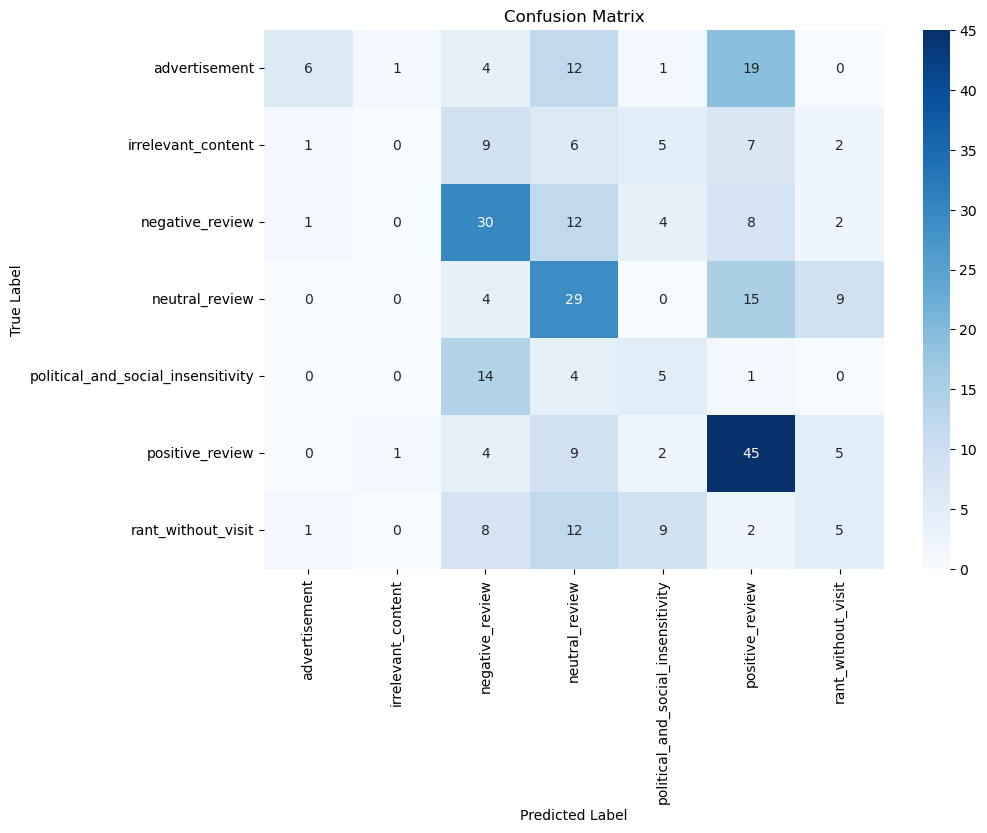

                                    precision    recall  f1-score   support

                     advertisement       0.67      0.14      0.23        43
                irrelevant_content       0.00      0.00      0.00        30
                   negative_review       0.41      0.53      0.46        57
                    neutral_review       0.35      0.51      0.41        57
political_and_social_insensitivity       0.19      0.21      0.20        24
                   positive_review       0.46      0.68      0.55        66
                rant_without_visit       0.22      0.14      0.17        37

                          accuracy                           0.38       314
                         macro avg       0.33      0.31      0.29       314
                      weighted avg       0.37      0.38      0.34       314



In [45]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load your CSV
# Ensure your CSV has columns: 'true_label' and 'predicted_label'
df = pd.read_csv("ensemble_evaluation_final_modified_summary.csv")

# Extract true and predicted labels
y_true = df['policy_label']
y_pred = df['predicted_label']

# Get unique labels (important for multi-class)
labels = sorted(df['policy_label'].unique())

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Optional: display as heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Optional: print detailed classification report
print(classification_report(y_true, y_pred, zero_division=0))